In [1]:
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import matplotlib.colors as colors
from matplotlib import cm
# from mpl_toolkits.mplot3d import axes3d

import pandas as pd
import scipy

from scipy import stats

from lifelines import KaplanMeierFitter 
from lifelines.plotting import rmst_plot
from lifelines.statistics import logrank_test
from lifelines import NelsonAalenFitter, WeibullFitter
sns.set()

epsilon =  10.**(-32.)

sns.set_style("white")

In [2]:
#Patient ids
pt_keyDF = pd.read_csv('/Users/oipulk/Documents/prime_data/preprocessed/combinedTPM_pt_id_key.csv', index_col=0)
cohort_names = np.array(['Hugo', 'Riaz', 'Liu', 'Gide', 'Newell', 'Cm38', 'Cm64', 'Cm67'])
PMID_dict = {'Hugo':'PMID: 26997480', 'Riaz': 'PMID: 29033130', 'Liu':'PMID: 31792460', 'Gide':'PMID: 30753825', 
'Newell':'PMID: 34951955', 'Cm38': 'PMID: 37037616', 'Cm64': 'PMID: 37037616', 'Cm67': 'PMID: 37037616'}

In [3]:
# Only housekeeping gene correction in latent space. This is our preferred method because it does not assume raw counts as input
log2tpm_bc = pd.read_csv('/Users/oipulk/Documents/prime_data/preprocessed/log2tpm_batch_corrected_hkpca.csv', index_col=0)
tpm_bc = pd.read_csv('/Users/oipulk/Documents/prime_data/preprocessed/tpm_batch_corrected_hkpca.csv', index_col=0)

print(log2tpm_bc.shape)
print(tpm_bc.shape)

#iRECIST: PD=1, SD=2, PR=3, CR=4
#iRECIST: PD=1, SD=2, PR=3, CR=4
irs = pd.read_csv('/Users/oipulk/Documents/prime_data/preprocessed/combinedIR_score_df.csv', index_col=0)
irs.columns = ['iR_score']
print(irs.shape)

responders = (irs>2).astype(int)
dc = (irs>1).astype(int)
cr = (irs>3).astype(int)

os_pfs_df = pd.read_csv('/Users/oipulk/Documents/prime_data/preprocessed/OS_PFS_df.csv', index_col=0)

geneList = tpm_bc.index.values

(18505, 323)
(18505, 323)
(323, 1)


In [4]:
#Batch corrected tmb
tmbDF = pd.read_csv('/Users/oipulk/Documents/prime_data/preprocessed/combined_logTMB_bc.csv',  index_col=0)

batch_inds = np.load('/Users/oipulk/Documents/prime_data/batch_inds.npy') 
batch_inds = batch_inds.astype(int)
batch_inds_orig = batch_inds.copy()

#Define auxiliary tmb data imputed with zeros
TMB_aux = np.copy(tmbDF)
tmb_measured = np.where(~np.isnan(TMB_aux))[0]


## KM for various signatures

In [5]:
Models = ['IMPRES','TIDE','CTL','TMB','PD1','PDL1','PRIME']

### 1. CTL

In [6]:
def compute_ctl_score(dataDF):
    
    # Sum tpm counts over ctl genes
    ctl_genes = ['CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1']
    ctl_score = dataDF.loc[ctl_genes].mean()
    ctlDF = pd.DataFrame(data=ctl_score, columns = ['CTL score'])
    
    
    return ctlDF

ctlDF = compute_ctl_score(tpm_bc)

In [7]:
## Import DEA results and Boltzmann weights for GSP'/PSP genes
gsp_psp_stats = pd.read_csv('/Users/oipulk/Documents/prime_v3/nb/analyses/DEA/DEA_results_3cohorts_gsp_psp_genes.csv', index_col=0)
gsp_psp_stats

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
ARHGAP42   2573.592785       -0.611698  0.176612 -3.463523  5.331508e-04   
DCUN1D5    1609.022415       -0.523445  0.143482 -3.648166  2.641193e-04   
GPSM1       796.090485       -0.614065  0.160600 -3.823571  1.315326e-04   
RCOR2       111.330398       -0.986066  0.251402 -3.922273  8.771739e-05   
ADAMDEC1    986.645098        1.086331  0.335860  3.234475  1.218667e-03   
...                ...             ...       ...       ...           ...   
TRGV10       44.105660        1.289952  0.306229  4.212377  2.526978e-05   
TRIM69      404.330179        0.549323  0.143277  3.833999  1.260766e-04   
TVP23A      104.420780        0.744216  0.216593  3.436005  5.903604e-04   
WARS      19863.291723        1.037038  0.196741  5.271078  1.356245e-07   
XIRP1        67.582880        1.701135  0.370103  4.596388  4.298781e-06   

              padj     score  norm_score   weights  
ARHGAP42  0.030118  4.114331   -1.375420  0.000515  
DCUN1D5   0.020147  4.428140   -1.061610  0.000704  
GPSM1     0.013497  4.919378   -0.570373  0.001151  
RCOR2     0.010918  5.503436    0.013686  0.002064  
ADAMDEC1  0.047852  4.125980   -1.363771  0.000521  
...            ...       ...         ...       ...  
TRGV10    0.004771  6.635175    1.145424  0.006402  
TRIM69    0.013381  4.863275   -0.626476  0.001088  
TVP23A    0.031465  4.203111   -1.286640  0.000562  
WARS      0.000205  9.529941    4.040191  0.115741  
XIRP1     0.001661  8.101641    2.611891  0.027745  

[105 rows x 9 columns]

### TIDE

In [8]:
## New computation of Tide scores because iR score is not needed, so we get two more patients. 
# # Anonymize patients
to_tide_data = log2tpm_bc.copy()

# to_tide_data1.columns = np.arange(to_tide_data1.shape[1])
to_tide_data.columns = np.arange(to_tide_data.shape[1])
# Subtract mean
to_tide_data = to_tide_data - np.mean(to_tide_data, axis=0)

# print(to_tide_data1.shape)
print(to_tide_data.shape)

to_tide_data.to_csv('/Users/oipulk/Documents/prime_data/tide/to_tide_data_hkpca_all_pt.csv', sep='\t')


######################################
# Analysis at TIDE website
# http://tide.dfci.harvard.edu/
######################################


(18505, 323)


In [9]:
tide_res =  pd.read_csv('/Users/oipulk/Documents/prime_data/tide/tide_results_all_pt.csv')
print(tide_res)

#Remove row of NaN's at the end of the list if it exists 
tide_res = tide_res.iloc[0:(tide_res.shape[0]-1),:]

tide_res = tide_res.sort_values(by=['Patient'])



     Patient No benefits Responder  TIDE  IFNG  MSI Expr Sig  Merck18  CD274  \
0      174.0       False     False  2.64 -0.86          0.29    -0.34  -2.95   
1      159.0       False     False  2.61 -0.93          0.50    -0.53  -2.69   
2        8.0        True     False  2.58 -1.69          0.27    -1.09  -2.02   
3      215.0       False     False  2.55 -0.15          0.48    -0.05  -1.97   
4      222.0        True     False  2.52 -1.02          0.50    -0.63  -1.98   
..       ...         ...       ...   ...   ...           ...      ...    ...   
319    224.0       False      True -1.63  2.87          0.83     0.91   1.54   
320     92.0       False      True -1.64  2.80          0.73     1.80   0.66   
321    242.0       False      True -1.71  2.23          0.68     1.97   1.34   
322    235.0       False      True -1.75  3.58          0.91     1.68   3.18   
323      NaN         NaN       NaN   NaN   NaN           NaN      NaN    NaN   

      CD8 CTL.flag  Dysfunction  Exclus

### Impres

In [10]:
# IMPRES gene pairs (gene names adapted to our data, eg. VISTA->VSIR)
impres_pairs = {'Gene1': ['PDCD1', 'CD27', 'CTLA4', 'CD40', 'CD86', 'CD28', 'CD80', 'CD274', 'CD86', 'CD40', 'CD86', 'CD40', 'CD28', 'CD40', 'TNFRSF14'],
                 'Gene2': ['TNFSF4', 'PDCD1', 'TNFSF4', 'CD28', 'TNFSF4', 'CD86', 'TNFSF9', 'VSIR', 'HAVCR2', 'PDCD1', 'CD200', 'CD80', 'CD276', 'CD274', 'CD86']}
impresDF = pd.DataFrame(data=impres_pairs)

def compute_impres(single_pt_xpr_df, impres_df):
    
    '''''''''
    Input single_pt_xpr_df must be a pandas dataframe with gene names as index 
    and expression data as values
    '''''''''
    impress_score=0
    
    for row in np.arange(impres_df.shape[0]):
        
        gene1 = impres_df['Gene1'][row]
        gene2 = impres_df['Gene2'][row]
        
        if single_pt_xpr_df.loc[gene1].values.astype(float) < single_pt_xpr_df.loc[gene2].values.astype(float):
            
            impress_score = impress_score+1
            
    return impress_score

In [11]:
impres_scores = np.array([])

for ptInd in np.arange(0,log2tpm_bc.shape[1]):
    
    ptName = log2tpm_bc.keys()[ptInd]
    
    pt_score = compute_impres(log2tpm_bc[[ptName]], impresDF)
    impres_scores = np.append(impres_scores,pt_score)


In [12]:
stratify_by_CD8 = True
thresholds_opt = np.array([])

for model in Models:

    #pt_pfs: alive=0 , dead=1. Check that all patients with RECIST have pfs events and days data
    # pt_pfs = np.where((~pd.isna(os_pfs_df['PFS Status'].values))&(~pd.isna(os_pfs_df['PFS Days'].values))&((batch_inds==3)|(batch_inds>4)))[0]
    pt_pfs = np.where((~pd.isna(os_pfs_df['PFS Status'].values))&(~pd.isna(os_pfs_df['PFS Days'].values)))[0]

    if stratify_by_CD8:
        
        quantiles = np.quantile(log2tpm_bc.loc['CD8A'],[0.25,0.5,0.75])
        
        for quant in quantiles:
            
            pt_strat = np.where(log2tpm_bc.loc['CD8A']>quantiles[1])[0]
            pt_pfs = np.intersect1d(pt_pfs, pt_strat)
    
    pfs_days_df =  os_pfs_df.iloc[pt_pfs]['PFS Days']
    pfs_event_df = os_pfs_df.iloc[pt_pfs]['PFS Status']
    
    tpm_data = tpm_bc.iloc[:,pt_pfs] 
    log2tpm_data = log2tpm_bc.iloc[:,pt_pfs] 
    
    responders_data = responders.iloc[pt_pfs]
    
    irs_data = irs.iloc[pt_pfs]
    batch_ind_data = batch_inds[pt_pfs]

    if model == 'CTL':

        model_data =  np.log2(1+compute_ctl_score(tpm_data))

    if model=='TMB':

        pt_pfs = np.intersect1d(pt_pfs,tmb_measured)
        model_data = TMB_aux[pt_pfs]

    if model == 'IMPRES':

        model_data =  -impres_scores[pt_pfs]

    if model == 'TIDE':

        tide_results = tide_res.iloc[pt_pfs,:] 
        tide_df = pd.DataFrame(data = tide_results.values, index= log2tpm_data.keys(), columns= tide_res.columns )
        tide_scores = tide_df['TIDE'].values
        
        model_data = -tide_scores

    if (model == 'PD1'):

        model_data =  log2tpm_data.loc['PDCD1']

    if (model == 'PDL1'):

        model_data =  log2tpm_data.loc['CD274']
    
    if model == 'PRIME':

        weights = gsp_psp_stats['weights'].values
        data = tpm_data
        model_data = np.matmul((weights.reshape(-1,1).T),np.log2(1+data.loc[gsp_psp_stats.index.values]).values.astype(float)).T

    
    model_data = (model_data - np.mean(model_data))/np.std(model_data,axis=0)

    lrt_score=0
    lrt_score_max=-1
    q_grid = np.linspace(0.25,0.75,51)
    thresholds = np.quantile(model_data,q_grid)
    timeline_all = np.sort(np.append(0.,pfs_days_df))
    pt_all = tpm_data.keys().values
    
    for theta in np.arange(1,len(thresholds)):
    
        threshold = thresholds[theta]
        
        KMstats_lowhi_xpr =  pd.DataFrame(index=['Log rank chi^2','Log rank p','AUC low xpr', 'AUC high xpr', 'ABC'], columns = ['CTL score'])
        
        #Genes with low beta
        lower_half_bin = (model_data<threshold)
        #Genes with high beta
        upper_half_bin = (model_data>=threshold)
    
        
        lower_half_pts = pt_all[np.where(lower_half_bin)[0]]
        upper_half_pts = pt_all[np.where(upper_half_bin)[0]]
        
        lower_half_days = np.array([])
        lower_half_events = np.array([])
        
        upper_half_days = np.array([])
        upper_half_events = np.array([])
        
        if len(lower_half_pts)>0:
           
            for pt in lower_half_pts:
        
                lower_half_days = np.append(lower_half_days, pfs_days_df.loc[pt])
                lower_half_events =  np.append(lower_half_events, pfs_event_df.loc[pt].astype(int))
        
            kmfl = KaplanMeierFitter()
            kmfl.fit(lower_half_days, lower_half_events, timeline=timeline_all, label = 'Low xpr')  
        
        
        if len(upper_half_pts)>0:
            
            for pt in upper_half_pts:
        
                upper_half_days = np.append(upper_half_days, pfs_days_df.loc[pt])
                upper_half_events =  np.append(upper_half_events, pfs_event_df.loc[pt].astype(int))
          
        
            kmfu = KaplanMeierFitter()
            kmfu.fit(upper_half_days, upper_half_events, timeline=timeline_all, label = 'High xpr')  

        lrt_results = logrank_test(lower_half_days, upper_half_days, lower_half_events, upper_half_events) 

        log_rank_chi2 = lrt_results.test_statistic
        p_value = lrt_results.p_value
        lrt_score  = log_rank_chi2 - np.log(p_value)

        aucl = np.trapz(kmfl.survival_function_.iloc[:,0].values, kmfl.survival_function_.index.values)
        aucu = np.trapz(kmfu.survival_function_.iloc[:,0].values, kmfu.survival_function_.index.values)

        abc = aucu - aucl
        
        if ((lrt_score>lrt_score_max)&(abc>0)):
    
            lrt_score_max=lrt_score
            theta_max=theta
            log_rank_chi2_opt= log_rank_chi2
            p_value_opt = p_value

    thresholds_opt = np.append(thresholds_opt,q_grid[theta_max])
    print(model,log_rank_chi2_opt, p_value_opt, lrt_score_max, q_grid[theta_max])

    

IMPRES 2.2542789897533173 0.13324550309699695 4.269840954123911 0.26
TIDE 6.527455616890007 0.010622179590302268 11.07226666662433 0.75
CTL 7.697691511282148 0.005529149657884441 12.895412755471517 0.66
TMB 3.4537575293235787 0.06310814849574174 6.216662910871797 0.47
PD1 4.256197417678037 0.03910736875727874 7.49764178815963 0.42000000000000004
PDL1 11.298117456422887 0.0007758571844170855 18.459659551841142 0.5700000000000001
PRIME 15.170706476075948 9.821529644549685e-05 24.399055062526337 0.26


In [13]:
thresholds_opt

array([0.26, 0.75, 0.66, 0.47, 0.42, 0.57, 0.26])

30 108 138
IMPRES 2.2542789897533173 0.13324550309699695 4.269840954123911 0.26


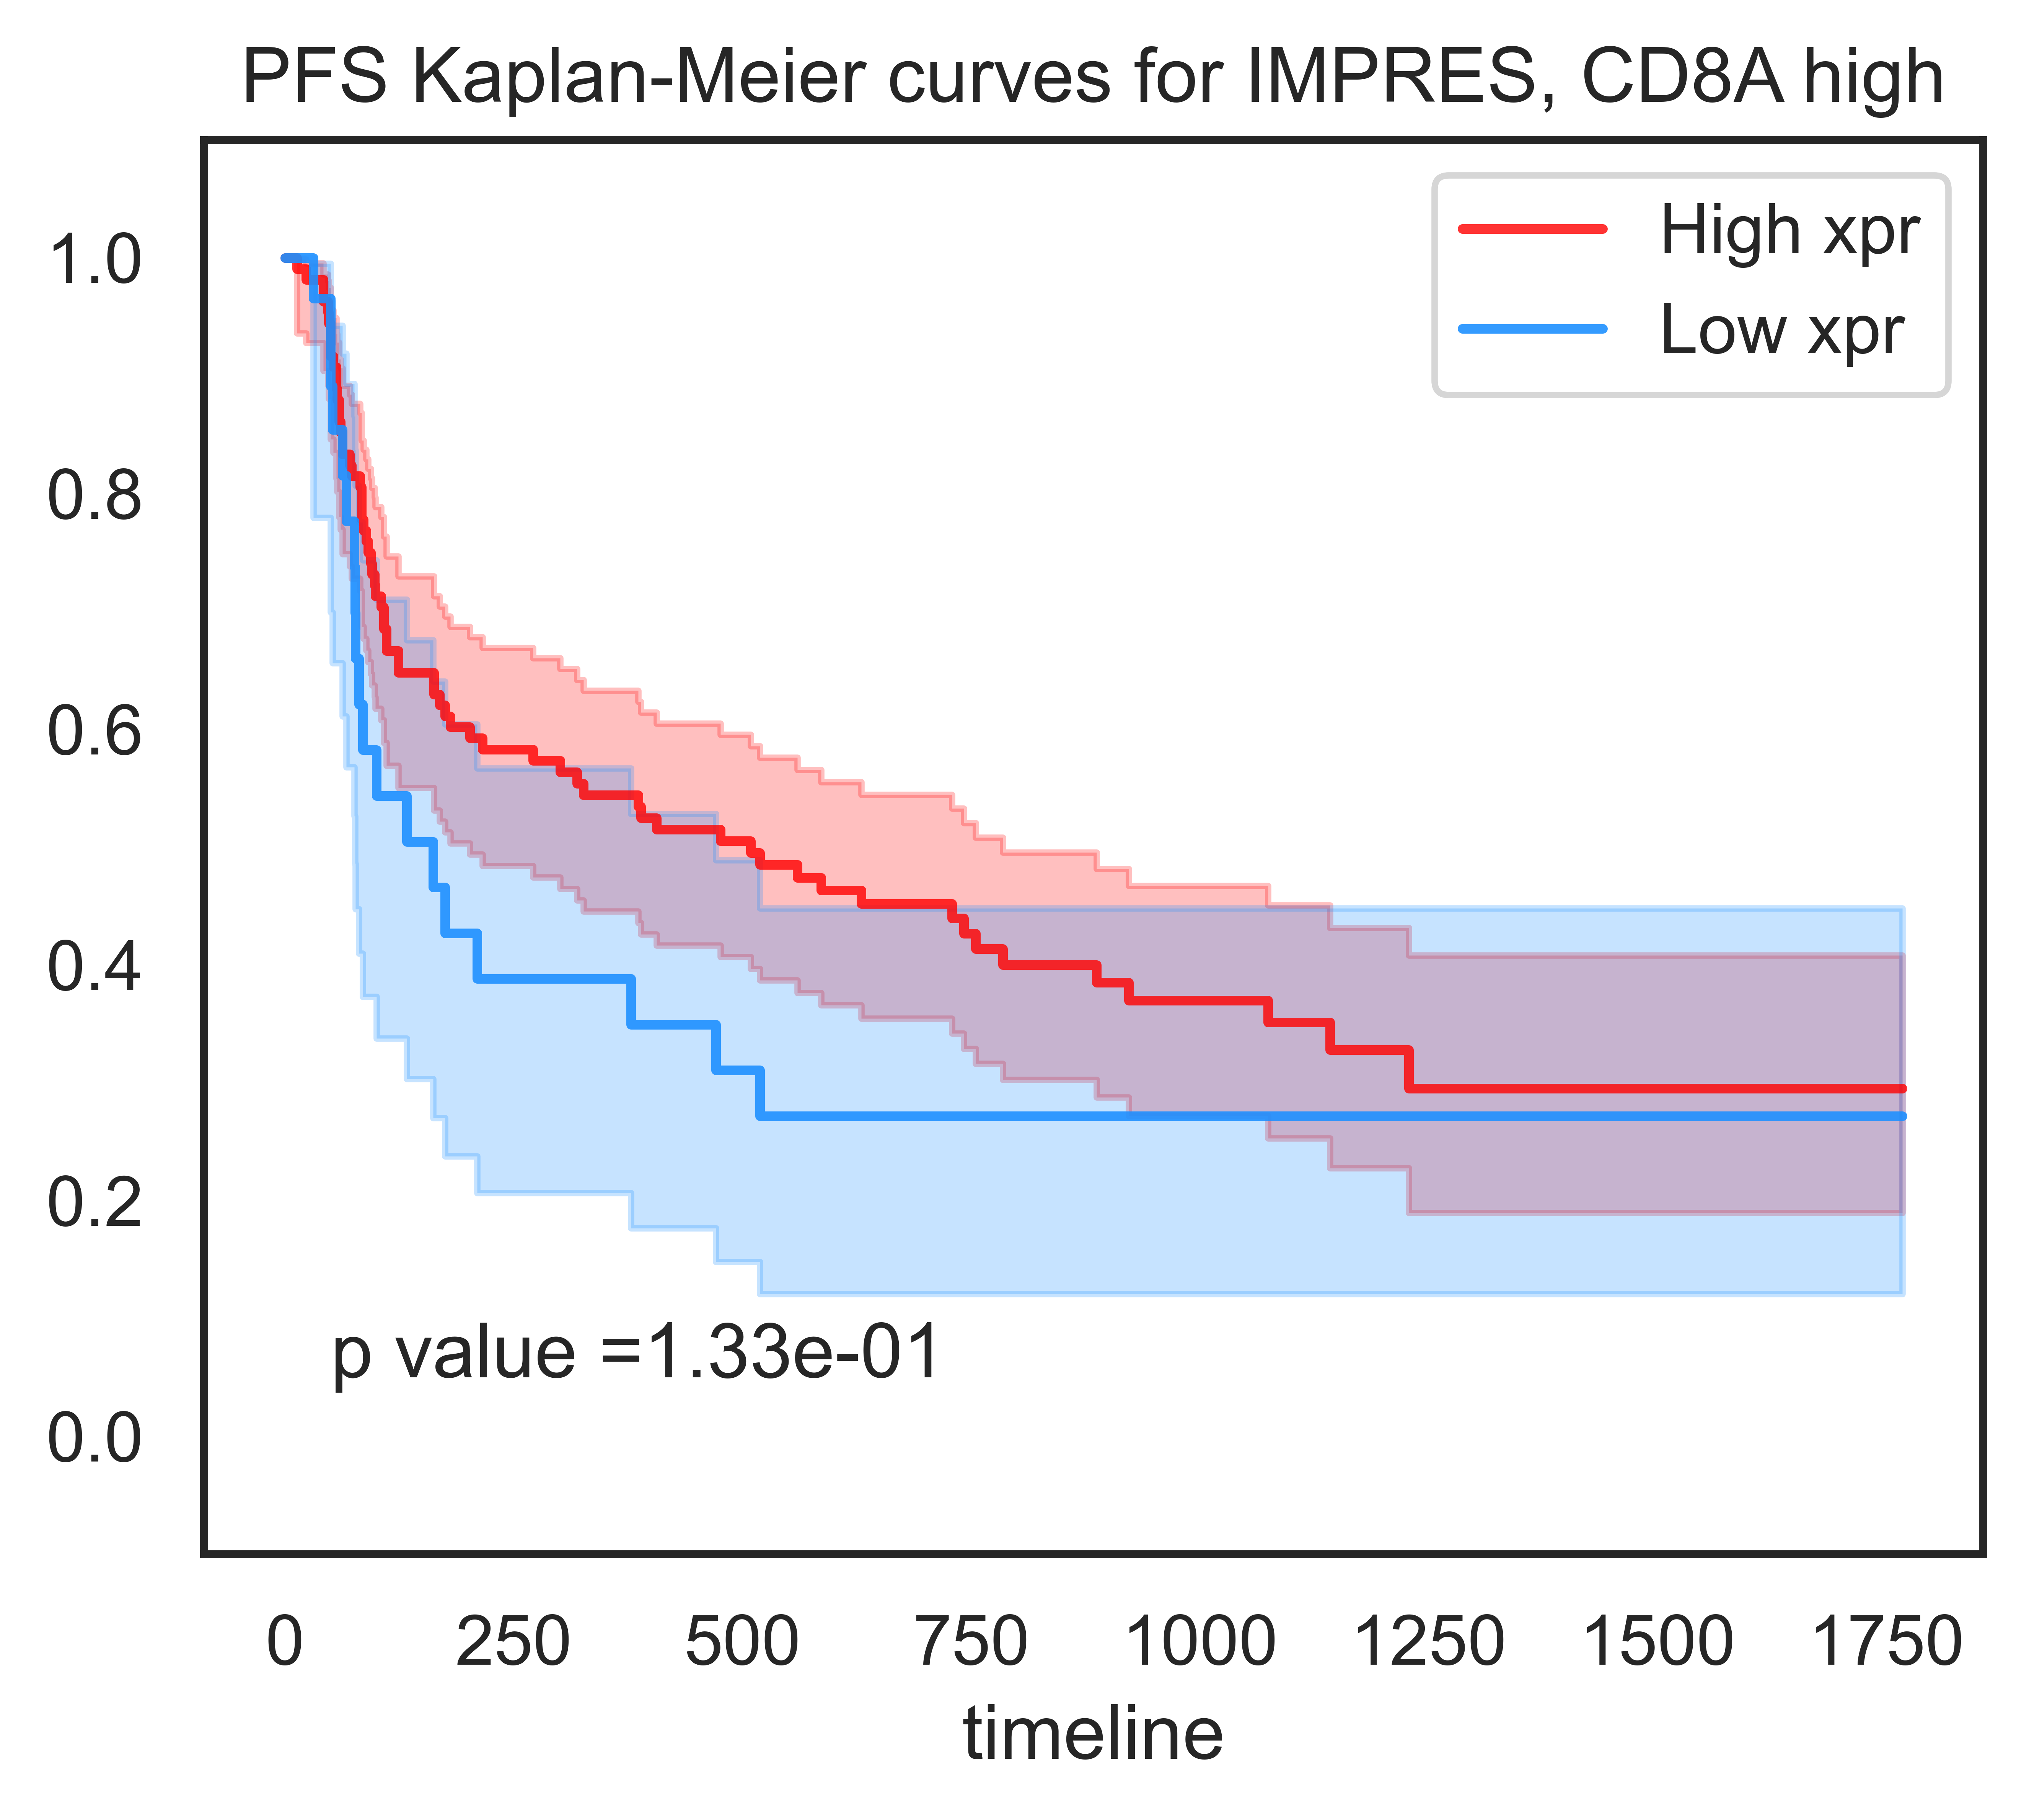

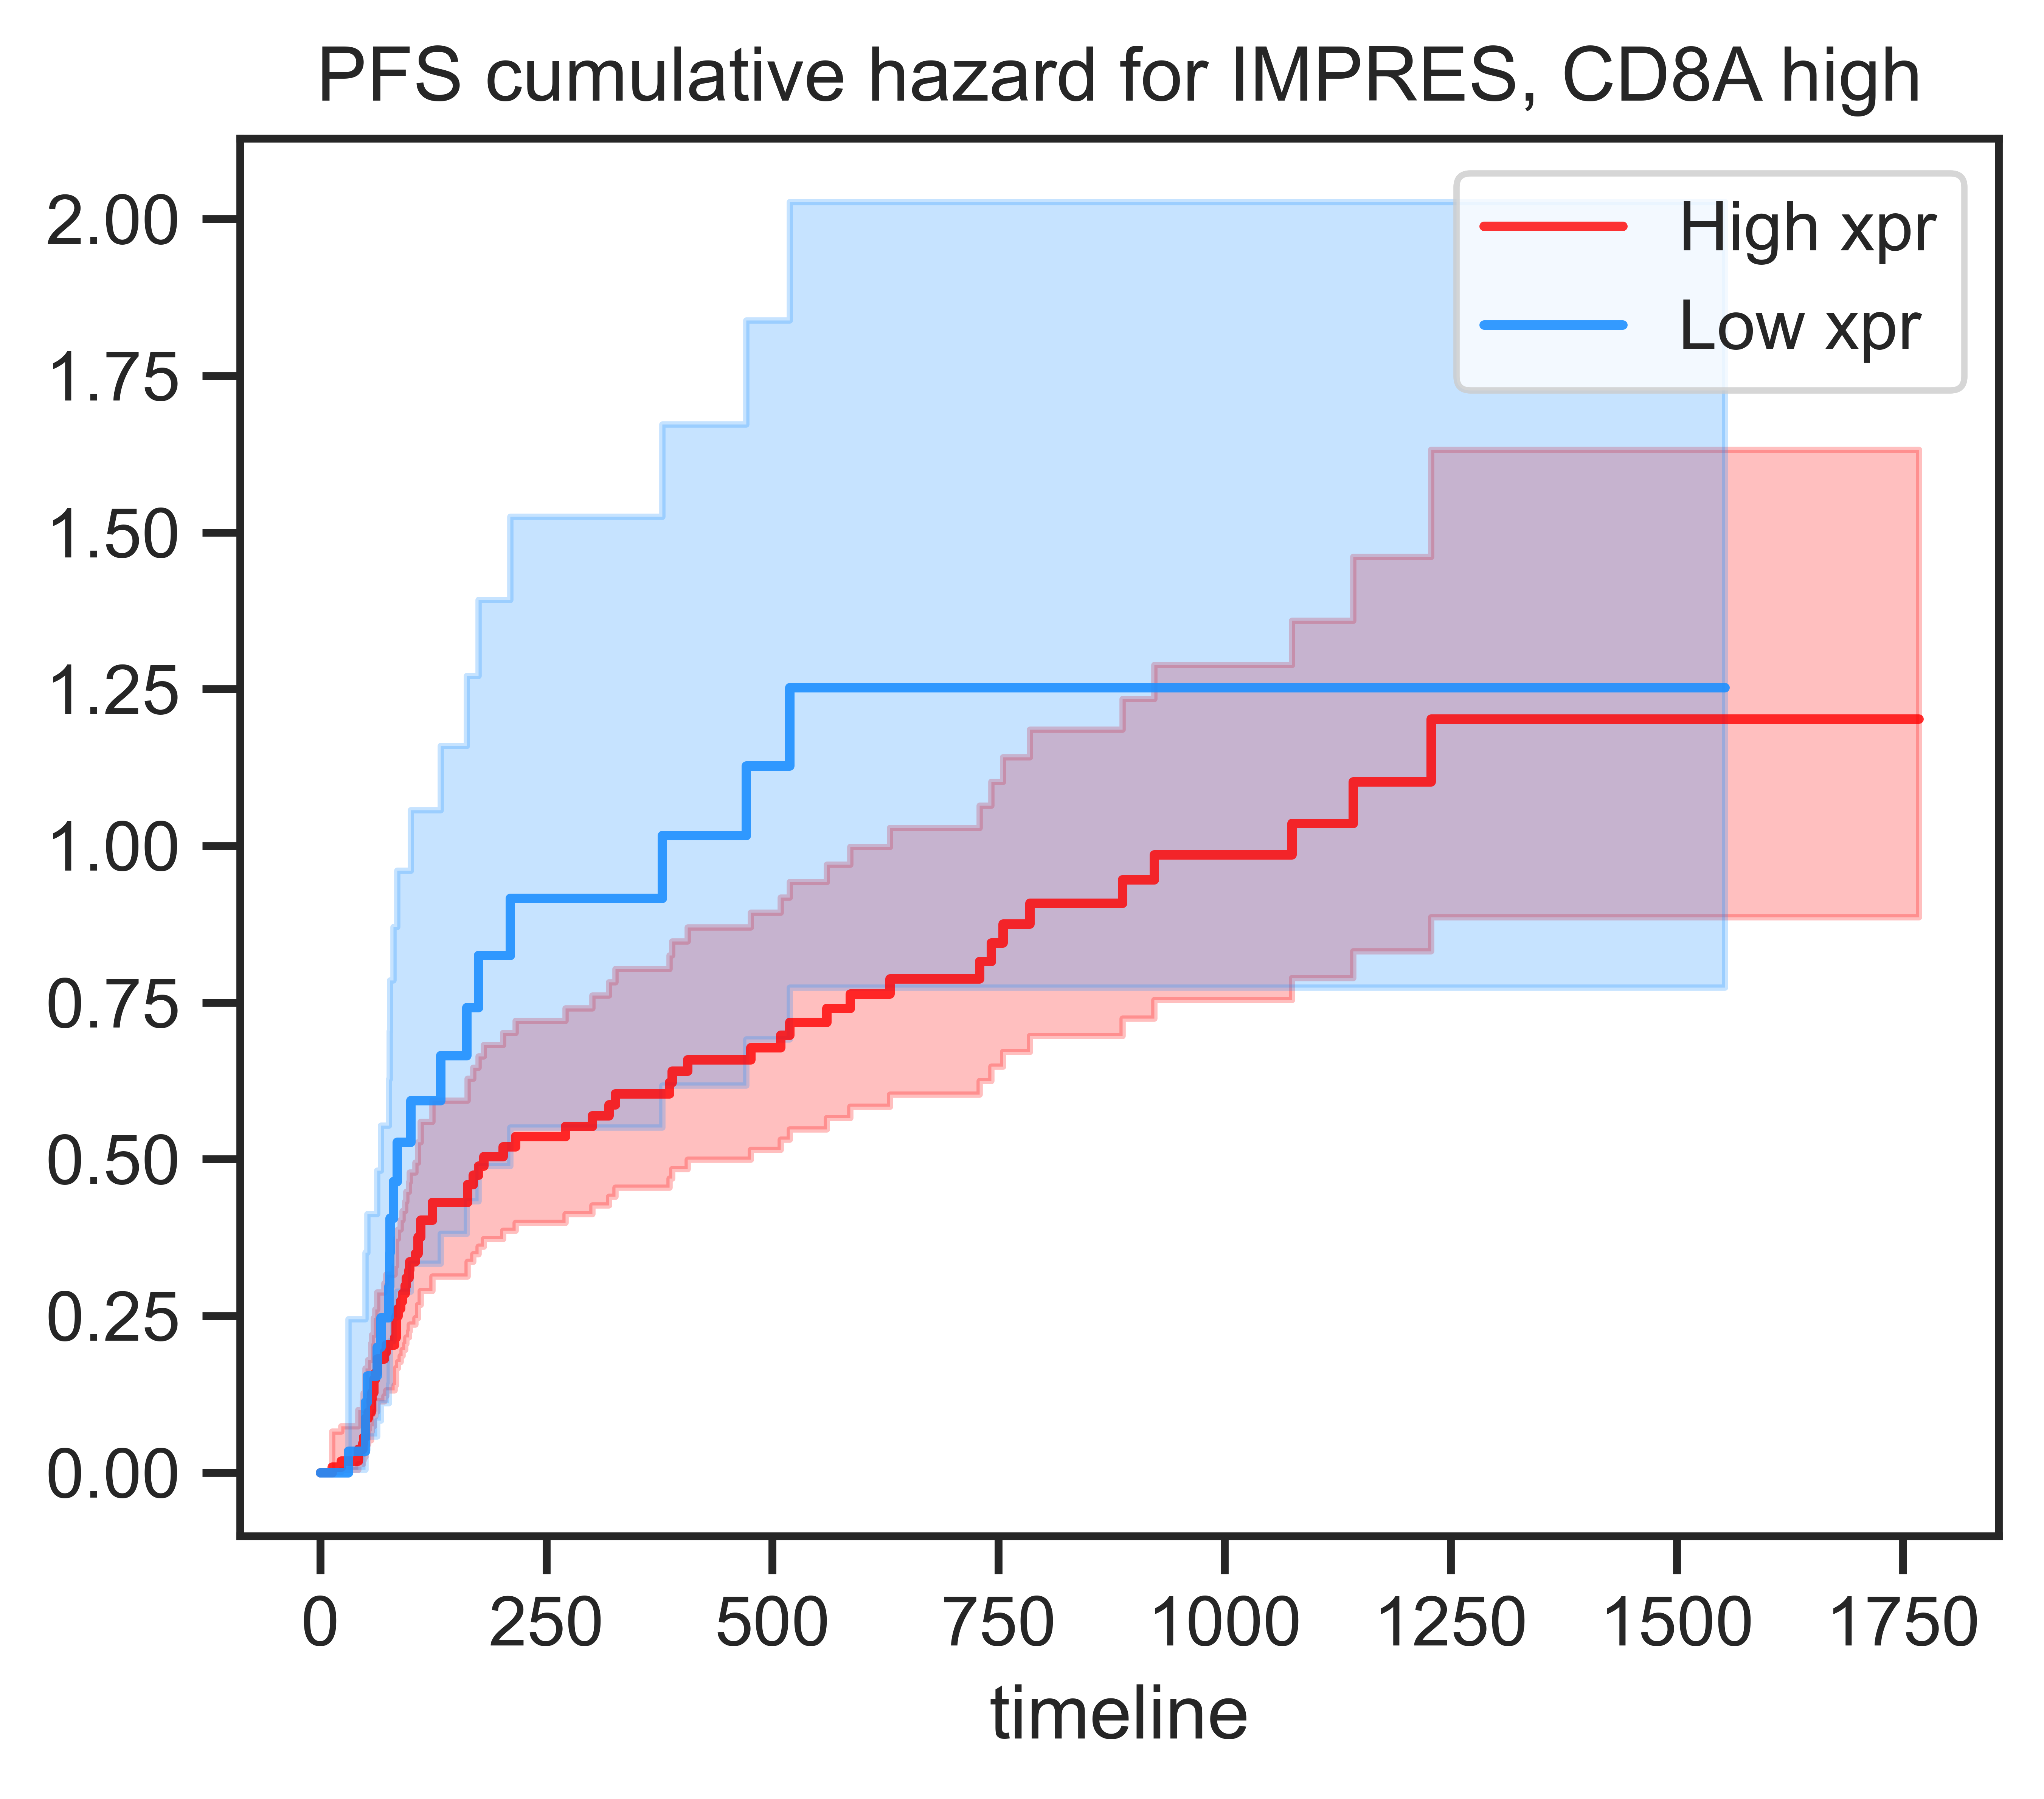

103 35 138
TIDE 6.527455616890007 0.010622179590302268 11.07226666662433 0.75


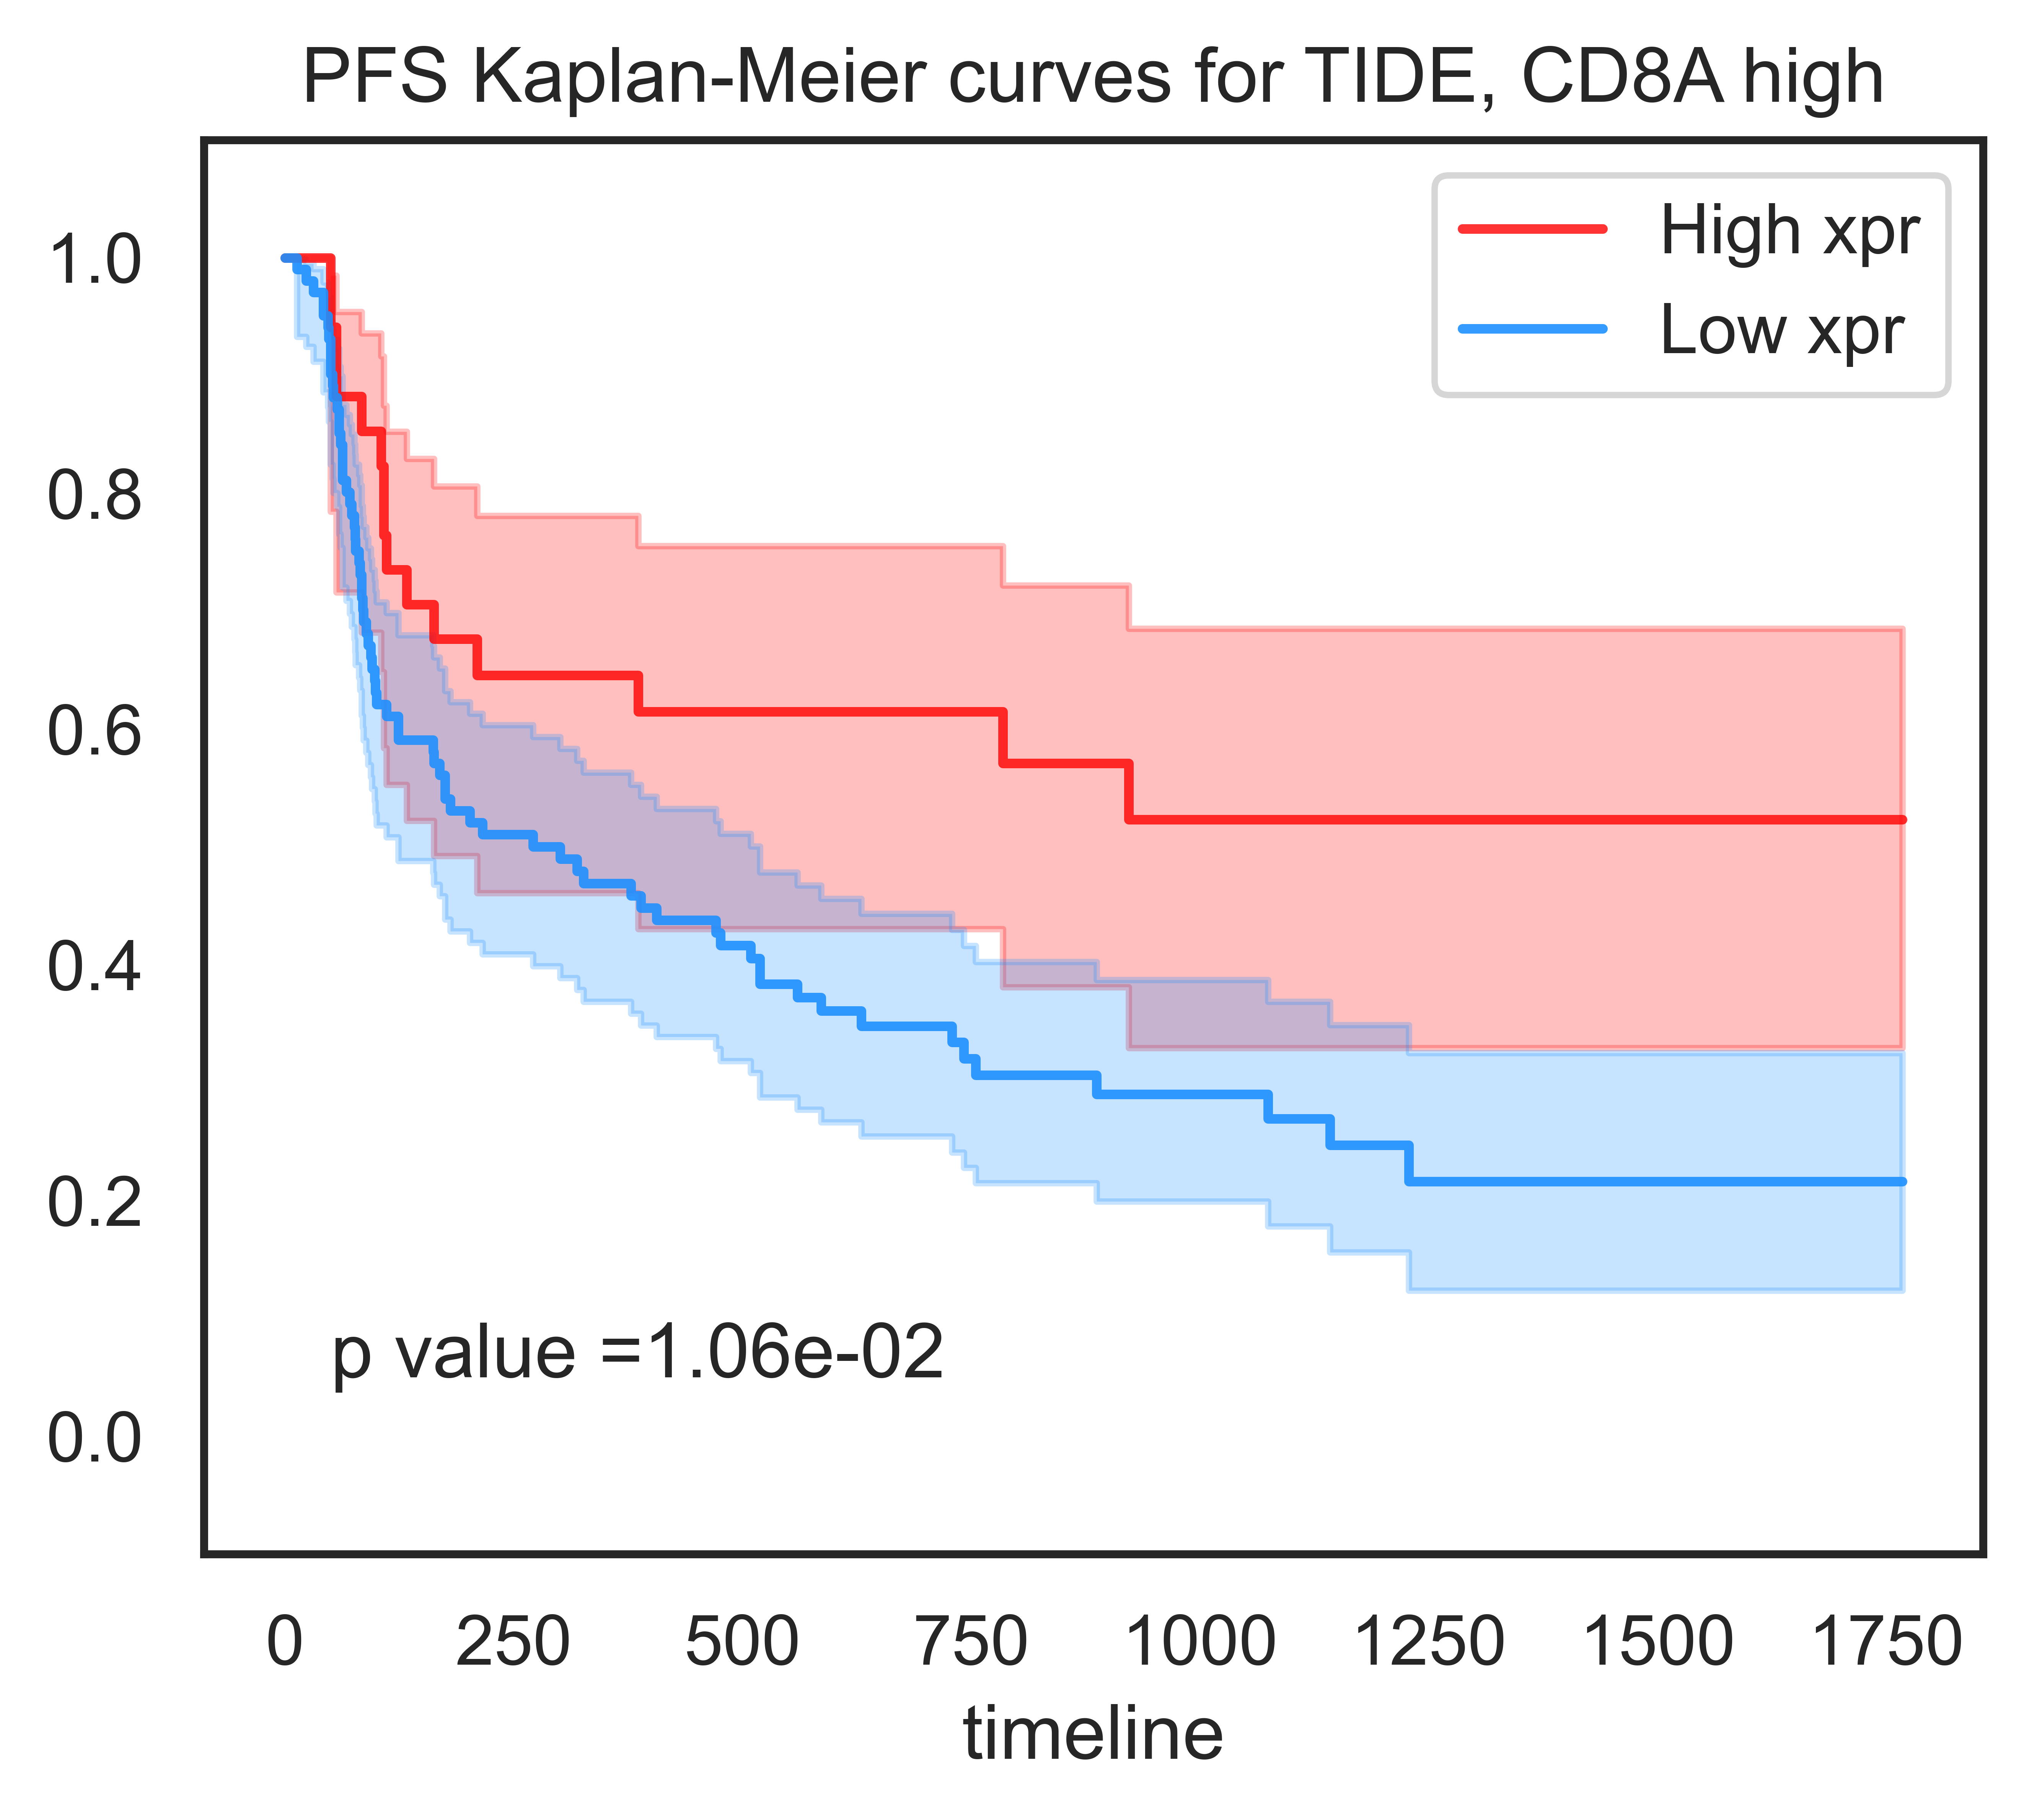

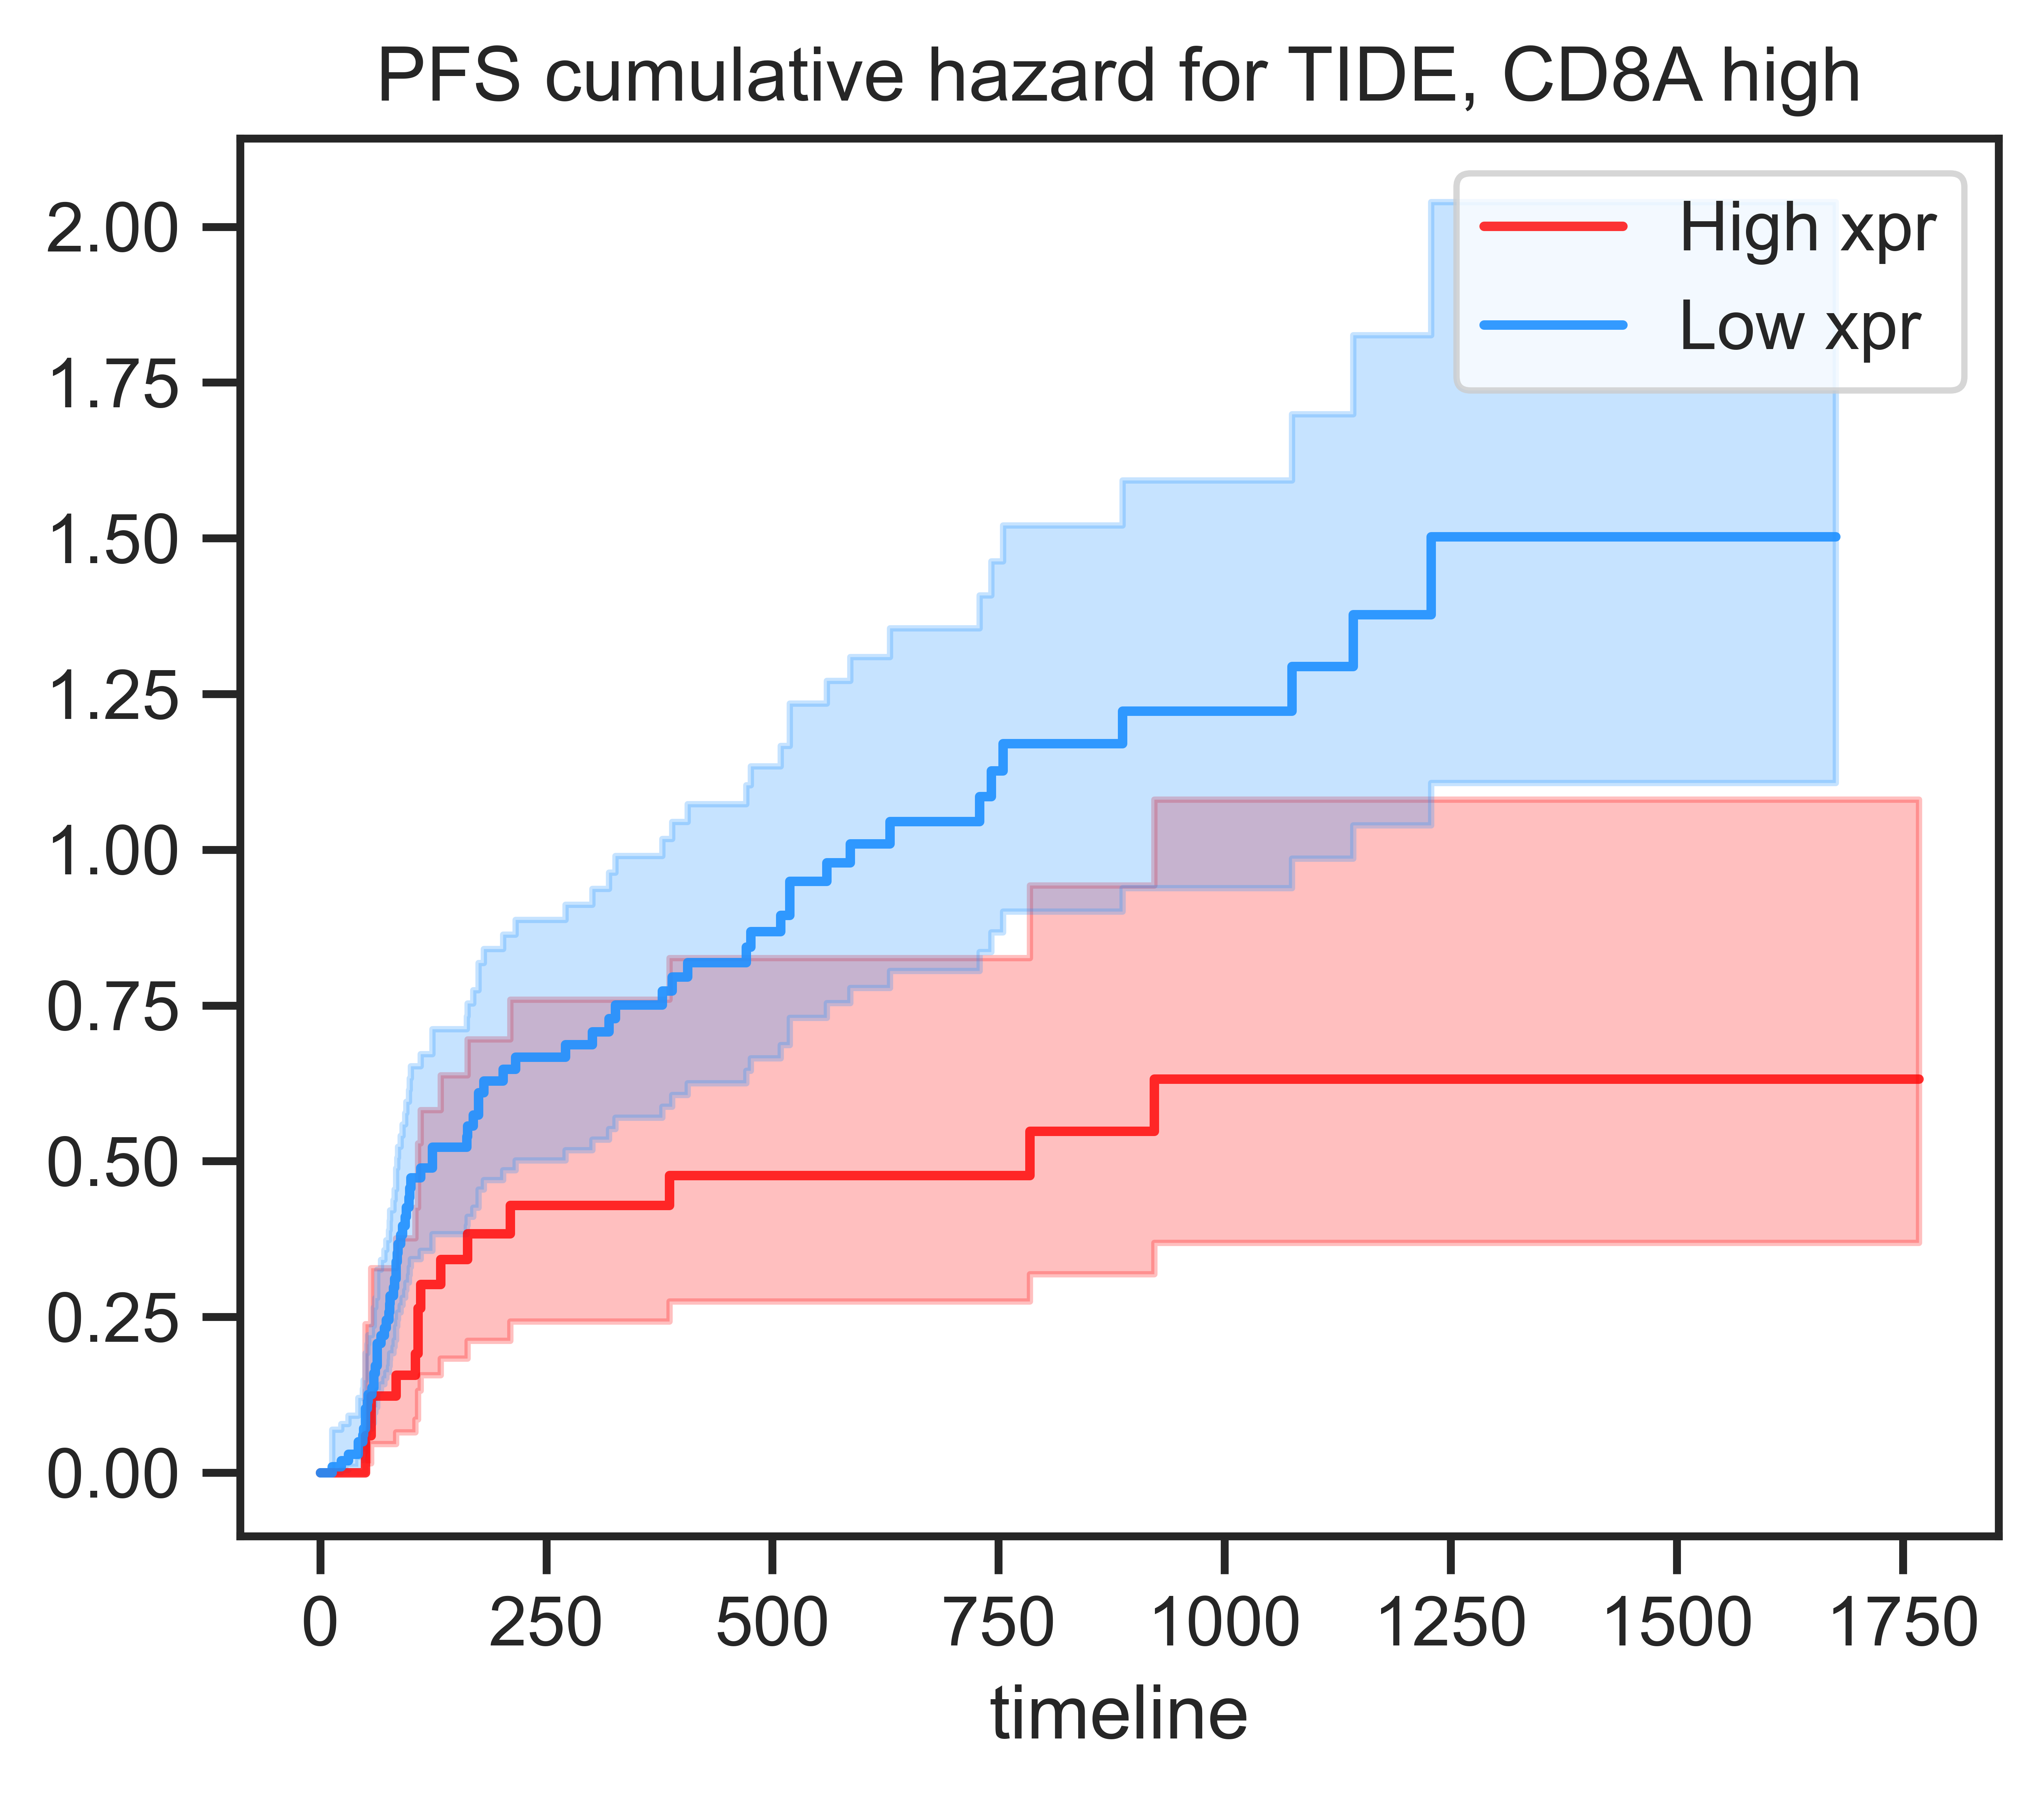

[91] [47] [138]
CTL 7.697691511282148 0.005529149657884441 12.895412755471517 0.66


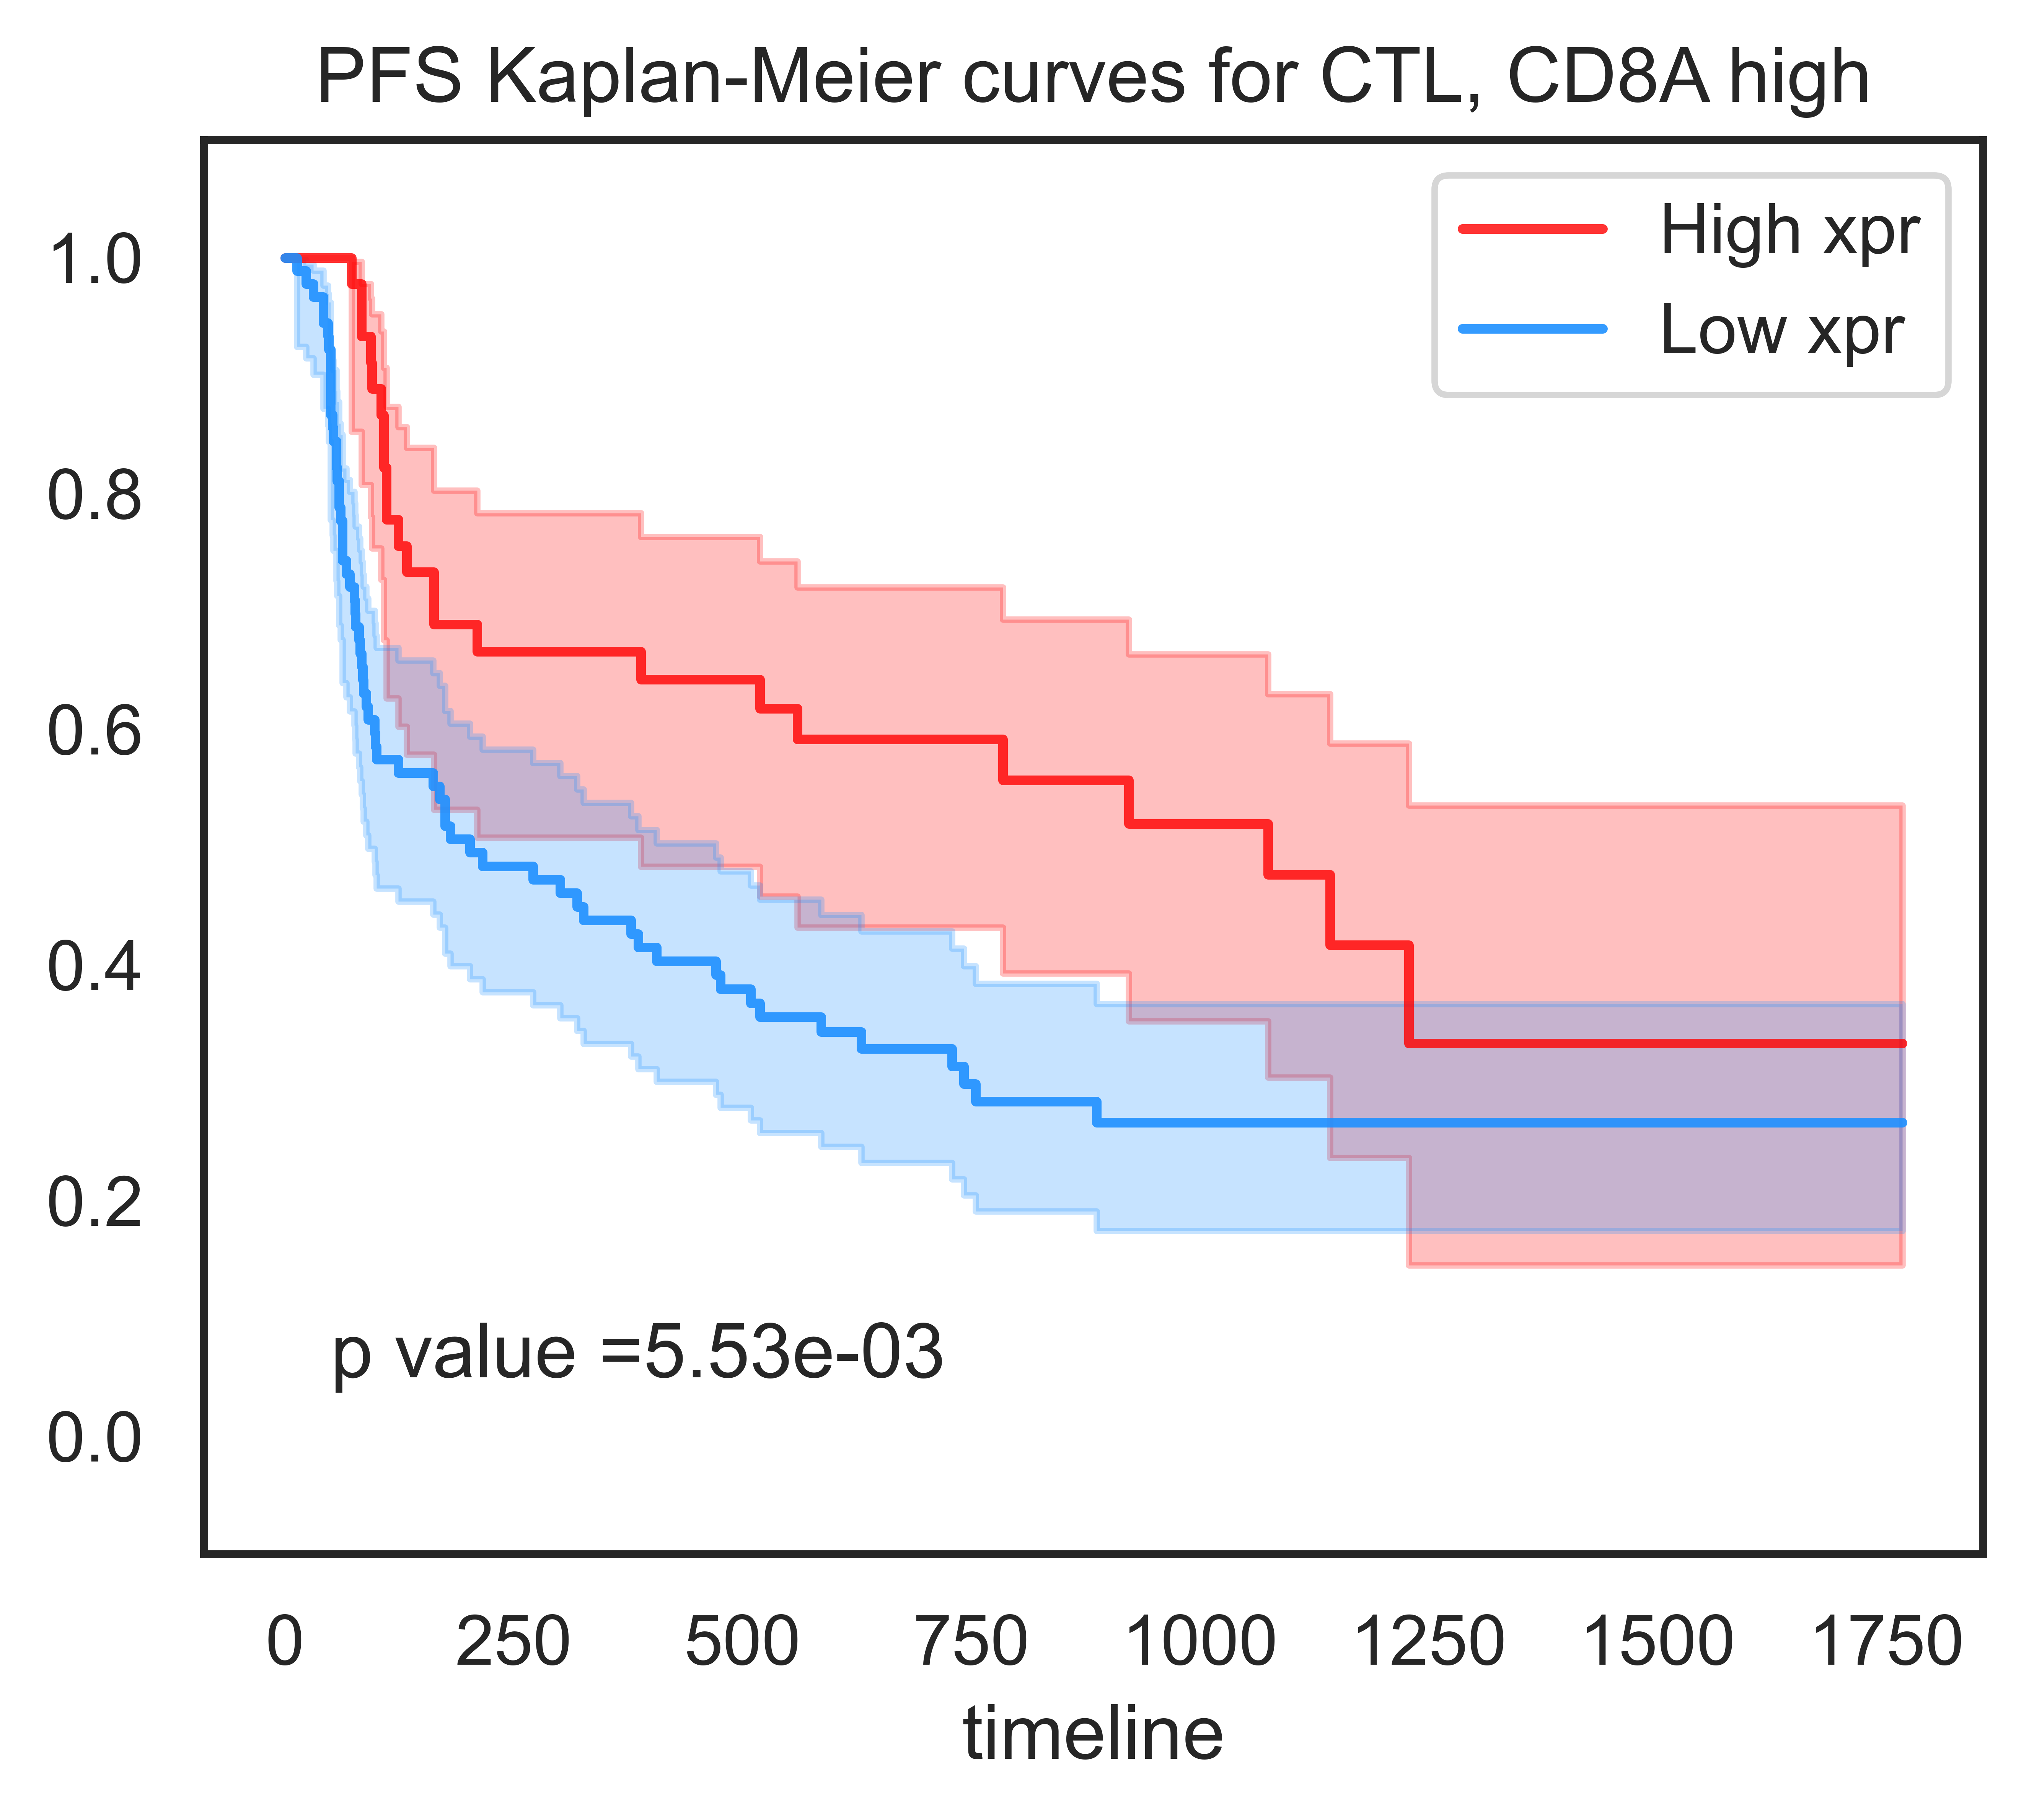

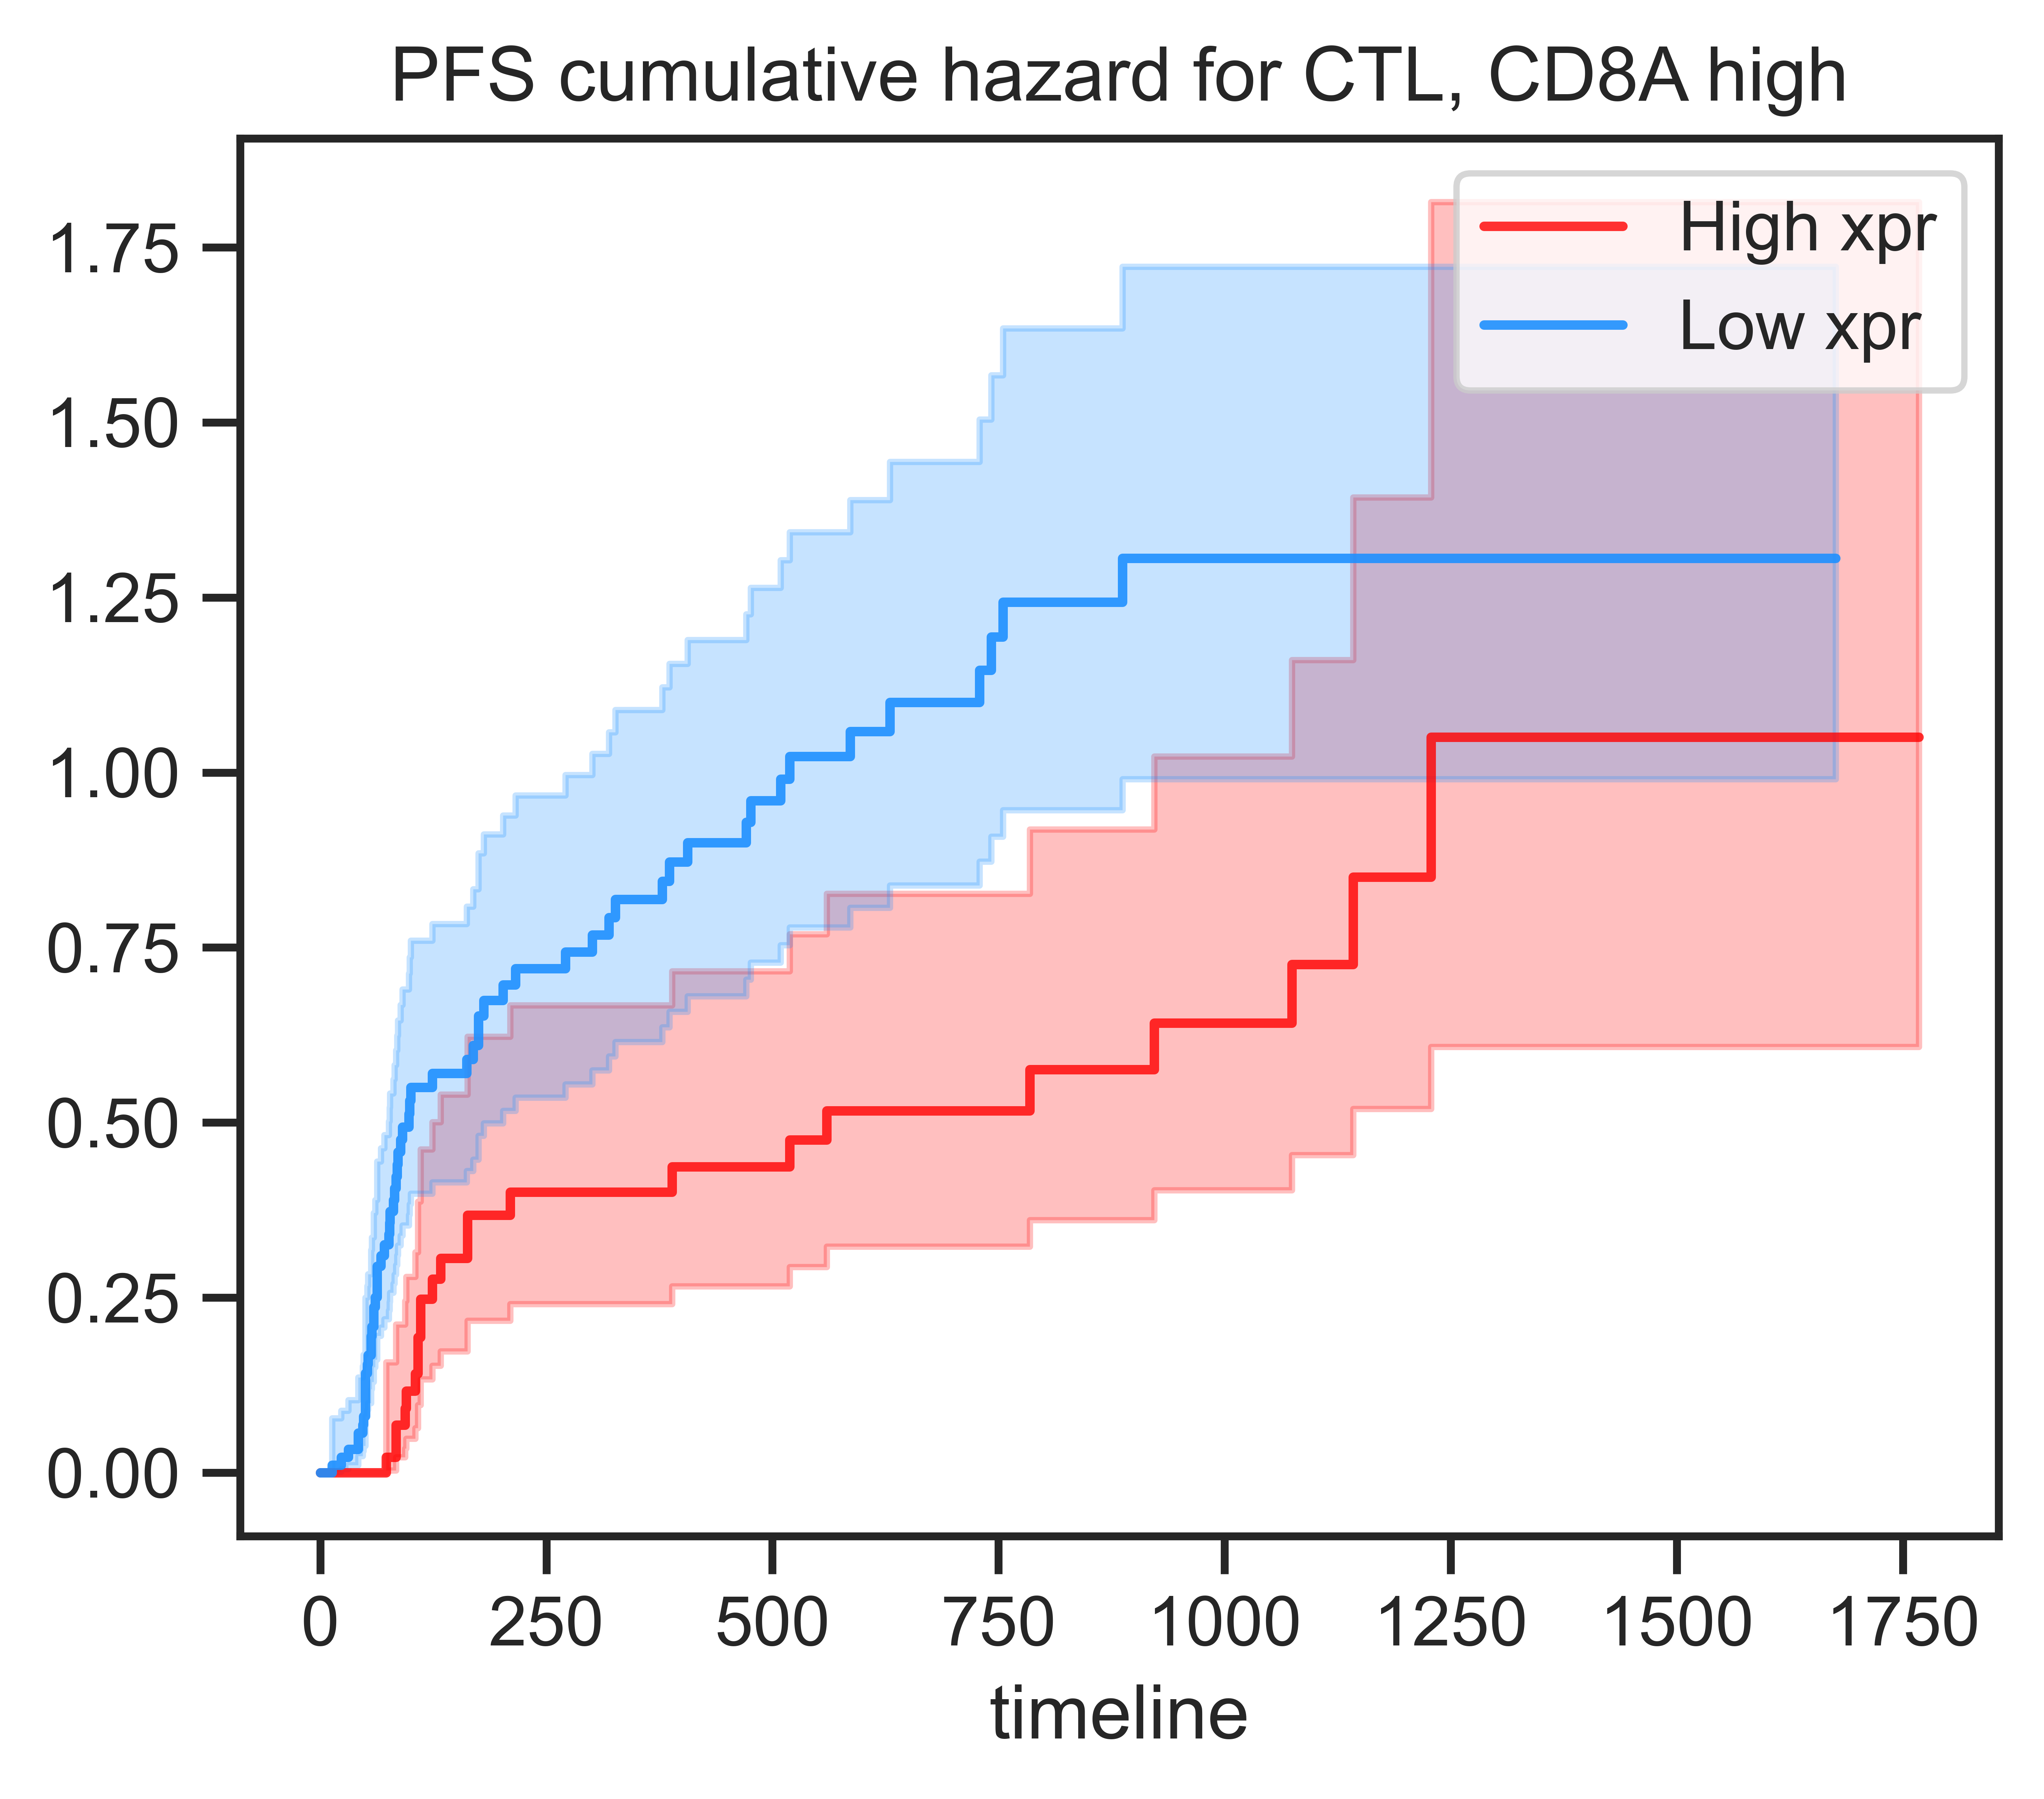

[41] [46] [87]
TMB 3.4537575293235787 0.06310814849574174 6.216662910871797 0.47


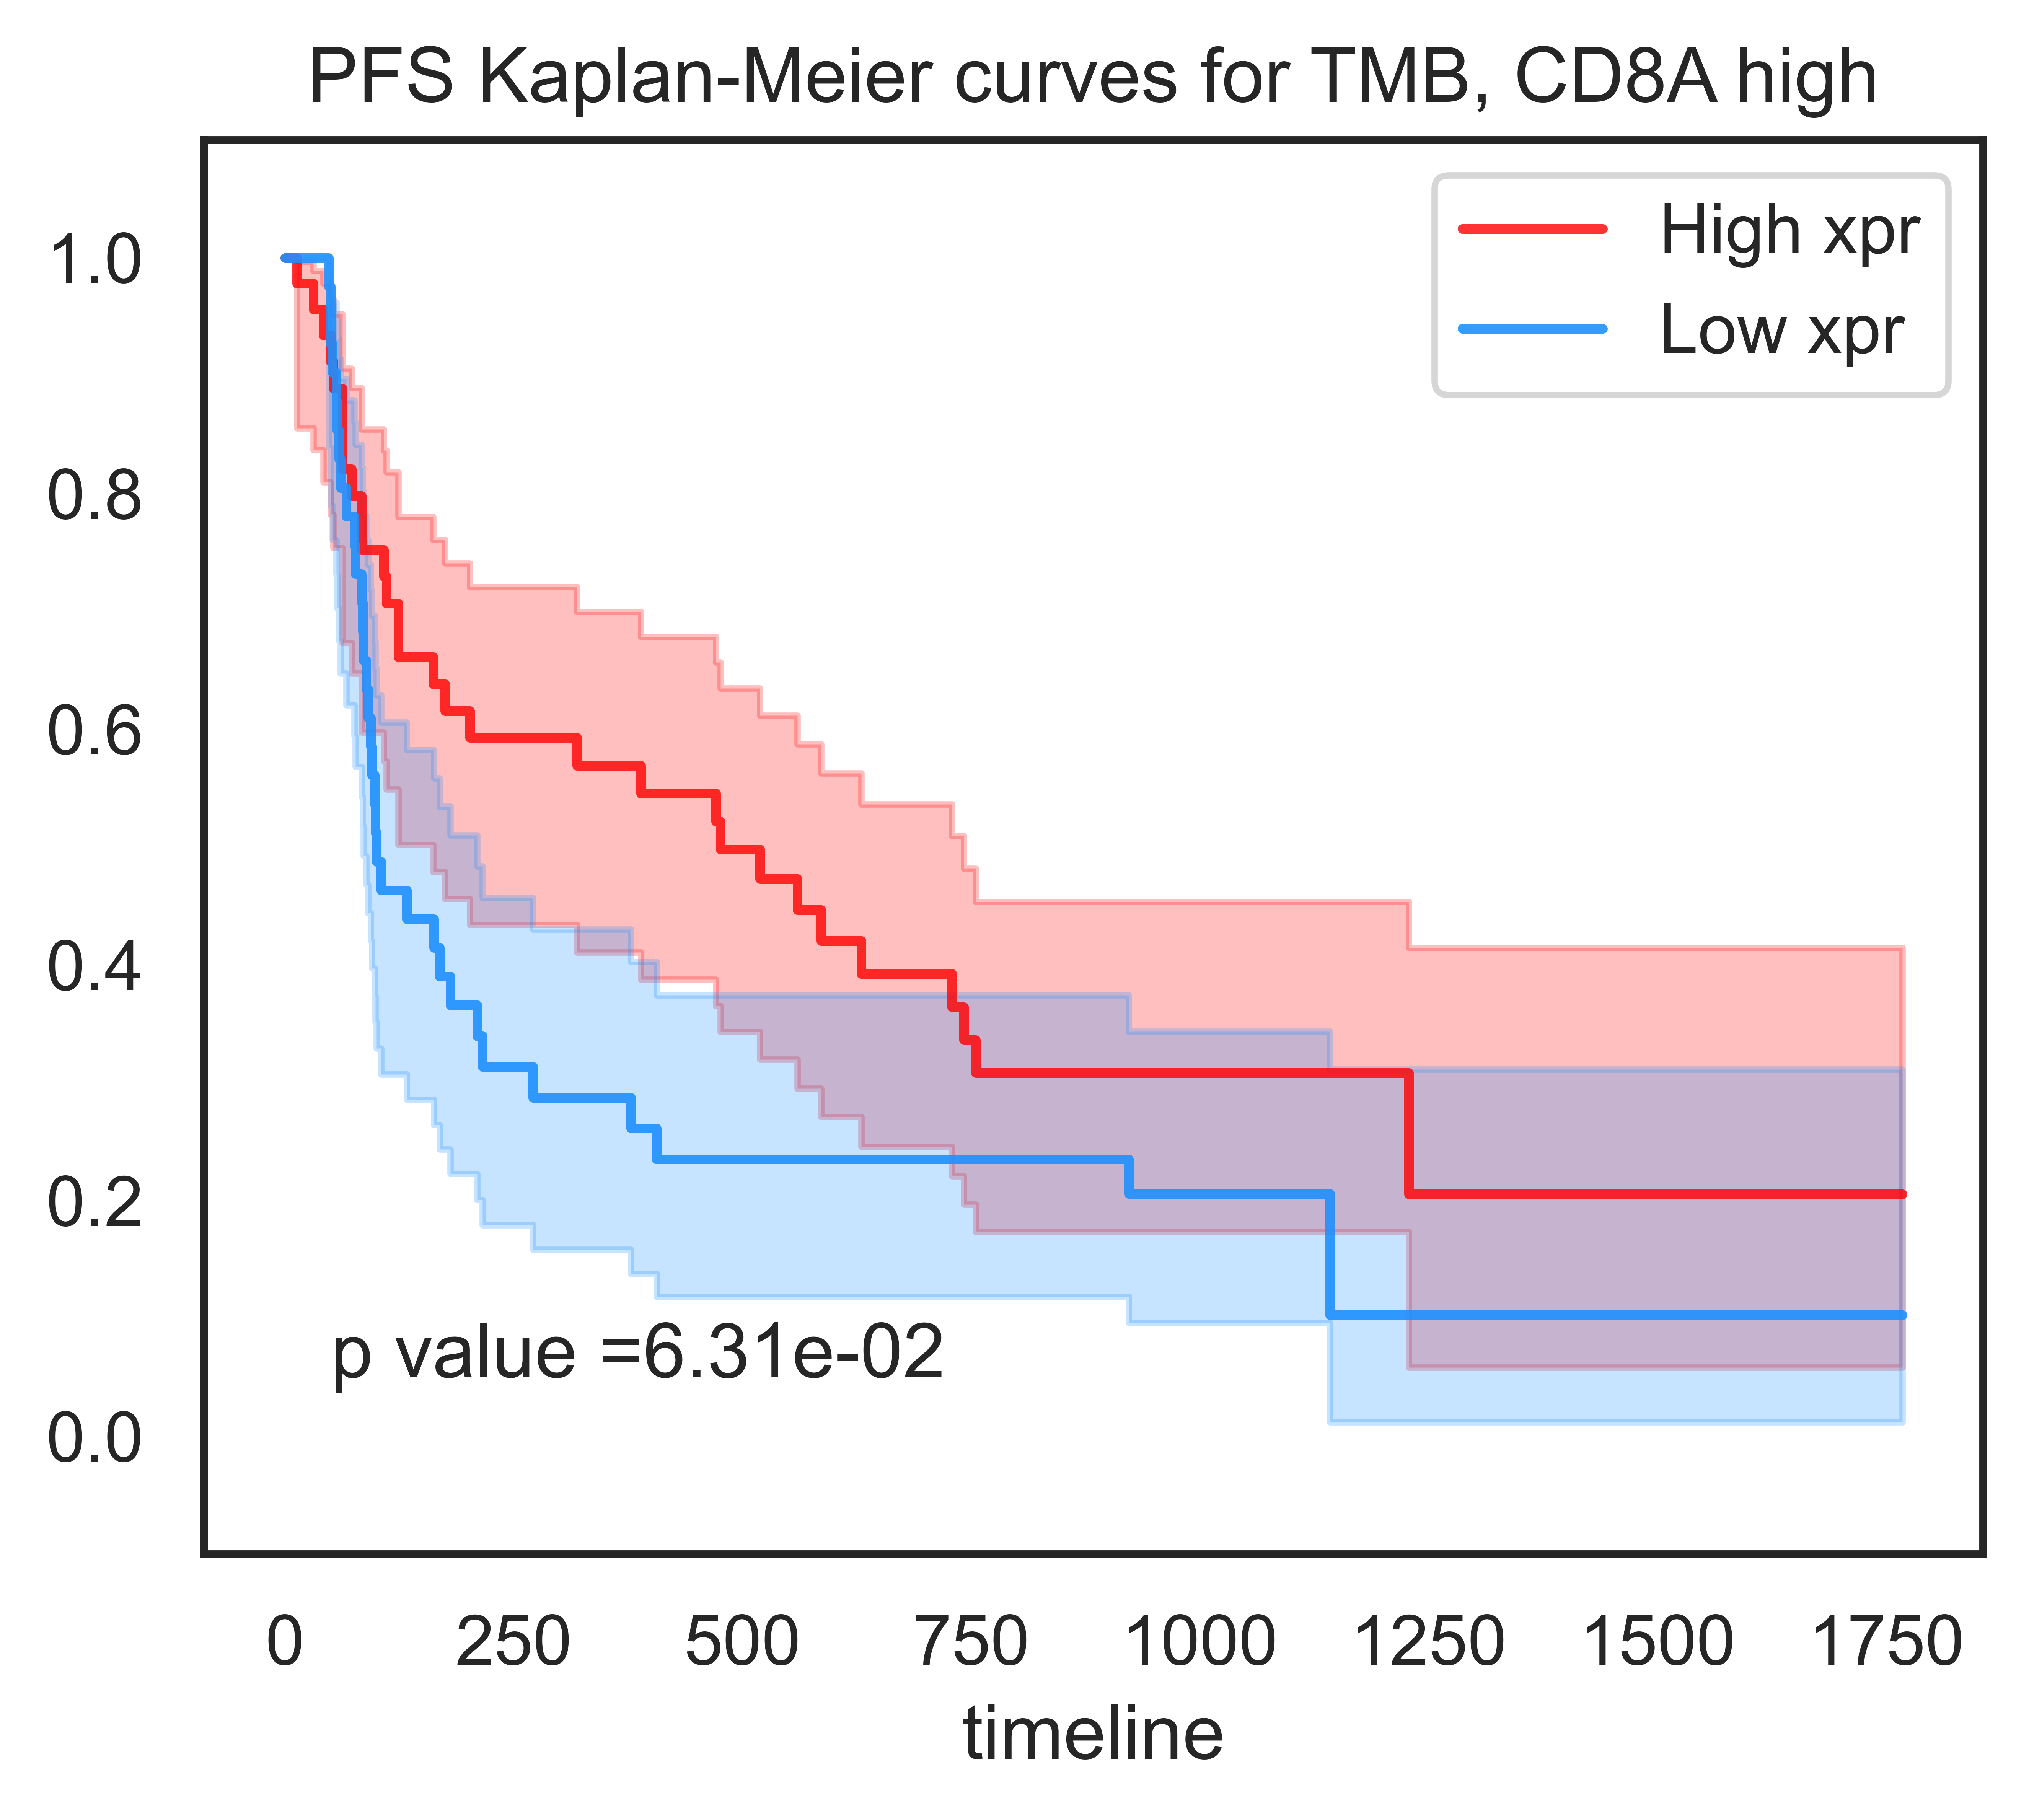

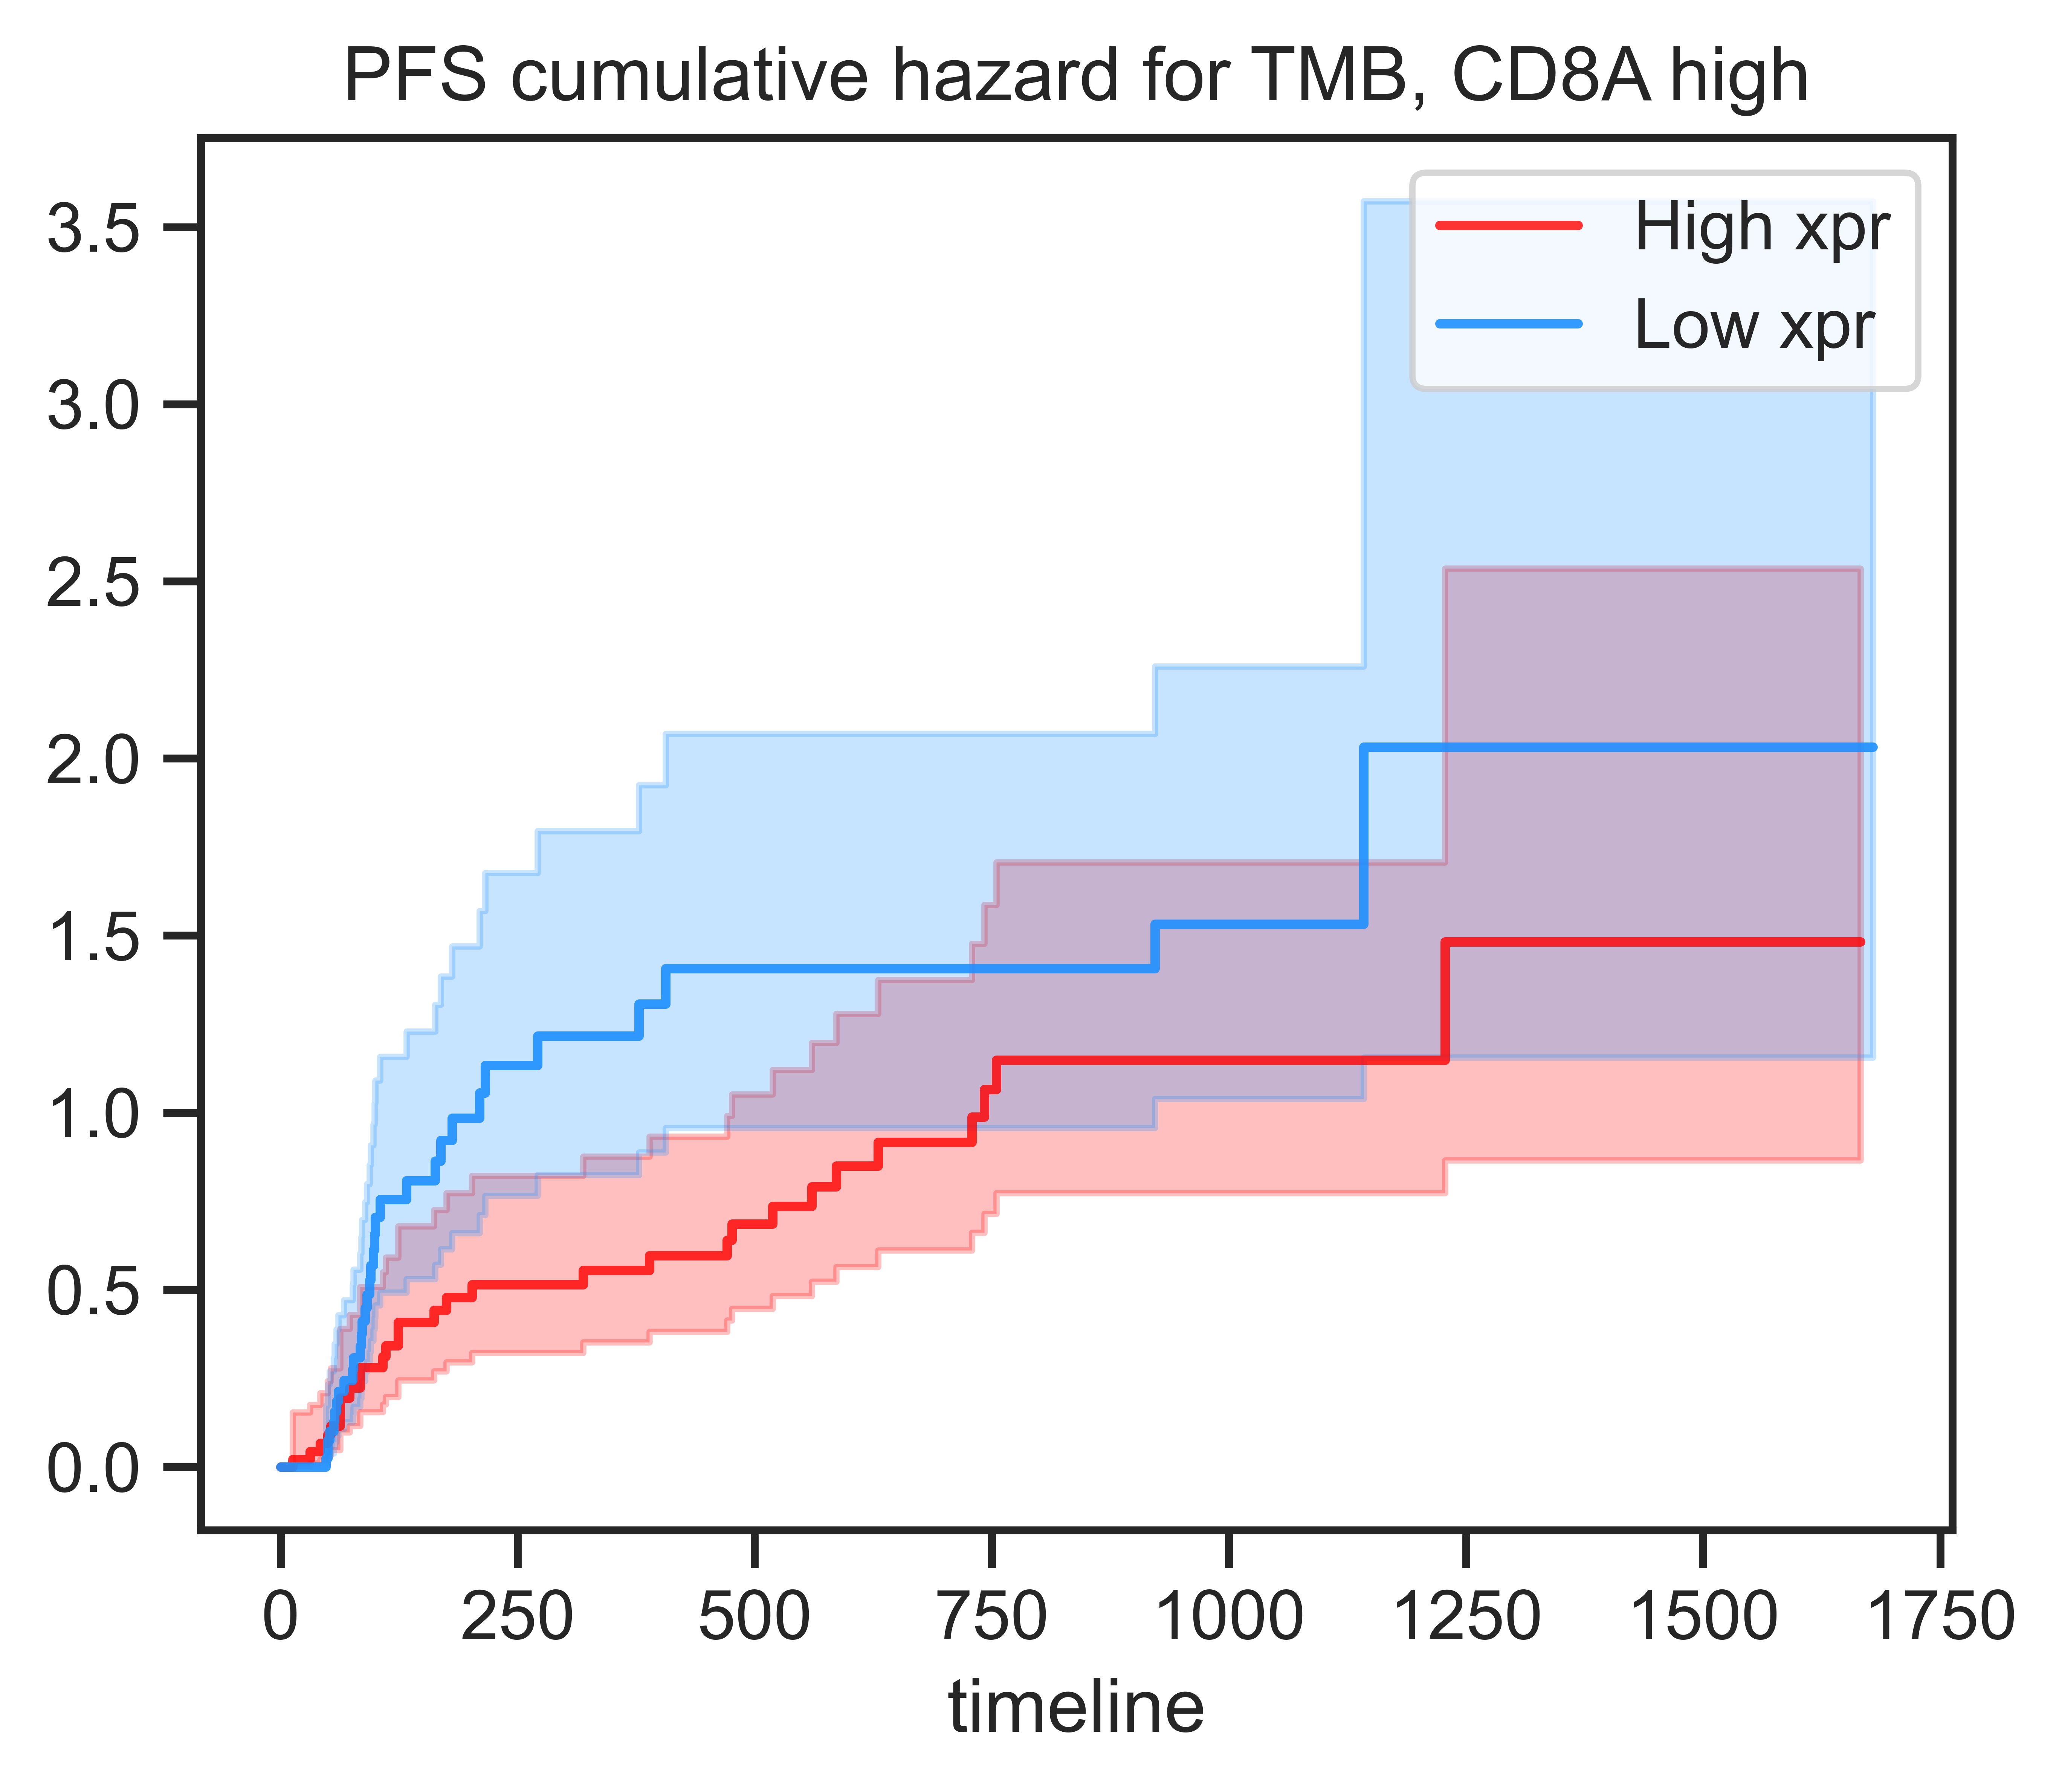

58 80 138
PD1 4.256197417678037 0.03910736875727874 7.49764178815963 0.42


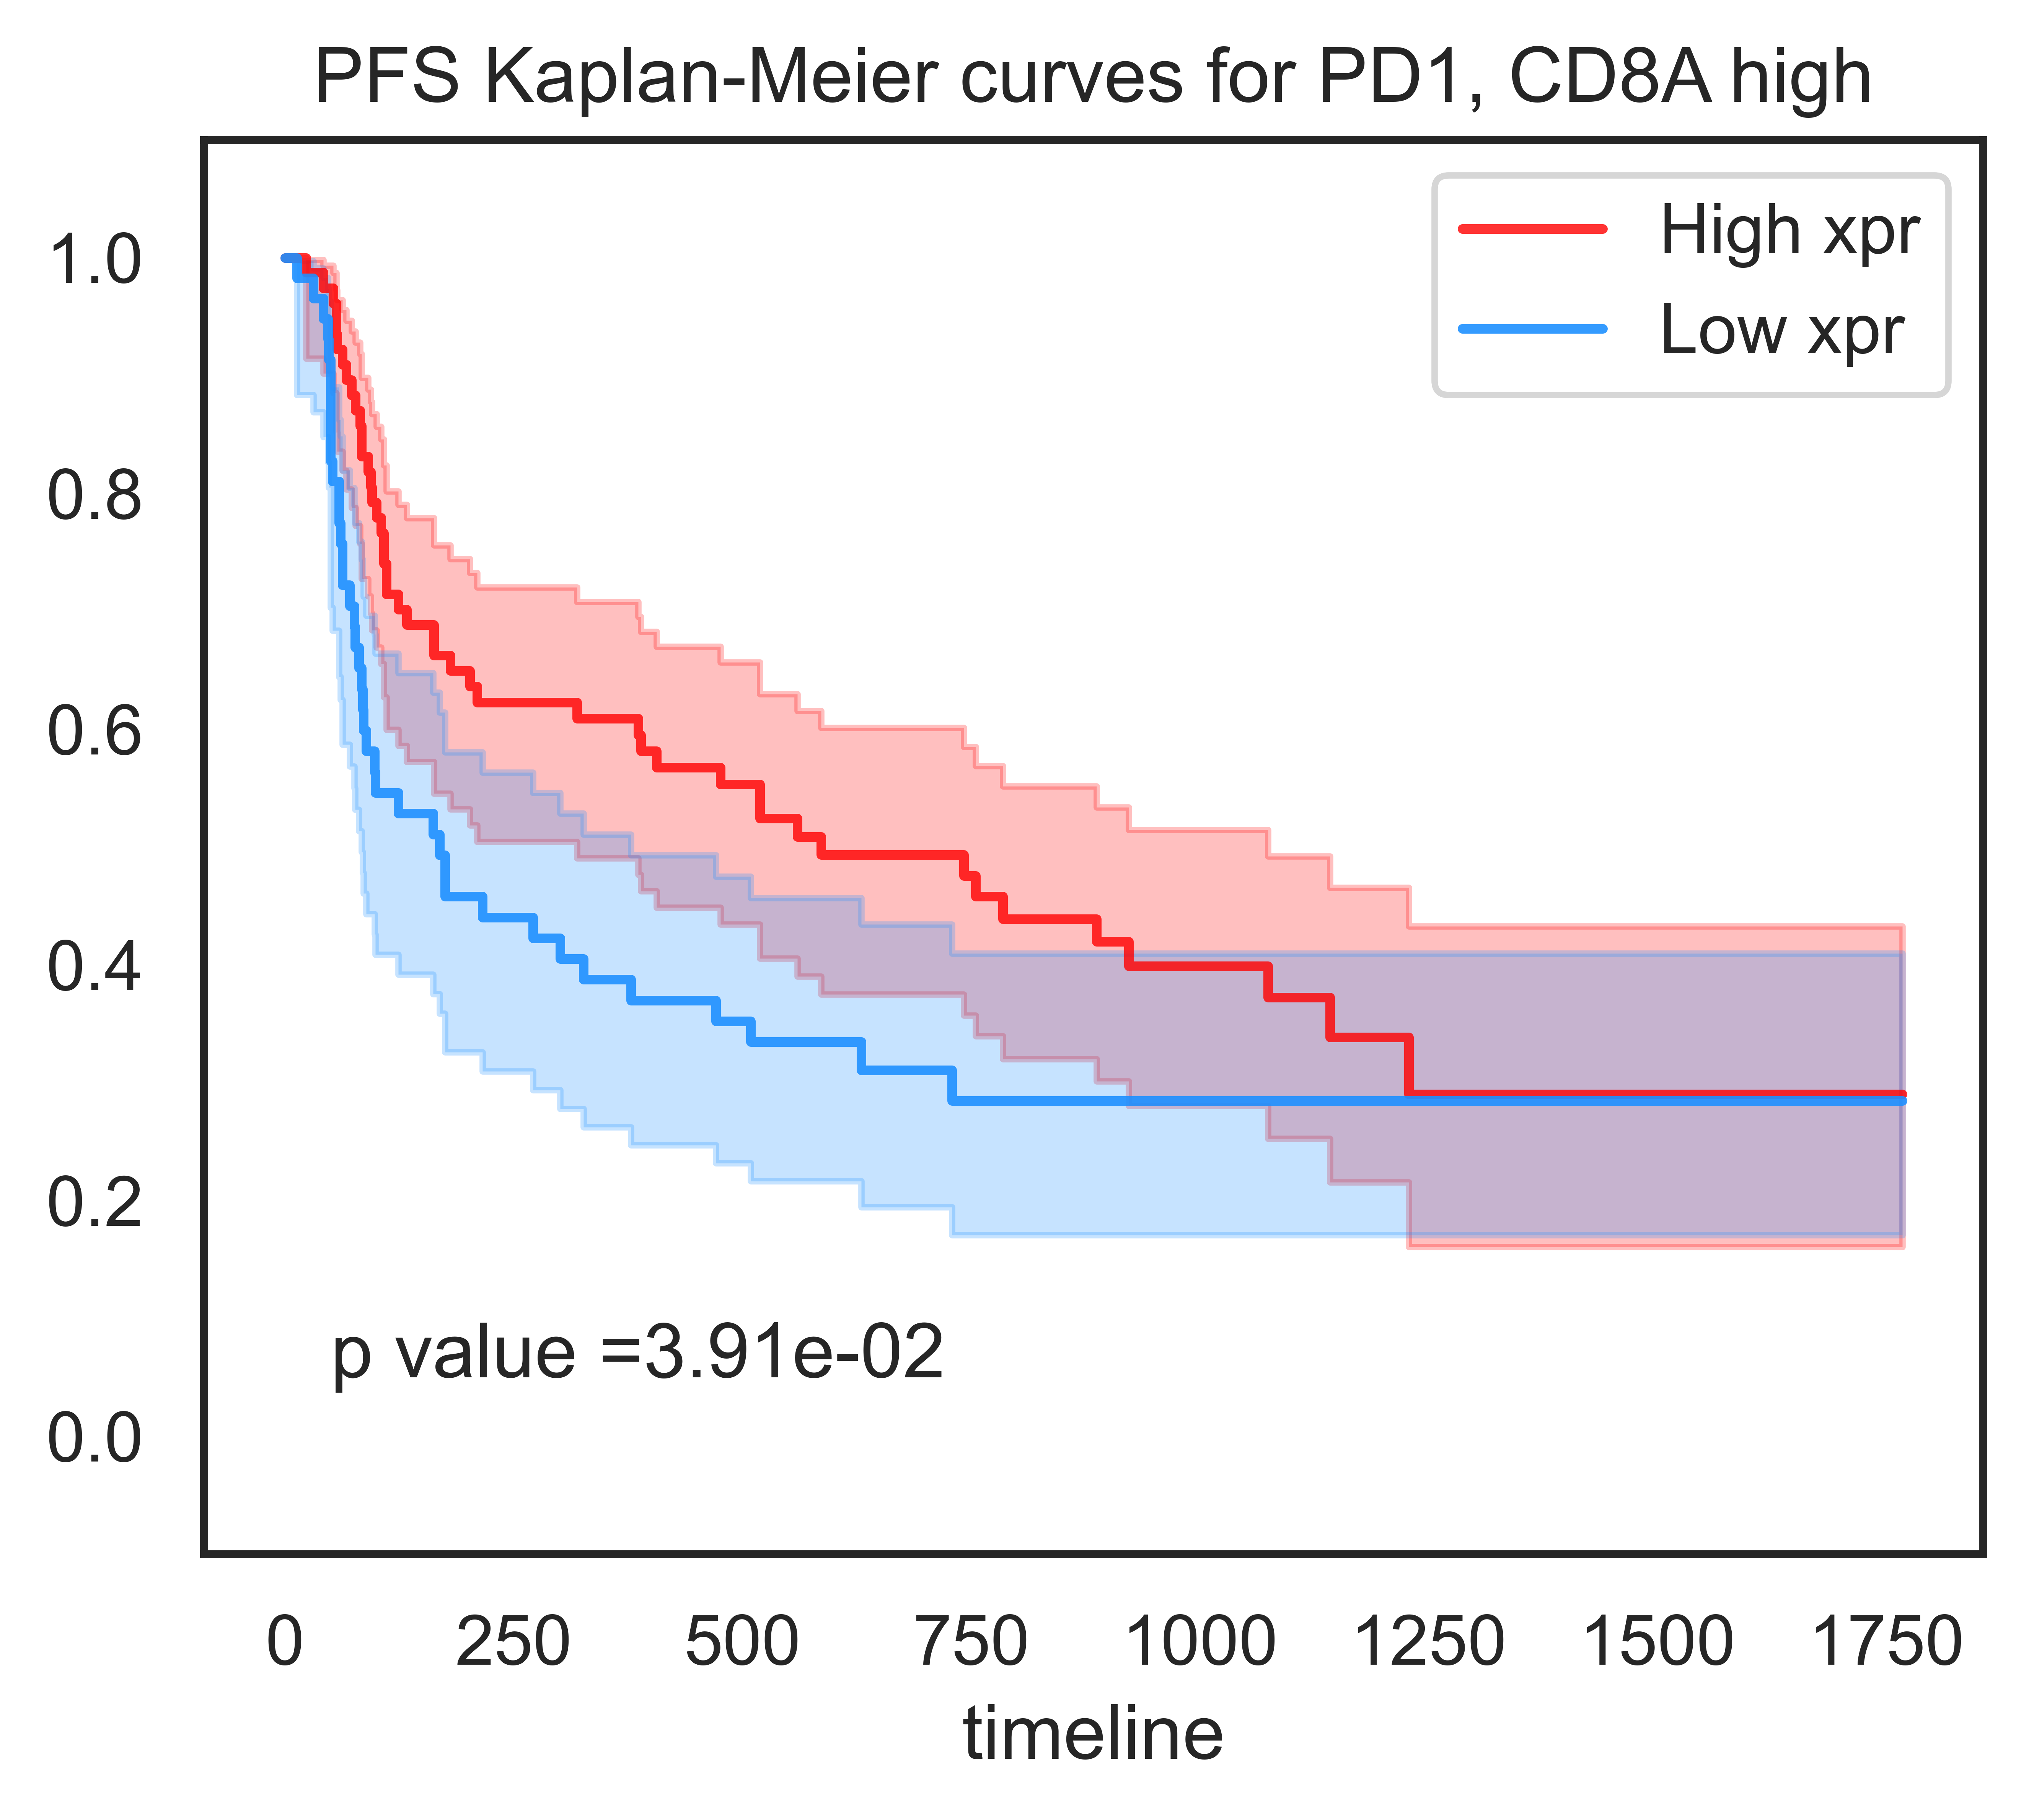

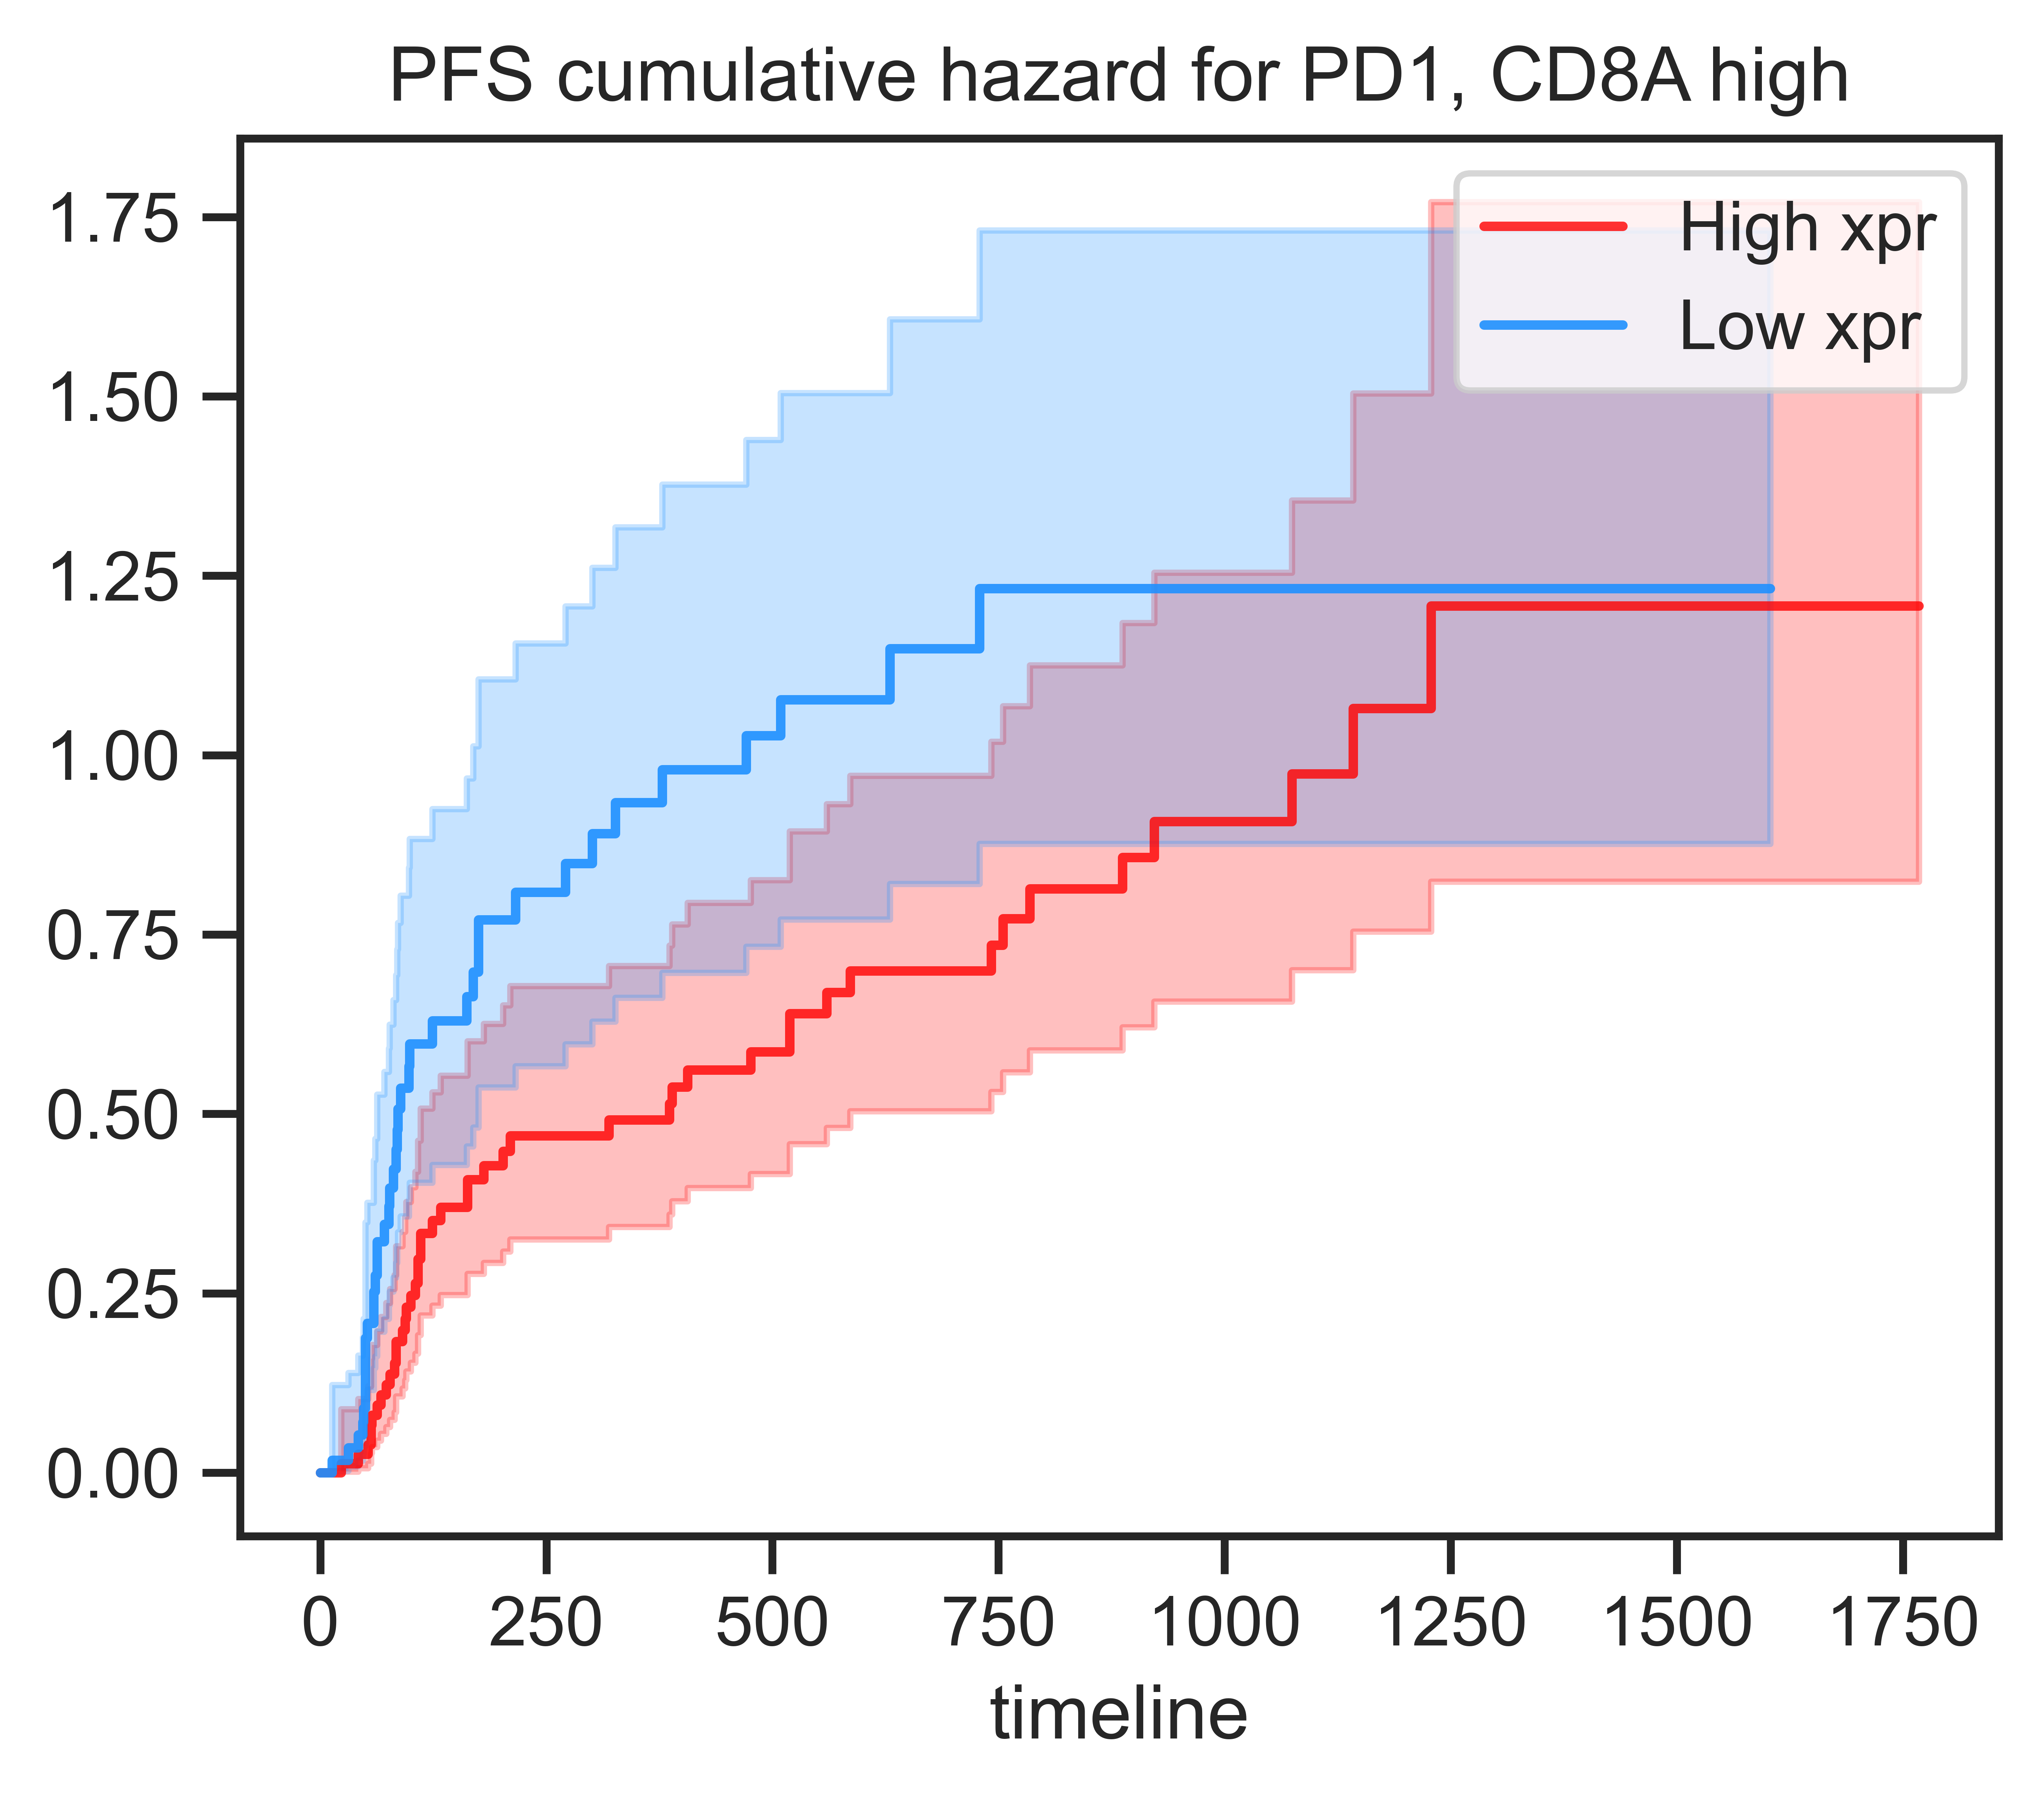

79 59 138
PDL1 11.298117456422887 0.0007758571844170855 18.459659551841142 0.57


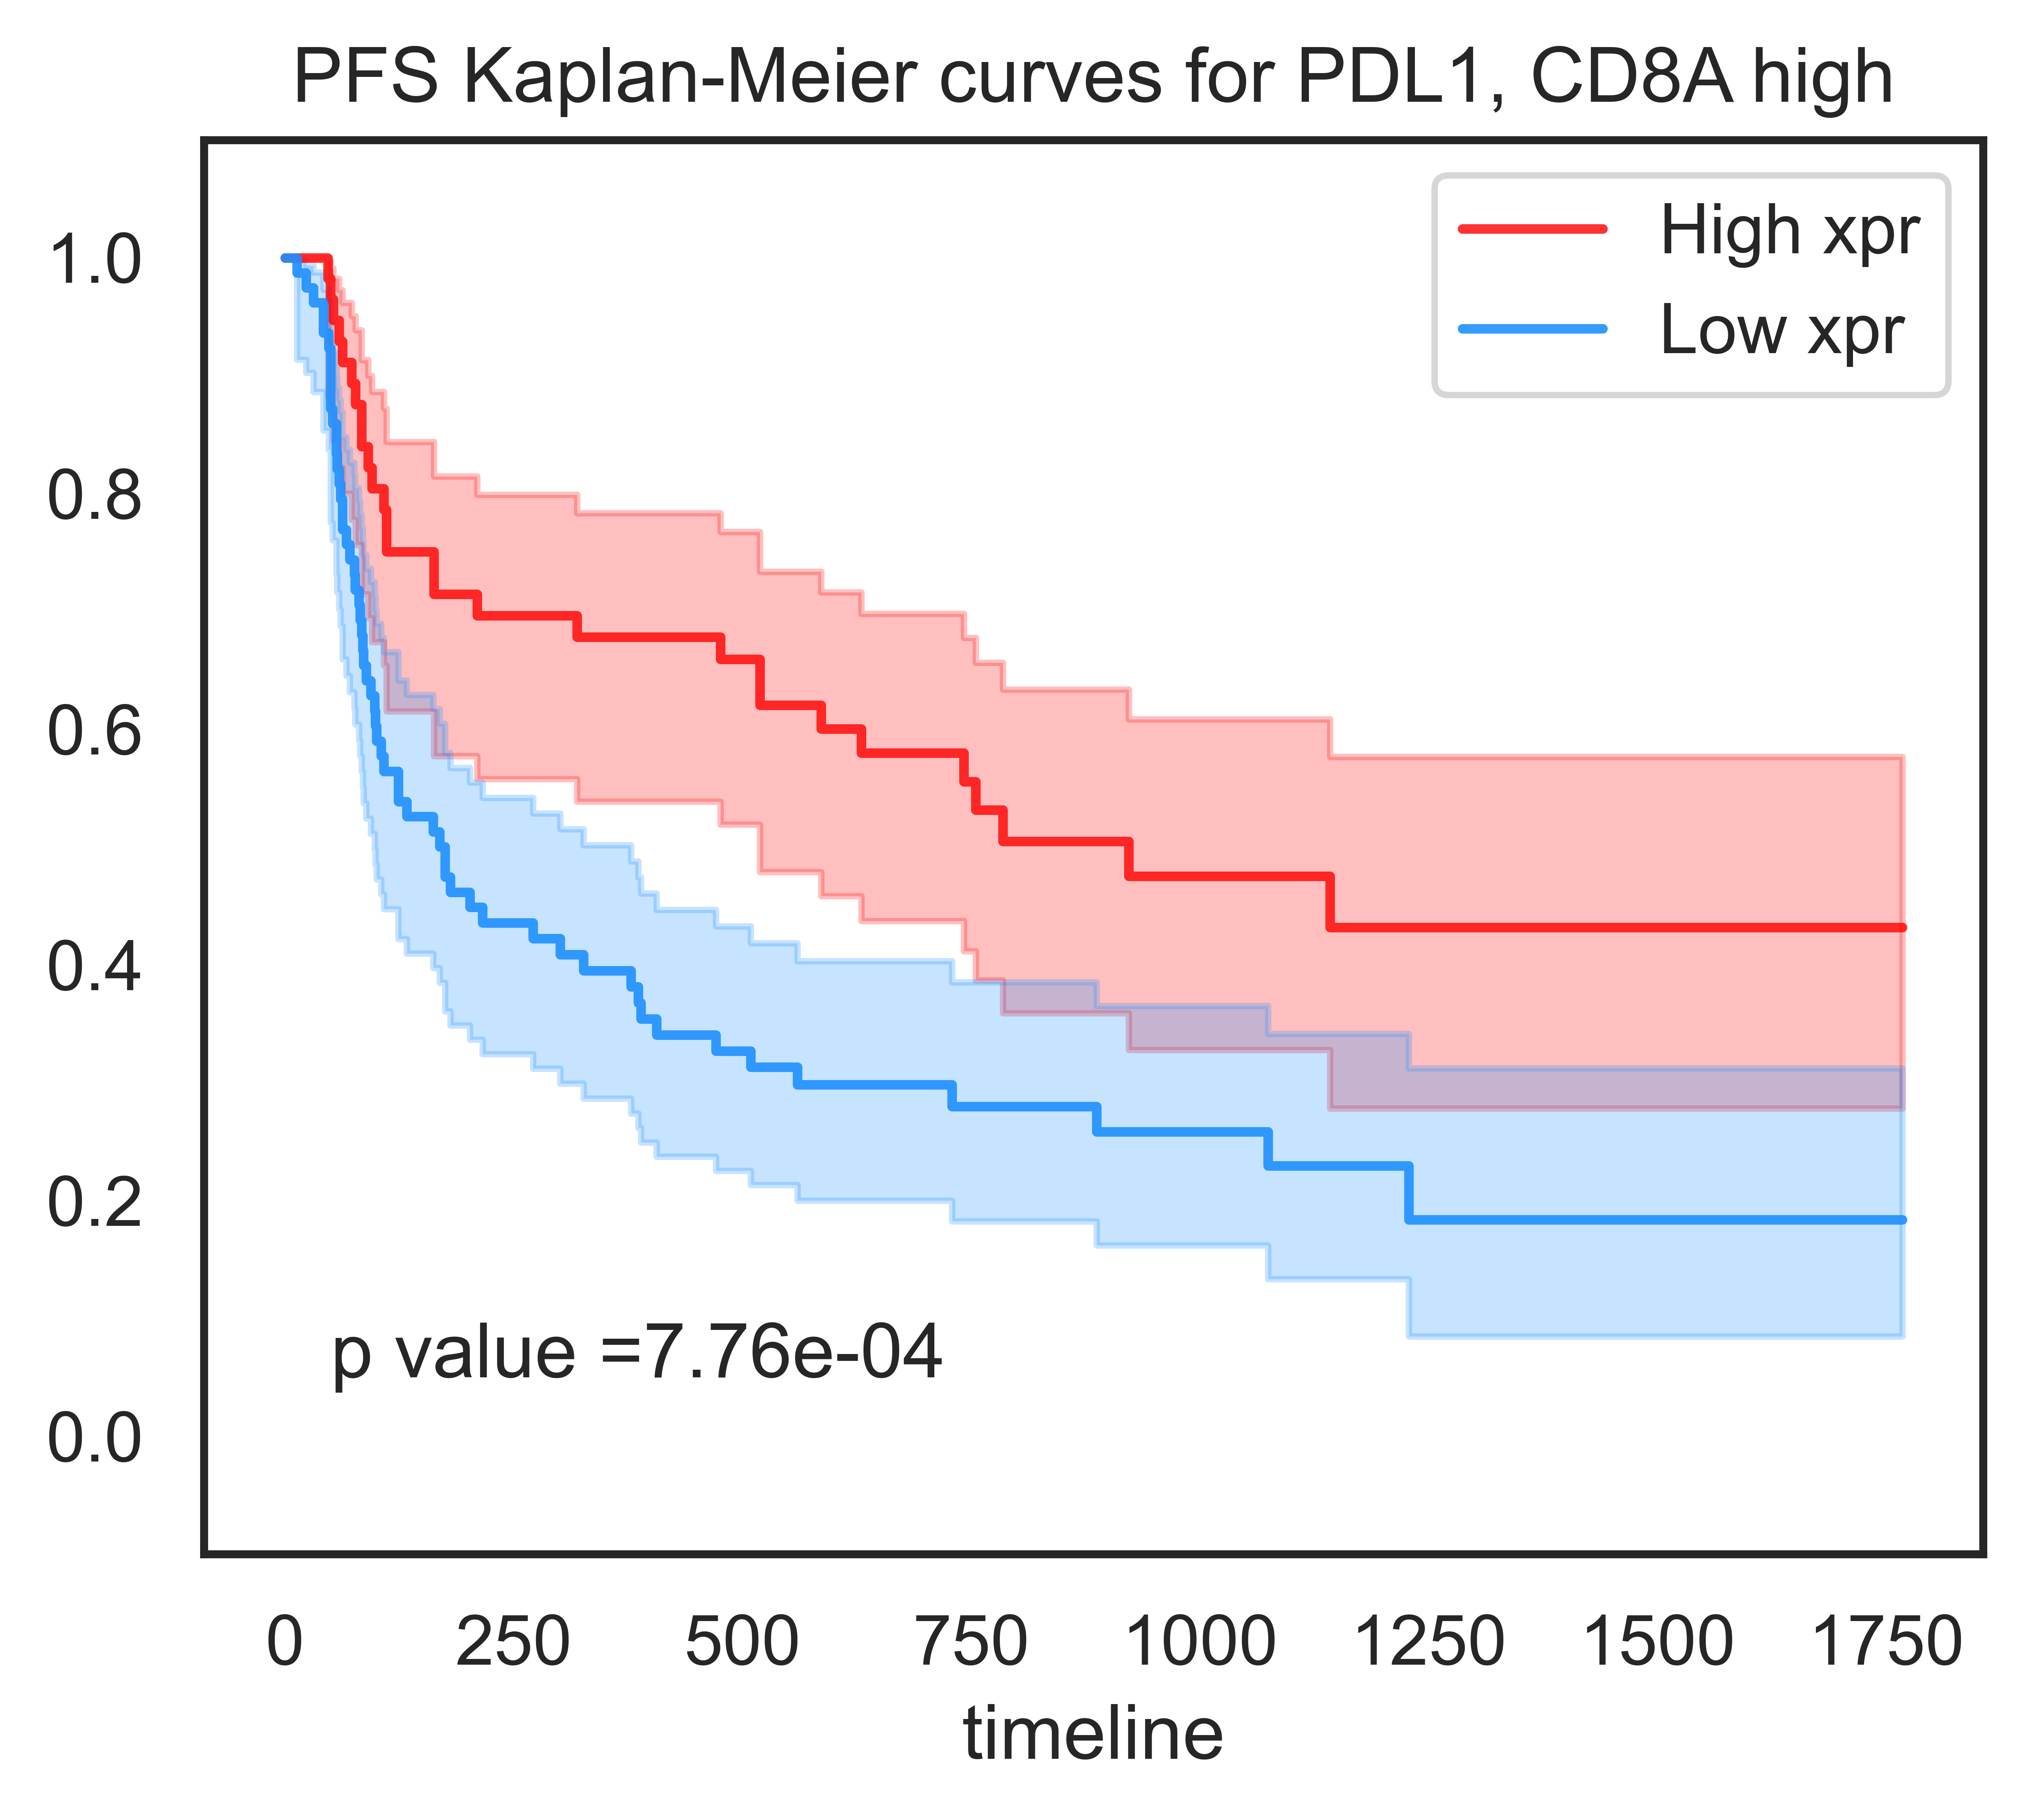

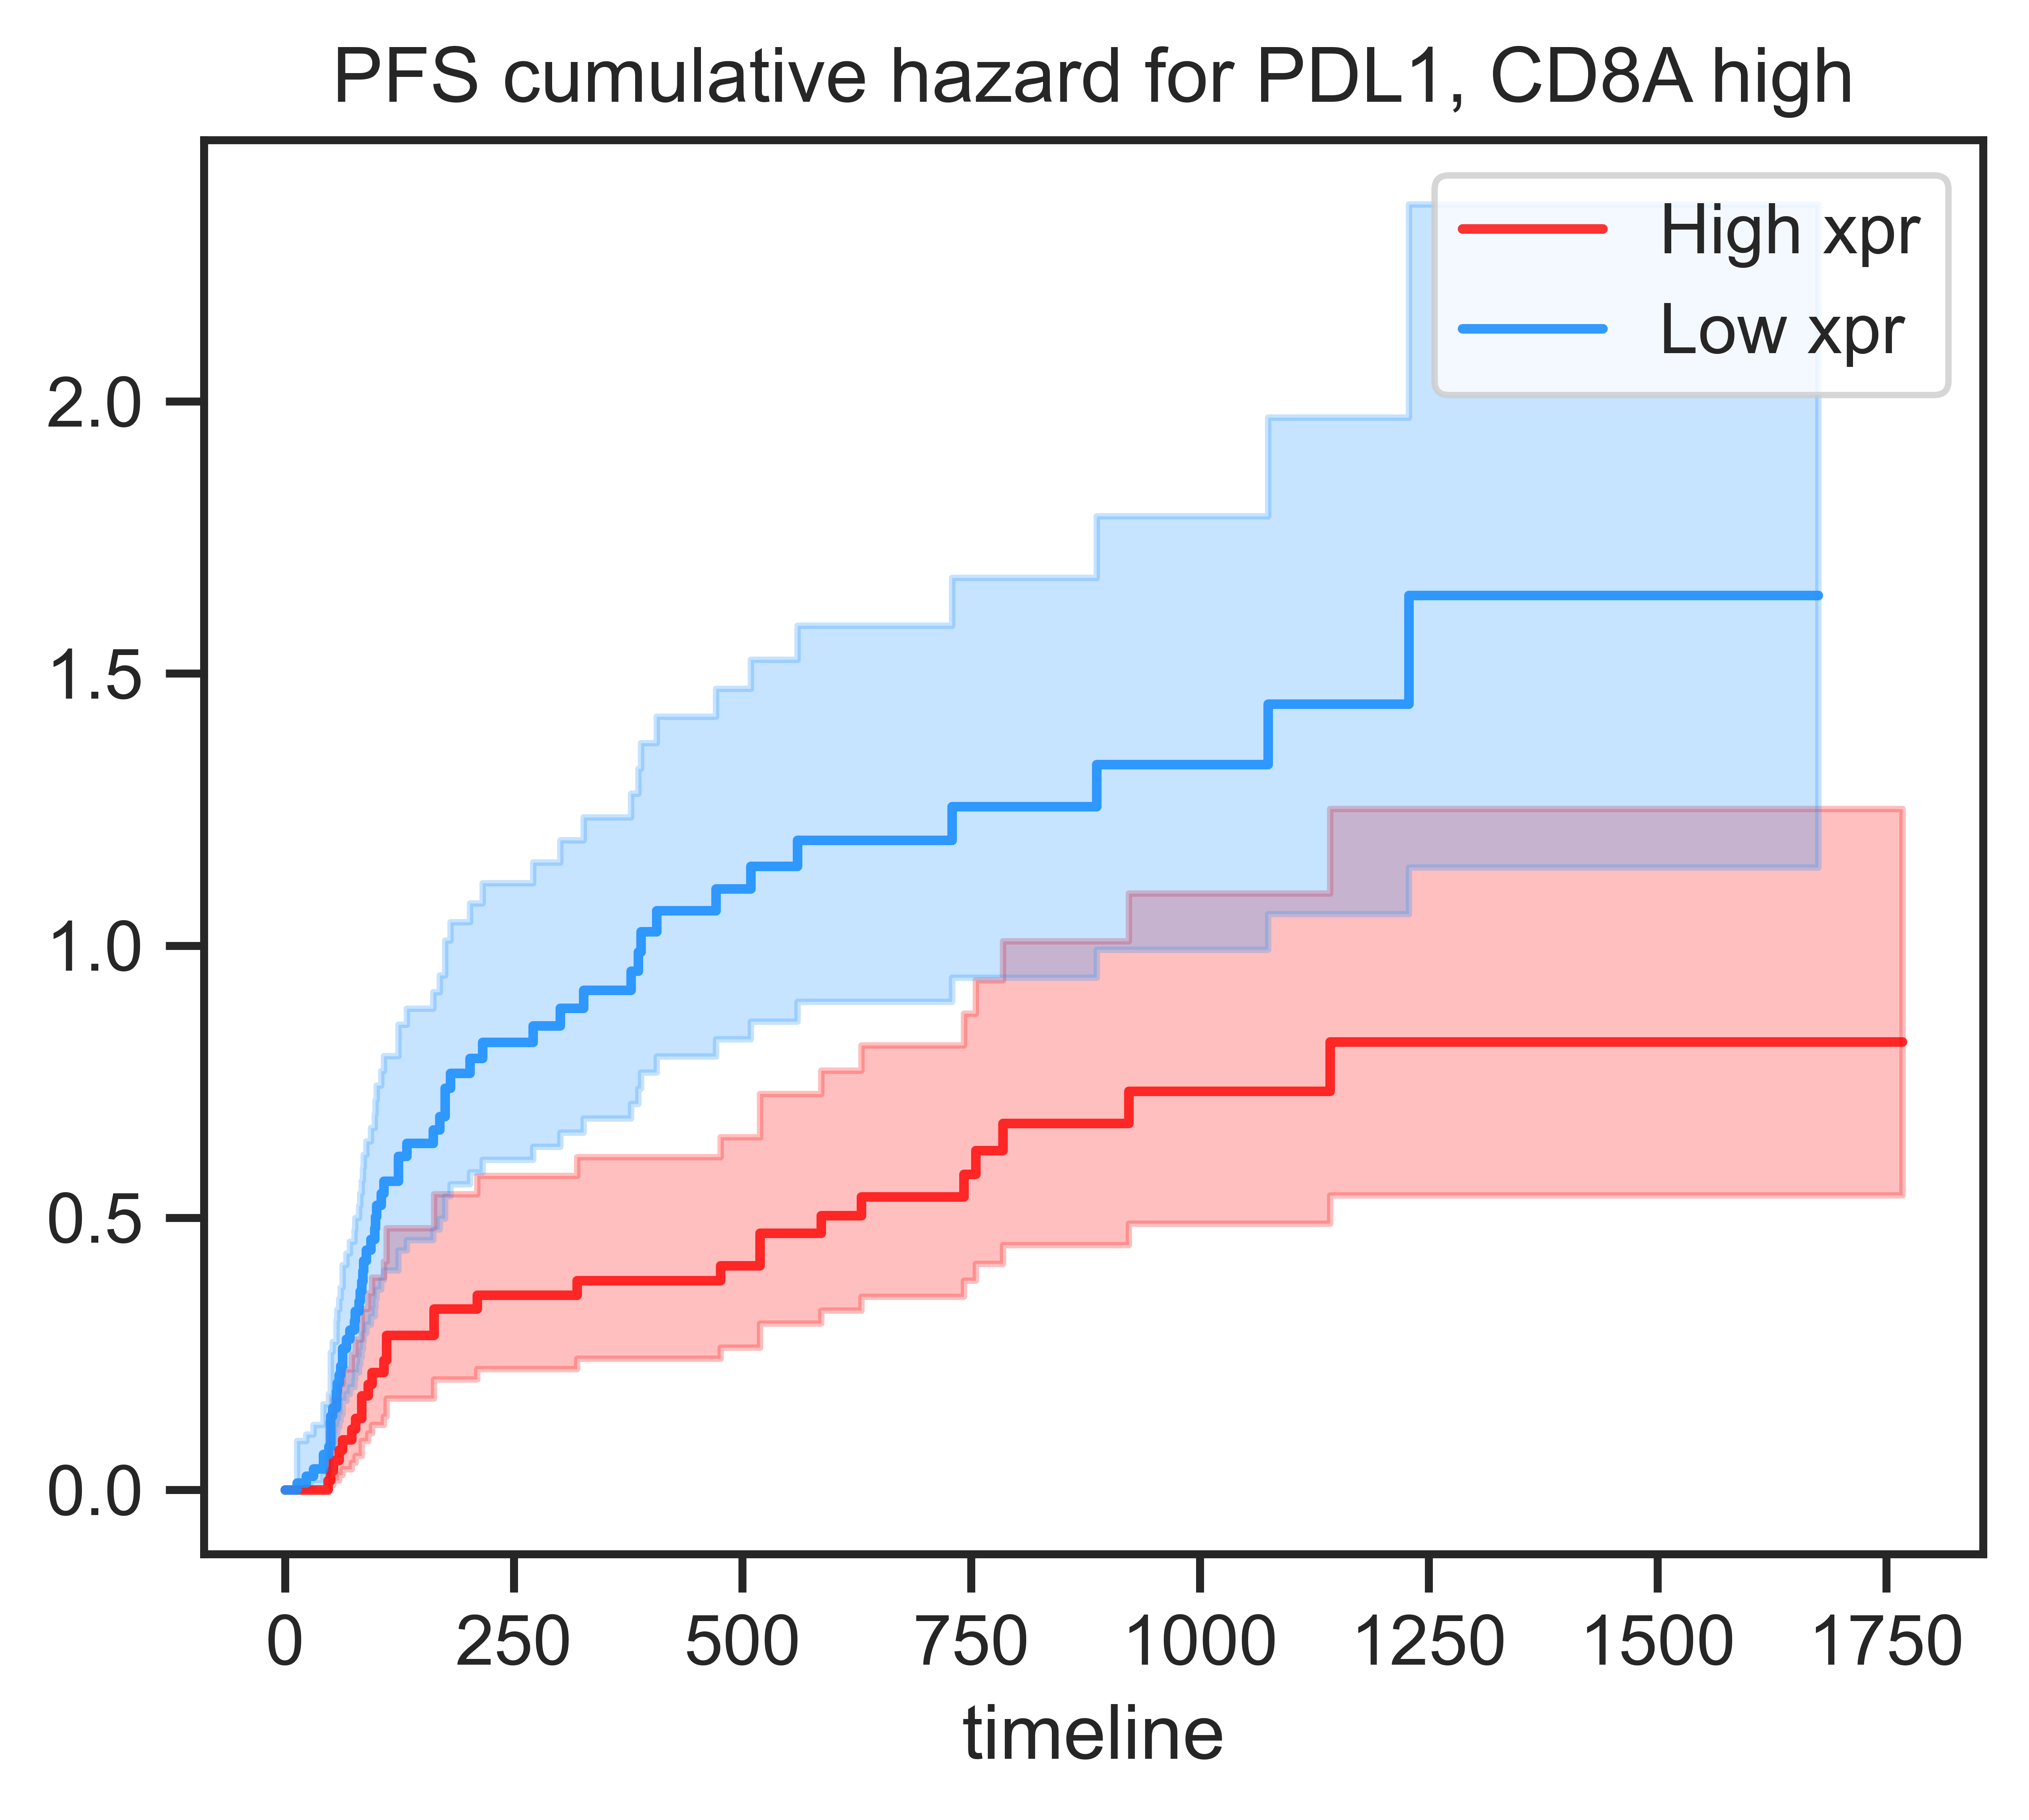

[36] [102] [138]
PRIME 15.170706476075948 9.821529644549685e-05 24.399055062526337 0.26


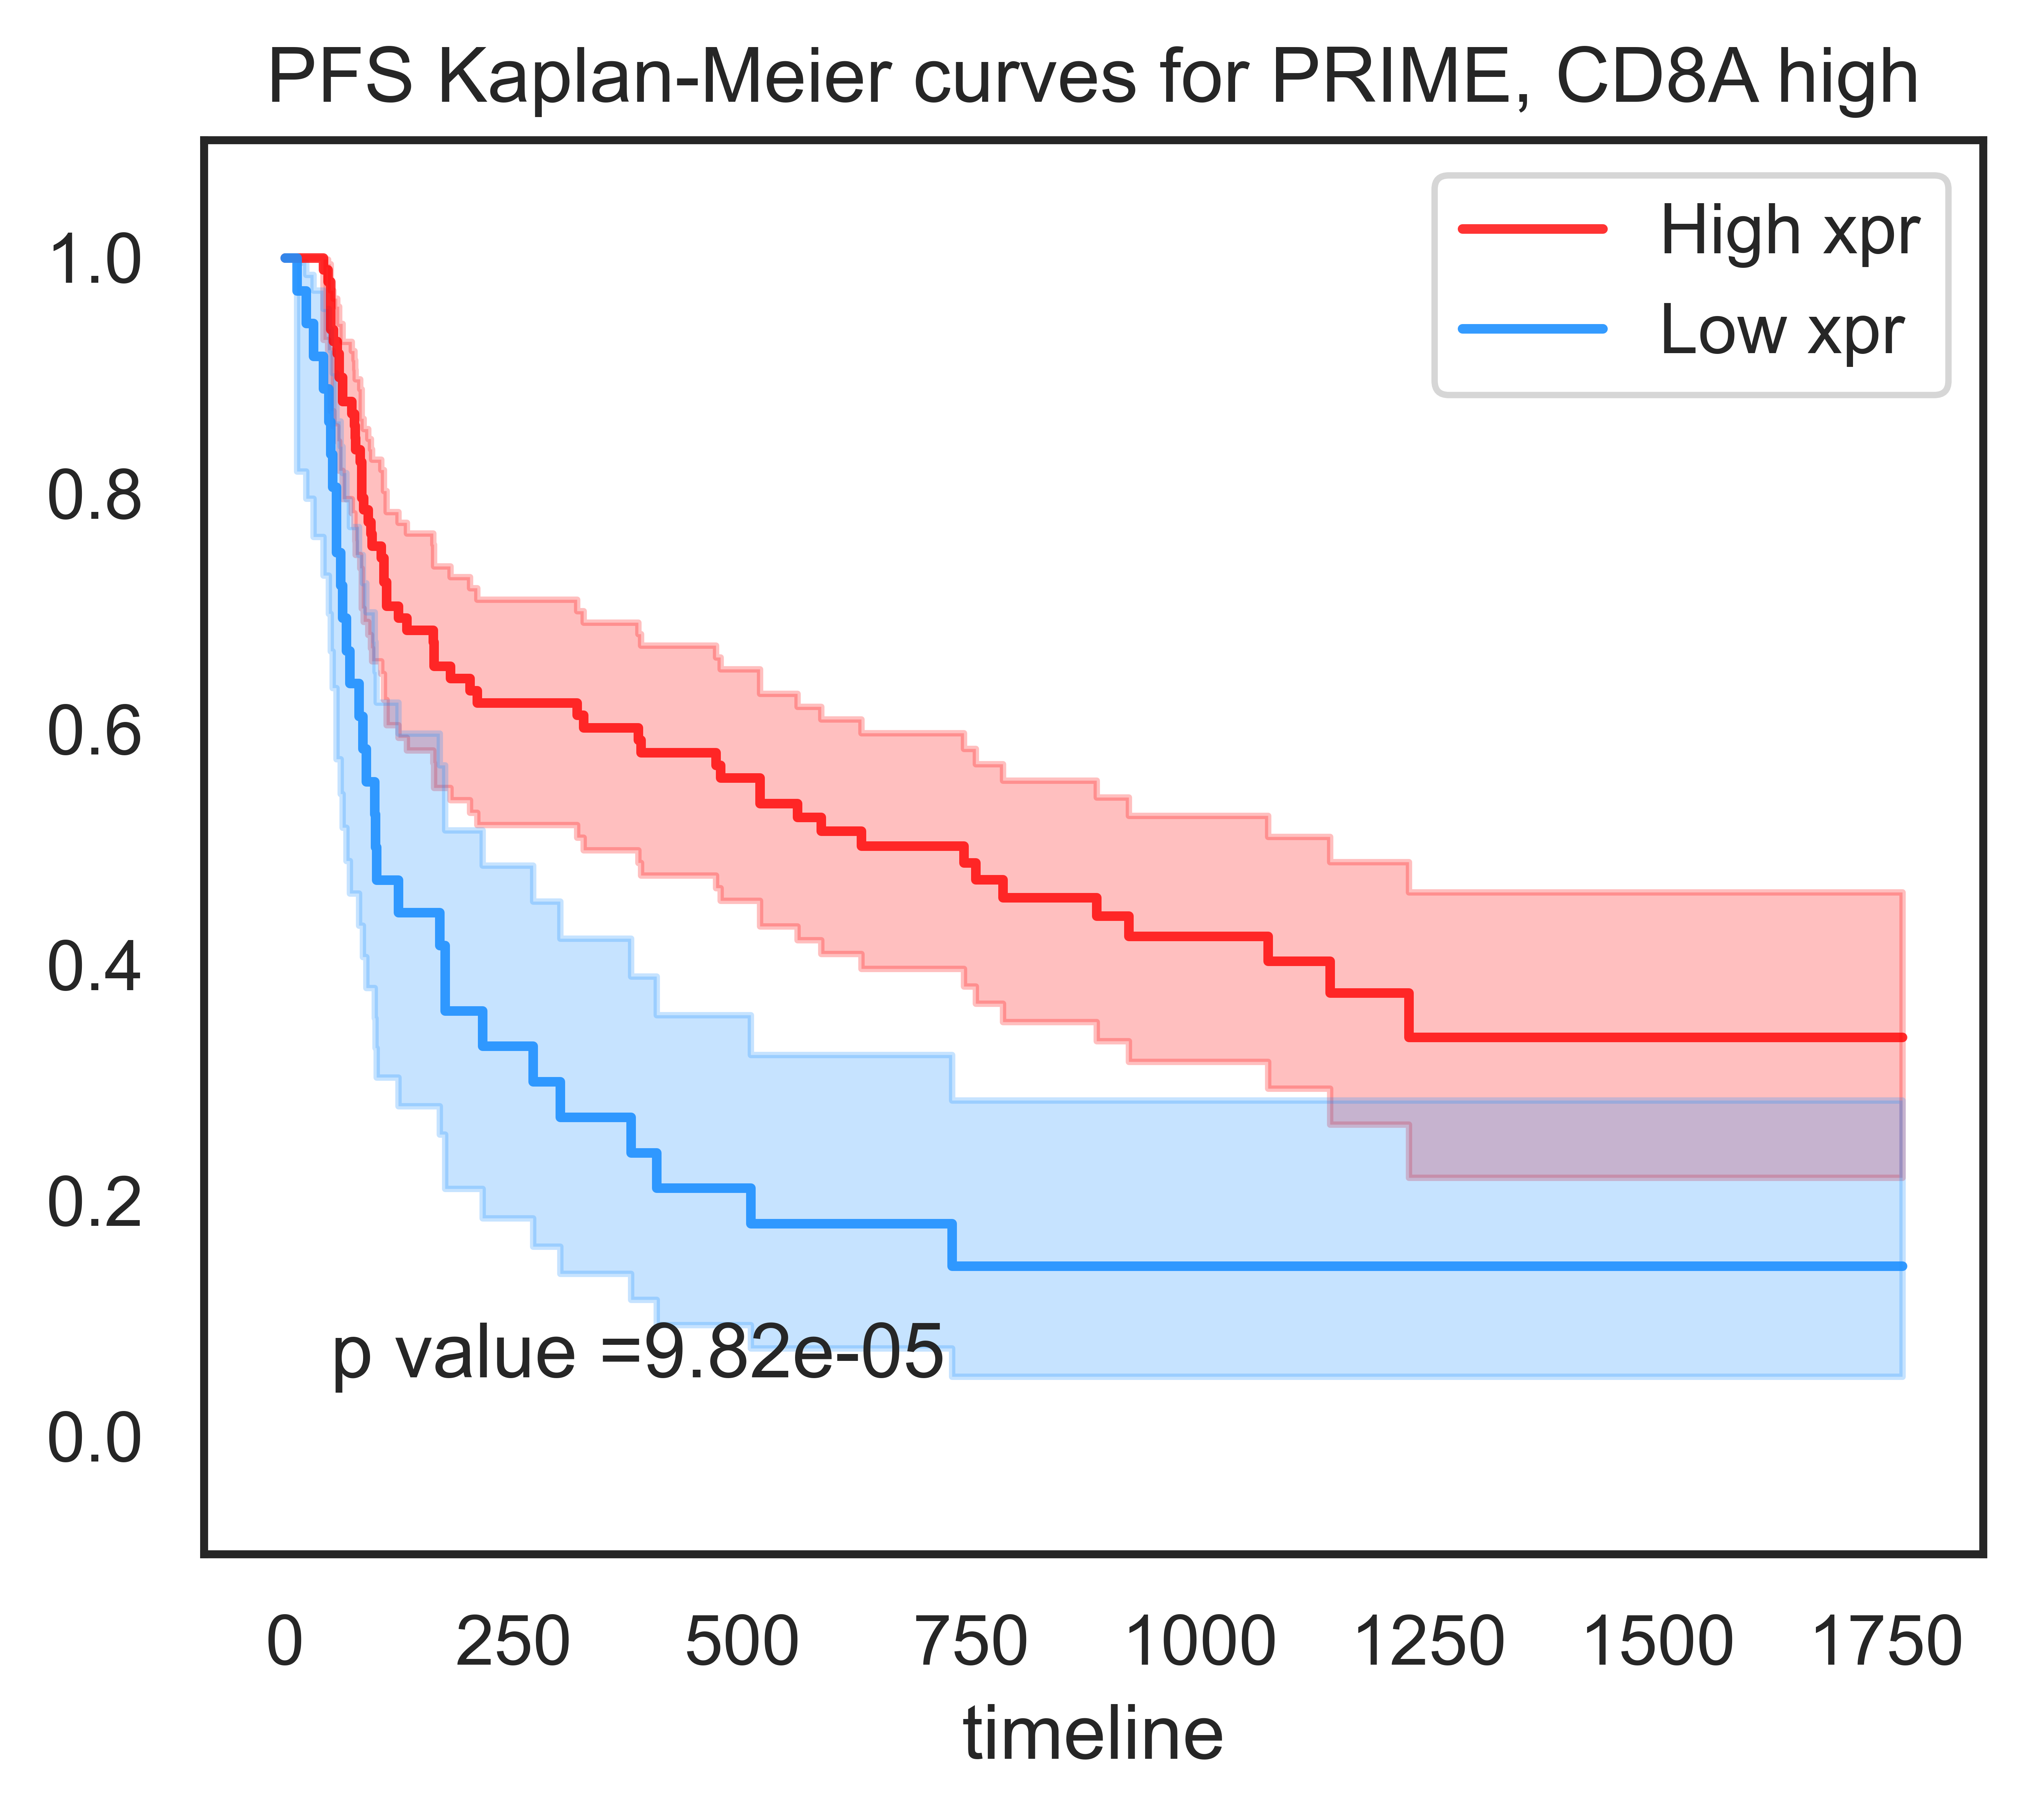

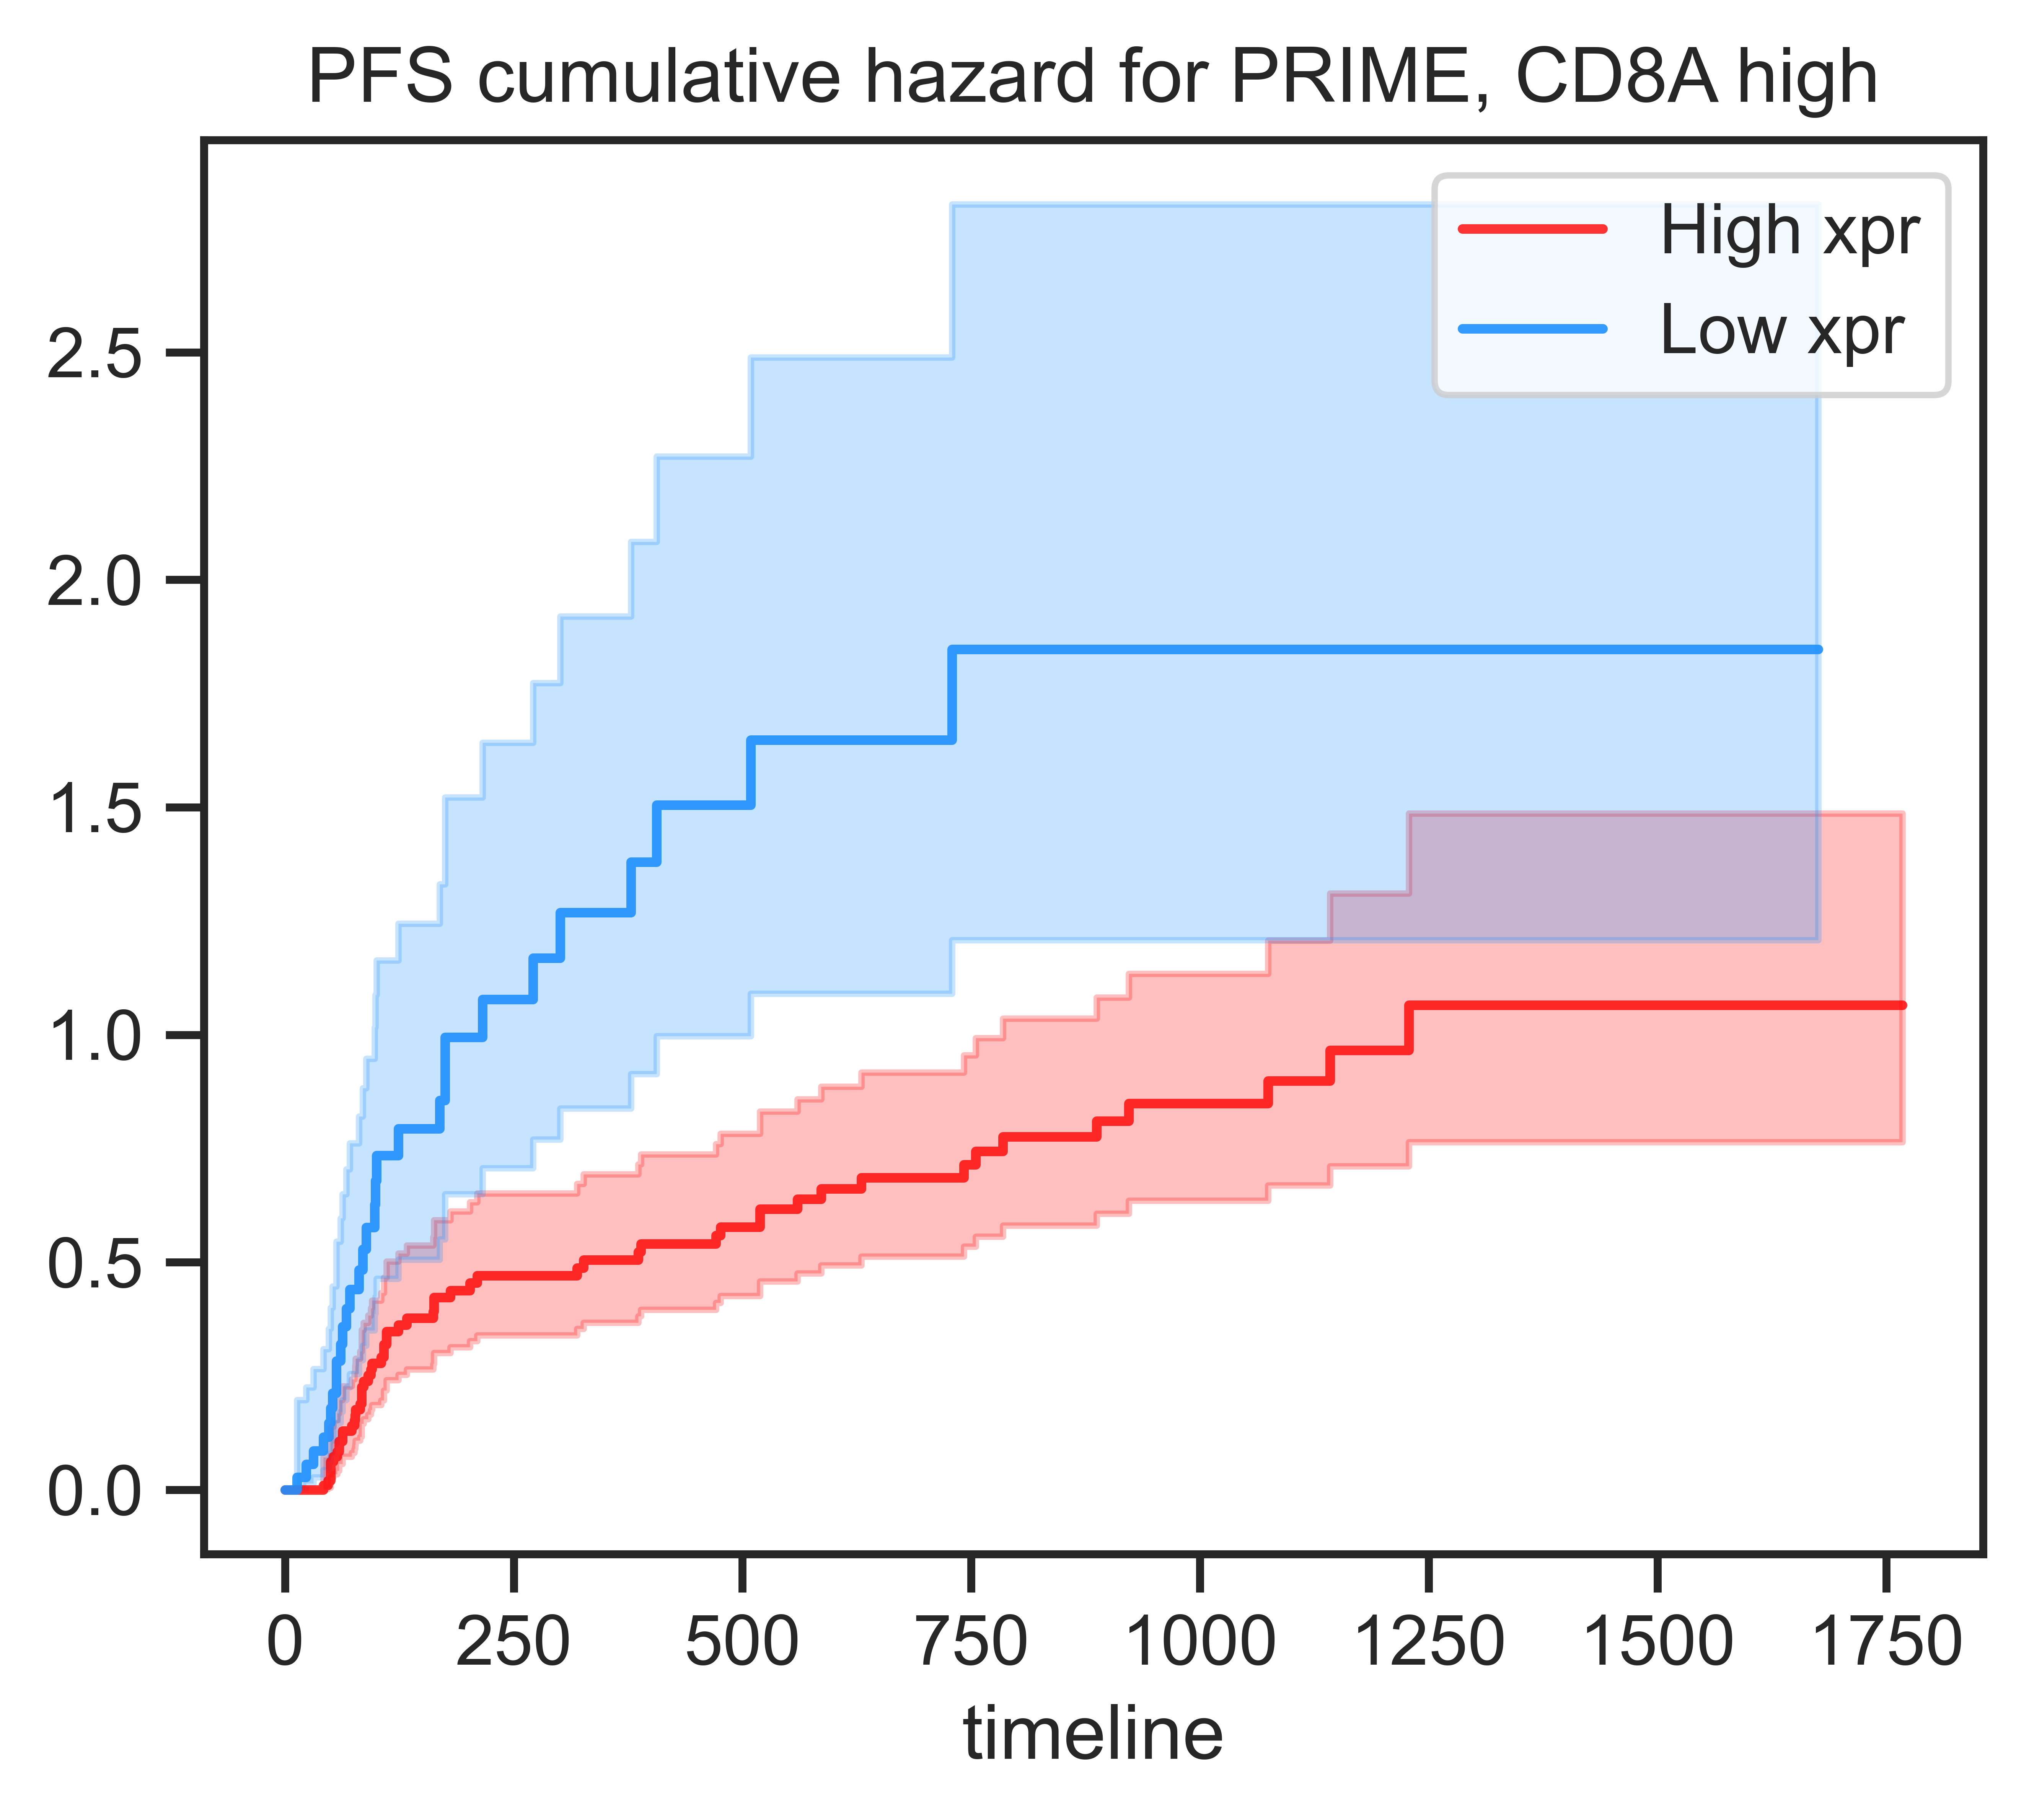

In [14]:
# CD8 above median
thresholds_opt_cd8hi = np.array([0.26, 0.75, 0.66, 0.47, 0.42, 0.57, 0.26])

model_ind = 0
stratify_by_CD8 = True

for model in Models:

    #pt_pfs: alive=0 , dead=1. Check that all patients with RECIST have pfs events and days data
    # pt_pfs = np.where((~pd.isna(os_pfs_df['PFS Status'].values))&(~pd.isna(os_pfs_df['PFS Days'].values))&((batch_inds==3)|(batch_inds>4)))[0]
    pt_pfs = np.where((~pd.isna(os_pfs_df['PFS Status'].values))&(~pd.isna(os_pfs_df['PFS Days'].values)))[0]

    if stratify_by_CD8:
        
        quantiles = np.quantile(log2tpm_bc.loc['CD8A'],[0.25,0.5,0.75])
        pt_strat = np.where(log2tpm_bc.loc['CD8A']>quantiles[1])[0]
    
        pt_pfs = np.intersect1d(pt_pfs, pt_strat)
    
    pfs_days_df =  os_pfs_df.iloc[pt_pfs]['PFS Days']
    pfs_event_df = os_pfs_df.iloc[pt_pfs]['PFS Status']
    
    tpm_data = tpm_bc.iloc[:,pt_pfs] 
    log2tpm_data = log2tpm_bc.iloc[:,pt_pfs] 
    
    responders_data = responders.iloc[pt_pfs]
    
    irs_data = irs.iloc[pt_pfs]
    batch_ind_data = batch_inds[pt_pfs]

    if model == 'CTL':

        model_data =  np.log2(1+compute_ctl_score(tpm_data)).values


    if model=='TMB':

        pt_pfs = np.intersect1d(pt_pfs,tmb_measured)
        model_data = TMB_aux[pt_pfs]

    if model == 'IMPRES':

        model_data =  -impres_scores[pt_pfs]

    if model == 'TIDE':

        tide_results = tide_res.iloc[pt_pfs,:] 
        tide_df = pd.DataFrame(data = tide_results.values, index= log2tpm_data.keys(), columns= tide_res.columns )
        tide_scores = tide_df['TIDE'].values
        
        model_data = -tide_scores

    if (model == 'PD1'):

        model_data =  log2tpm_data.loc['PDCD1'].values

    if (model == 'PDL1'):

        model_data =  log2tpm_data.loc['CD274'].values
    
    if model == 'PRIME':

        weights = gsp_psp_stats['weights'].values
        data = tpm_data
        model_data = np.matmul((weights.reshape(-1,1).T),np.log2(1+data.loc[gsp_psp_stats.index.values]).values.astype(float)).T

    
    model_data = (model_data - np.mean(model_data))/np.std(model_data,axis=0)
    
    timeline_all = np.sort(np.append(0.,pfs_days_df))
    pt_all = tpm_data.keys().values

    if stratify_by_CD8:
        
        threshold = thresholds_opt_cd8hi[model_ind]
    
    else:

        threshold = thresholds_opt[model_ind]
        
    # print(threshold)
    # print(model_data)
    
    KMstats_lowhi_xpr =  pd.DataFrame(index=['Log rank chi^2','Log rank p','log-rank test score'], columns = ['Feature'])
    
    #Genes with low beta
    lower_half_bin = (model_data<np.quantile(model_data,[threshold])[0])
    #Genes with high beta
    upper_half_bin = (model_data>=np.quantile(model_data,[threshold])[0])

    
    lower_half_pts = pt_all[np.where(lower_half_bin)[0]]
    upper_half_pts = pt_all[np.where(upper_half_bin)[0]]
    print(sum(lower_half_bin),sum(upper_half_bin), sum(lower_half_bin+upper_half_bin))

    
    lower_half_days = np.array([])
    lower_half_events = np.array([])
    
    upper_half_days = np.array([])
    upper_half_events = np.array([])
    
    if len(lower_half_pts)>0:
       
        for pt in lower_half_pts:
    
            lower_half_days = np.append(lower_half_days, pfs_days_df.loc[pt])
            lower_half_events =  np.append(lower_half_events, pfs_event_df.loc[pt].astype(int))
    
        kmfl = KaplanMeierFitter()
        kmfl.fit(lower_half_days, lower_half_events, timeline=timeline_all, label = 'Low xpr')  
    
        nafl = NelsonAalenFitter()
        nafl.fit(lower_half_days,event_observed=lower_half_events, label = 'Low xpr')

    
    if len(upper_half_pts)>0:
        
        for pt in upper_half_pts:
    
            upper_half_days = np.append(upper_half_days, pfs_days_df.loc[pt])
            upper_half_events =  np.append(upper_half_events, pfs_event_df.loc[pt].astype(int))
      
    
        kmfu = KaplanMeierFitter()
        kmfu.fit(upper_half_days, upper_half_events, timeline=timeline_all, label = 'High xpr')  

        nafu = NelsonAalenFitter()
        nafu.fit(upper_half_days,event_observed=upper_half_events, label = 'High xpr')
    
    lrt_results = logrank_test(lower_half_days, upper_half_days, lower_half_events, upper_half_events) 

    log_rank_chi2 = lrt_results.test_statistic
    p_value = lrt_results.p_value
    lrt_score  = log_rank_chi2 - np.log(p_value)
    
    KMstats_lowhi_xpr = np.array([log_rank_chi2, p_value, lrt_score])
    print(model,log_rank_chi2,p_value, lrt_score, threshold)
    
    sns.set_style("white")
    plt.figure(figsize=(5,4), dpi=1200)
    ax = plt.subplot(111)
    
    kmfu.plot_survival_function(ax=ax, ci_show=True, c='red', alpha=0.8)
    kmfl.plot_survival_function(ax=ax, ci_show=True, ci_legend= False, c='dodgerblue', alpha=0.9)
    
    ax.set_title('PFS Kaplan-Meier curves for '+str(model) + ', CD8A high')
    
    p_text = 'p value =' + str("%.2e" % p_value)
    ax.text(50,0.05, p_text)
    
    ax.set_ylim([-0.1,1.1])
    
    filepath = str(model)+'_pfs_km_cd8hi.pdf'
    plt.savefig(filepath, dpi=1200)
    
    plt.show()

    #Plot cumulative hazard byh Nelson-Aalen estimator  
    sns.set_style("ticks")
    plt.figure(figsize=(5,4), dpi=1200)
    ax = plt.subplot(111)

    
    nafu.plot_cumulative_hazard(ax=ax,ci_show=True, c='red', alpha=0.8)
    nafl.plot_cumulative_hazard(ax=ax,ci_show=True,ci_legend= False, c='dodgerblue', alpha=0.9)


    ax.set_title('PFS cumulative hazard for '+str(model) + ', CD8A high')

    filepath = str(model)+'_pfs_cumulative_hazard_cd8hi.pdf'
    plt.savefig(filepath, dpi=600)
    
    plt.show()
    
    model_ind = model_ind+1

0.26
PRIME 15.170706476075948 9.821529644549685e-05 24.399055062526337 0.26
0.3
PRIME 15.170706476075948 0.0003779516606533804 23.051450728467582 0.3


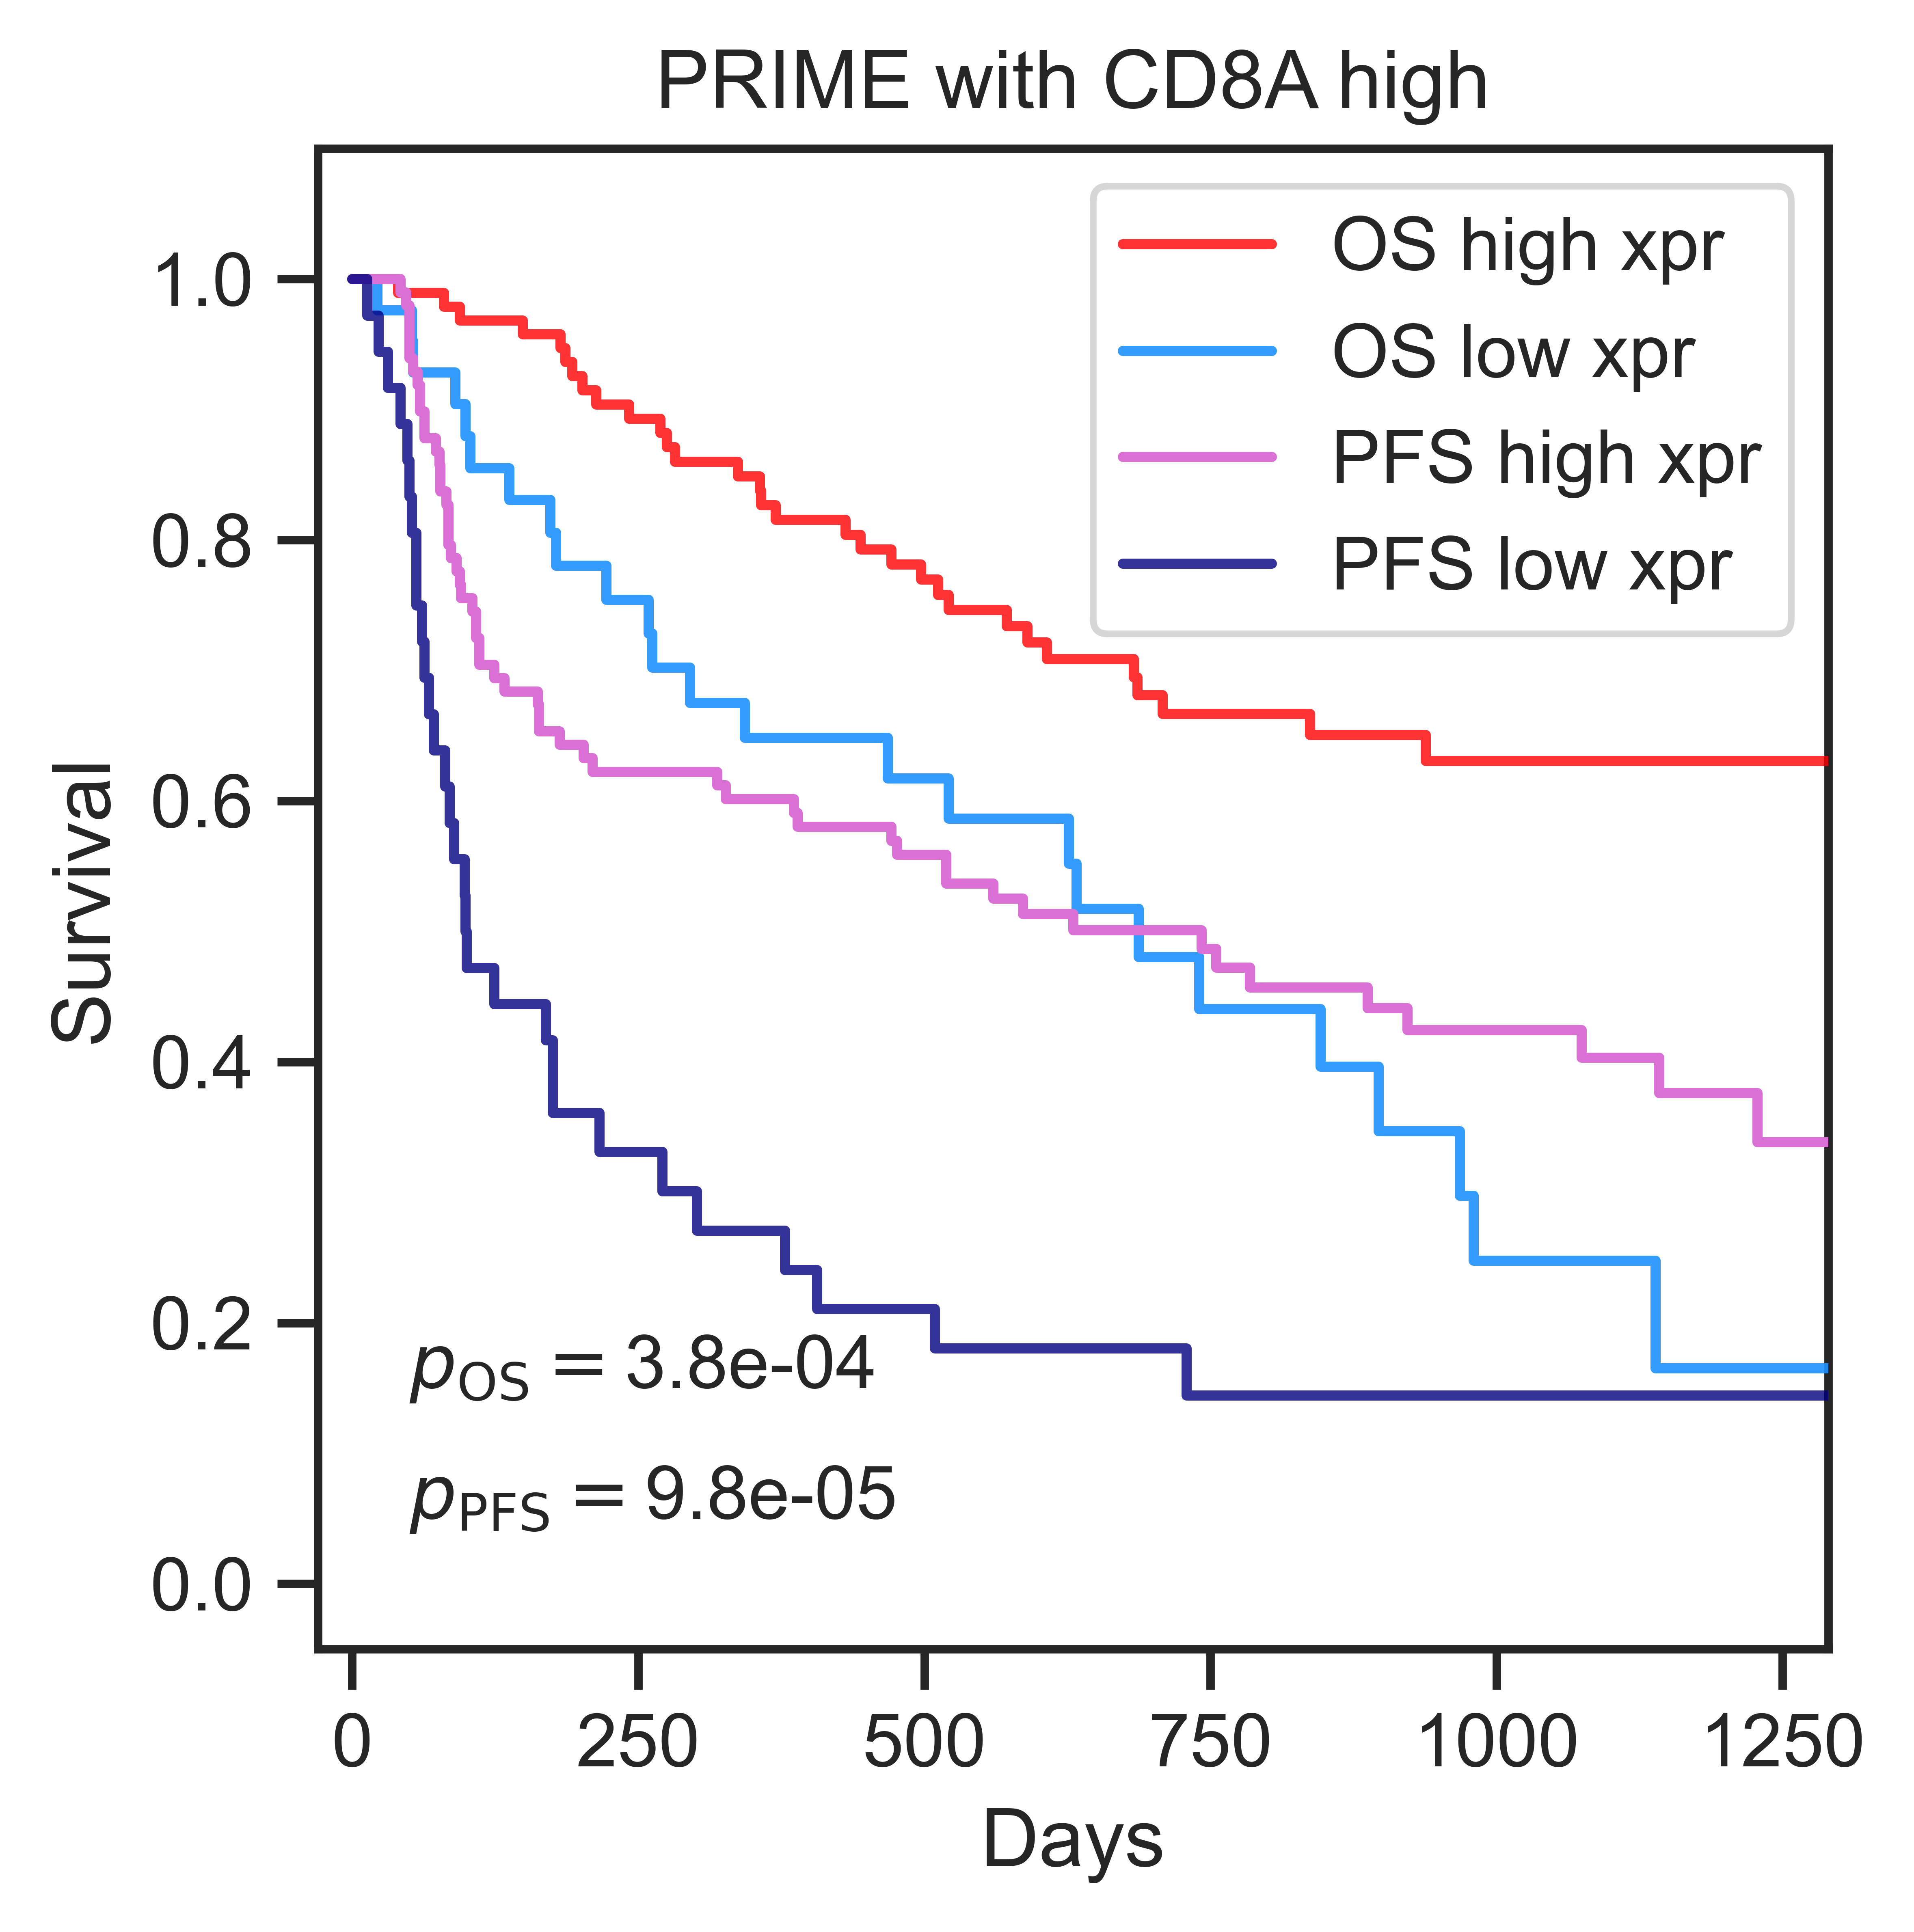

In [26]:
thresholds_opt_cd8hi = np.array([0.26, 0.75, 0.66, 0.47, 0.42, 0.57, 0.26])

model_ind = len(Models)-1
stratify_by_CD8 = True

model = 'PRIME'

#pt_pfs: alive=0 , dead=1. Check that all patients with RECIST have pfs events and days data
# pt_pfs = np.where((~pd.isna(os_pfs_df['PFS Status'].values))&(~pd.isna(os_pfs_df['PFS Days'].values))&((batch_inds==3)|(batch_inds>4)))[0]
pt_pfs = np.where((~pd.isna(os_pfs_df['PFS Status'].values))&(~pd.isna(os_pfs_df['PFS Days'].values)))[0]

if stratify_by_CD8:
    
    quantiles = np.quantile(log2tpm_bc.loc['CD8A'],[0.25,0.5,0.75])
    pt_strat = np.where(log2tpm_bc.loc['CD8A']>quantiles[1])[0]

    pt_pfs = np.intersect1d(pt_pfs, pt_strat)

pfs_days_df =  os_pfs_df.iloc[pt_pfs]['PFS Days']
pfs_event_df = os_pfs_df.iloc[pt_pfs]['PFS Status']

tpm_data = tpm_bc.iloc[:,pt_pfs] 
log2tpm_data = log2tpm_bc.iloc[:,pt_pfs] 

responders_data = responders.iloc[pt_pfs]

irs_data = irs.iloc[pt_pfs]
batch_ind_data = batch_inds[pt_pfs]


if model == 'PRIME':

    weights = gsp_psp_stats['weights'].values
    data = tpm_data
    model_data = np.matmul((weights.reshape(-1,1).T),np.log2(1+data.loc[gsp_psp_stats.index.values]).values.astype(float)).T


model_data = (model_data - np.mean(model_data))/np.std(model_data,axis=0)

timeline_all = np.sort(np.append(0.,pfs_days_df))
pt_all = tpm_data.keys().values

if stratify_by_CD8:
    
    threshold = thresholds_opt_cd8hi[model_ind]

else:

    threshold = thresholds_opt[model_ind]
    
print(threshold)


KMstats_lowhi_xpr_pfs =  pd.DataFrame(index=['Log rank chi^2','Log rank p','log-rank test score'], columns = ['Feature'])

#Genes with low beta
lower_half_bin = (model_data<np.quantile(model_data,[threshold])[0])
#Genes with high beta
upper_half_bin = (model_data>=np.quantile(model_data,[threshold])[0])


lower_half_pts = pt_all[np.where(lower_half_bin)[0]]
upper_half_pts = pt_all[np.where(upper_half_bin)[0]]

lower_half_days = np.array([])
lower_half_events = np.array([])

upper_half_days = np.array([])
upper_half_events = np.array([])

if len(lower_half_pts)>0:
   
    for pt in lower_half_pts:

        lower_half_days = np.append(lower_half_days, pfs_days_df.loc[pt])
        lower_half_events =  np.append(lower_half_events, pfs_event_df.loc[pt].astype(int))

    kmfl_pfs = KaplanMeierFitter()
    kmfl_pfs.fit(lower_half_days, lower_half_events, timeline=timeline_all, label = 'Low xpr')  


if len(upper_half_pts)>0:
    
    for pt in upper_half_pts:

        upper_half_days = np.append(upper_half_days, pfs_days_df.loc[pt])
        upper_half_events =  np.append(upper_half_events, pfs_event_df.loc[pt].astype(int))
  

    kmfu_pfs = KaplanMeierFitter()
    kmfu_pfs.fit(upper_half_days, upper_half_events, timeline=timeline_all, label = 'High xpr')  

lrt_results_pfs = logrank_test(lower_half_days, upper_half_days, lower_half_events, upper_half_events) 

log_rank_chi2_pfs = lrt_results_pfs.test_statistic
p_value_pfs = lrt_results_pfs.p_value
lrt_score_pfs  = log_rank_chi2_pfs - np.log(p_value_pfs)

KMstats_lowhi_xpr_pfs = np.array([log_rank_chi2_pfs, p_value_pfs, lrt_score_pfs])
print(model,log_rank_chi2_pfs,p_value_pfs, lrt_score_pfs, threshold)

#pt_os: alive=0 , dead=1. Check that all patients with RECIST have pfs events and days data
# pt_os = np.where((~pd.isna(os_pfs_df['OS Status'].values))&(~pd.isna(os_pfs_df['OS Days'].values))&((batch_inds==3)|(batch_inds>4)))[0]
pt_os = np.where((~pd.isna(os_pfs_df['OS Status'].values))&(~pd.isna(os_pfs_df['OS Days'].values)))[0]

if stratify_by_CD8:
    
    quantiles = np.quantile(log2tpm_bc.loc['CD8A'],[0.25,0.5,0.75])
    pt_strat = np.where(log2tpm_bc.loc['CD8A']>quantiles[1])[0]

    pt_os = np.intersect1d(pt_os, pt_strat)

os_days_df =  os_pfs_df.iloc[pt_os]['OS Days']
os_event_df = os_pfs_df.iloc[pt_os]['OS Status']

tpm_data = tpm_bc.iloc[:,pt_os] 
log2tpm_data = log2tpm_bc.iloc[:,pt_os] 

responders_data = responders.iloc[pt_os]

irs_data = irs.iloc[pt_os]
batch_ind_data = batch_inds[pt_os]


if model == 'PRIME':

    weights = gsp_psp_stats['weights'].values
    data = tpm_data
    model_data = np.matmul((weights.reshape(-1,1).T),np.log2(1+data.loc[gsp_psp_stats.index.values]).values.astype(float)).T


model_data = (model_data - np.mean(model_data))/np.std(model_data,axis=0)

timeline_all = np.sort(np.append(0.,os_days_df))
pt_all = tpm_data.keys().values

thresholds_opt_cd8hi = np.array([0.26, 0.74, 0.51, 0.71, 0.4 , 0.37, 0.3 ])
if stratify_by_CD8:
    
    threshold = thresholds_opt_cd8hi[model_ind]

else:

    threshold = thresholds_opt[model_ind]
    
print(threshold)

#Genes with low beta
lower_half_bin = (model_data<np.quantile(model_data,[threshold])[0])
#Genes with high beta
upper_half_bin = (model_data>=np.quantile(model_data,[threshold])[0])


lower_half_pts = pt_all[np.where(lower_half_bin)[0]]
upper_half_pts = pt_all[np.where(upper_half_bin)[0]]

lower_half_days = np.array([])
lower_half_events = np.array([])

upper_half_days = np.array([])
upper_half_events = np.array([])

if len(lower_half_pts)>0:
   
    for pt in lower_half_pts:

        lower_half_days = np.append(lower_half_days, os_days_df.loc[pt])
        lower_half_events =  np.append(lower_half_events, os_event_df.loc[pt].astype(int))

    kmfl_os = KaplanMeierFitter()
    kmfl_os.fit(lower_half_days, lower_half_events, timeline=timeline_all, label = 'Low xpr')  


if len(upper_half_pts)>0:
    
    for pt in upper_half_pts:

        upper_half_days = np.append(upper_half_days, os_days_df.loc[pt])
        upper_half_events =  np.append(upper_half_events, os_event_df.loc[pt].astype(int))
  

    kmfu_os = KaplanMeierFitter()
    kmfu_os.fit(upper_half_days, upper_half_events, timeline=timeline_all, label = 'High xpr')  

lrt_results_os = logrank_test(lower_half_days, upper_half_days, lower_half_events, upper_half_events) 

log_rank_chi2_os = lrt_results.test_statistic
p_value_os = lrt_results_os.p_value
lrt_score_os  = log_rank_chi2_os - np.log(p_value_os)

KMstats_lowhi_xpr_os = np.array([log_rank_chi2_os, p_value_os, lrt_score_os])
print(model,log_rank_chi2_os,p_value_os, lrt_score_os, threshold)

sns.set_style("ticks")
plt.figure(figsize=(4,4), dpi=1200)
ax = plt.subplot(111)


kmfu_os.plot_survival_function(ax=ax, ci_show=False, c='red', alpha=0.8, label = 'OS high xpr', zorder=5)
kmfl_os.plot_survival_function(ax=ax, ci_show=False, ci_legend= False, c='dodgerblue', alpha=0.9,  label = 'OS low xpr', zorder=3)

kmfu_pfs.plot_survival_function(ax=ax, ci_show=False, c='orchid', alpha=1, linestyle='solid', linewidth=1.5, label = 'PFS high xpr', zorder=10)
kmfl_pfs.plot_survival_function(ax=ax, ci_show=False, ci_legend= False, c='navy', linewidth=1.5, alpha=0.8,linestyle='solid', label = 'PFS low xpr', zorder=10)

# ax.fill_between( kmfu_os.survival_function_['High xpr'].index.values, kmfu_os.survival_function_['High xpr'],kmfl_os.survival_function_['Low xpr'], color='dodgerblue', alpha=0.1)
# ax.fill_between( kmfu_pfs.survival_function_['High xpr'].index.values, kmfu_pfs.survival_function_['High xpr'],kmfl_pfs.survival_function_['Low xpr'], color='blueviolet', alpha=0.1)


# title='Kaplan-Meier ' + gene
ax.set_title('PRIME with CD8A high')

p_text_os = '$p_{\mathrm{OS}} =$' + str("%.1e" % p_value_os)
ax.text(50,0.15, p_text_os, fontsize=11)

p_text_pfs = '$p_{\mathrm{PFS}} =$' + str("%.1e" % p_value_pfs)
ax.text(50,0.05, p_text_pfs, fontsize=11)

ax.set_ylim([-0.05,1.1])
ax.set_xlim([-30,1290])

ax.set_xlabel('Days')
ax.set_ylabel('Survival')

filepath = str(model)+'_os_pfs_km_cd8hi.pdf'
plt.savefig(filepath, dpi=600)

plt.show()



## Combined analysis

In [27]:
from scipy.interpolate import interp1d

def convolved_log2_km_ratio(survival_f1, survival_f2, window_size=10):

    # survival functions must be dataframes with the timeline as index

    timeline = survival_f1.index.values
    lkmr  = np.log2( survival_f1/survival_f2)

    # Remove duplicate points
    unique_indices = np.unique(timeline, return_index=True)[1]
    timeline = timeline[unique_indices]
    lkmr = lkmr.iloc[unique_indices]

    interp_func = interp1d(timeline, lkmr, kind='linear')

    # Define new equidistant points
    new_timeline = np.arange(0, np.ceil(timeline[::-1][0]), 1)  # From 0 to 15 with step 1
    new_lkmr = interp_func(new_timeline)

    window = np.ones(window_size)/window_size
    
    # Apply convolution
    convolved_lkmr = np.convolve(new_lkmr, window, mode='same')
    
    return new_timeline, convolved_lkmr 
    

IMPRES 2.2542789897533173 0.13324550309699695 4.269840954123911 0.26
TIDE 6.527455616890007 0.010622179590302268 11.07226666662433 0.75
CTL 7.697691511282148 0.005529149657884441 12.895412755471517 0.66
TMB 3.4537575293235787 0.06310814849574174 6.216662910871797 0.47
PD1 4.256197417678037 0.03910736875727874 7.49764178815963 0.42
PDL1 11.298117456422887 0.0007758571844170855 18.459659551841142 0.57
PRIME 15.170706476075948 9.821529644549685e-05 24.399055062526337 0.26


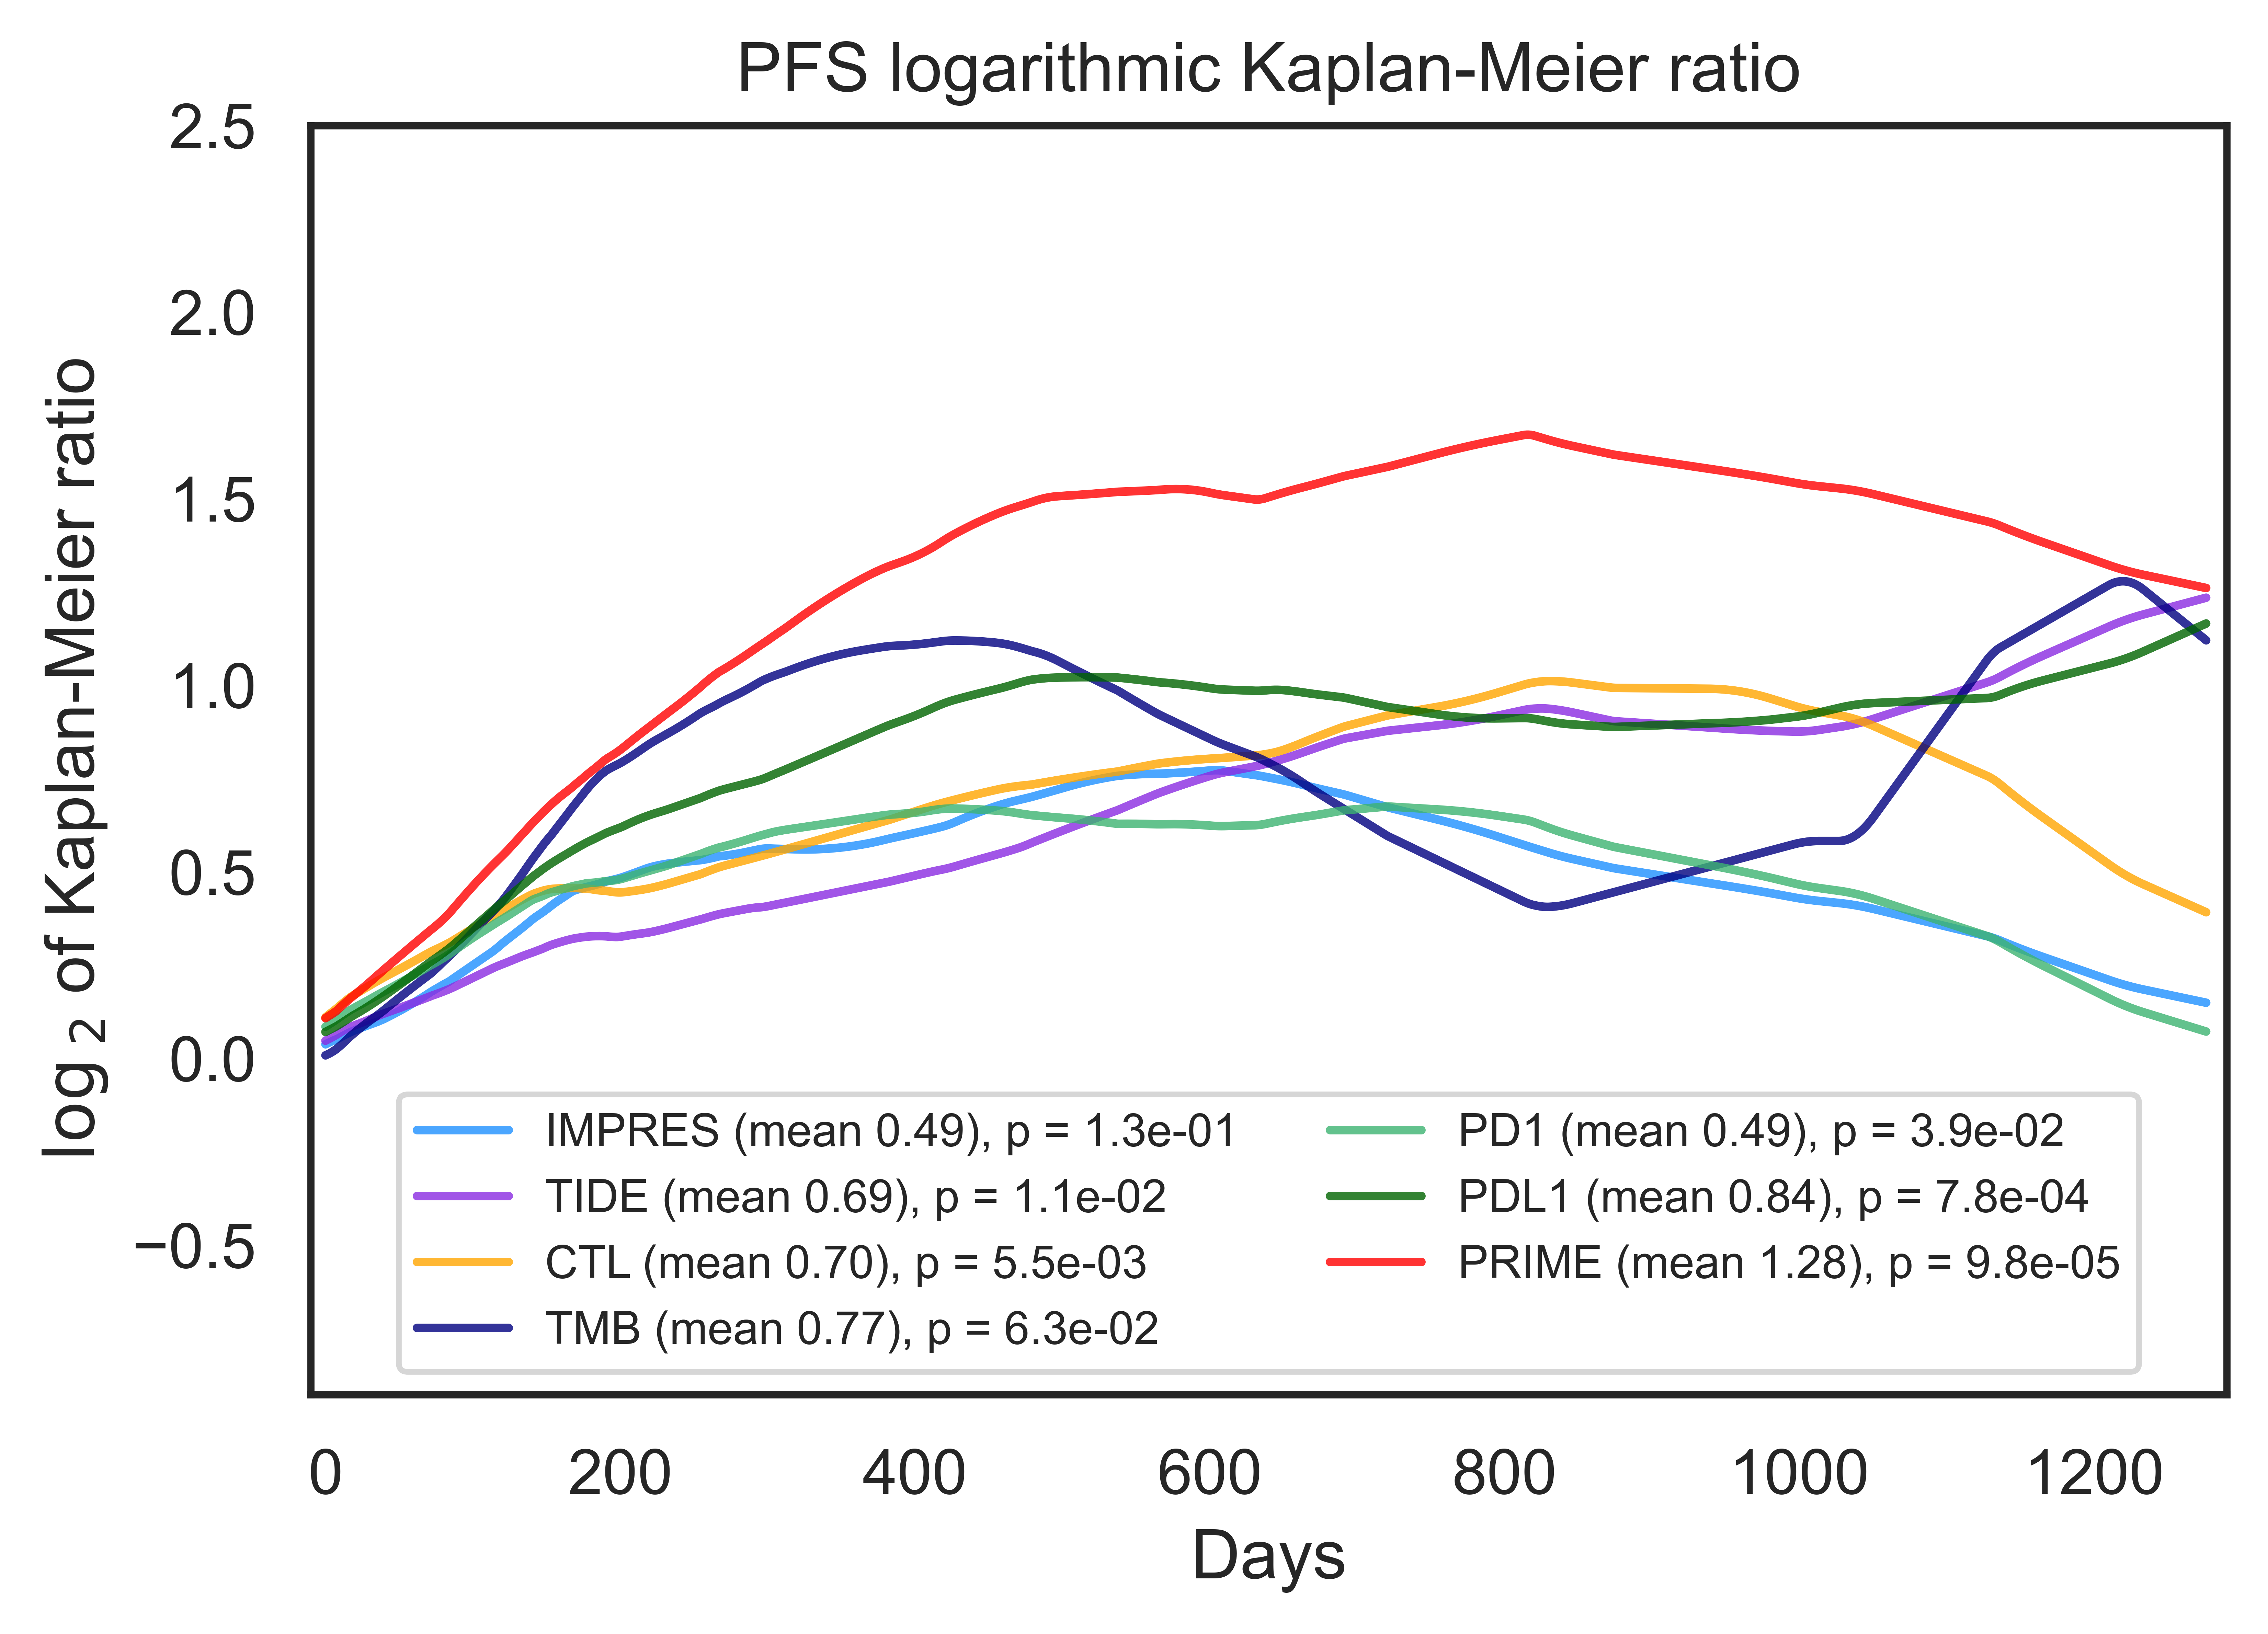

In [29]:

# # CD8 above median
thresholds_opt_cd8hi = np.array([0.26, 0.75, 0.66, 0.47, 0.42, 0.57, 0.26])

model_ind = 0
stratify_by_CD8 = True

sns.set_style("white")
plt.figure(figsize=(6,4),dpi=1200)

colors=['dodgerblue','blueviolet','orange','navy','mediumseagreen','darkgreen','red']

mean_lkmrs = np.array([])

for model in Models:

    #pt_pfs: alive=0 , dead=1. Check that all patients with RECIST have pfs events and days data
    # pt_pfs = np.where((~pd.isna(os_pfs_df['PFS Status'].values))&(~pd.isna(os_pfs_df['PFS Days'].values))&((batch_inds==3)|(batch_inds>4)))[0]
    pt_pfs = np.where((~pd.isna(os_pfs_df['PFS Status'].values))&(~pd.isna(os_pfs_df['PFS Days'].values)))[0]

    if stratify_by_CD8:
        
        quantiles = np.quantile(log2tpm_bc.loc['CD8A'],[0.25,0.5,0.75])
        pt_strat = np.where(log2tpm_bc.loc['CD8A']>quantiles[1])[0]
    
        pt_pfs = np.intersect1d(pt_pfs, pt_strat)
    
    pfs_days_df =  os_pfs_df.iloc[pt_pfs]['PFS Days']
    pfs_event_df = os_pfs_df.iloc[pt_pfs]['PFS Status']
    
    tpm_data = tpm_bc.iloc[:,pt_pfs] 
    log2tpm_data = log2tpm_bc.iloc[:,pt_pfs] 
    
    responders_data = responders.iloc[pt_pfs]
    
    irs_data = irs.iloc[pt_pfs]
    batch_ind_data = batch_inds[pt_pfs]

    if model == 'CTL':

        model_data =  np.log2(1+compute_ctl_score(tpm_data))


    if model=='TMB':

        pt_pfs = np.intersect1d(pt_pfs,tmb_measured)
        model_data = TMB_aux[pt_pfs]

    if model == 'IMPRES':

        model_data =  -impres_scores[pt_pfs]

    if model == 'TIDE':

        tide_results = tide_res.iloc[pt_pfs,:] 
        tide_df = pd.DataFrame(data = tide_results.values, index= log2tpm_data.keys(), columns= tide_res.columns )
        tide_scores = tide_df['TIDE'].values
        
        model_data = -tide_scores

    if (model == 'PD1'):

        model_data =  log2tpm_data.loc['PDCD1']

    if (model == 'PDL1'):

        model_data =  log2tpm_data.loc['CD274']
    
    if model == 'PRIME':

        weights = gsp_psp_stats['weights'].values
        data = tpm_data
        model_data = np.matmul((weights.reshape(-1,1).T),np.log2(1+data.loc[gsp_psp_stats.index.values]).values.astype(float)).T

    
    model_data = (model_data - np.mean(model_data))/np.std(model_data,axis=0)
    
    timeline_all = np.sort(np.append(0.,pfs_days_df))
    pt_all = tpm_data.keys().values

    if stratify_by_CD8:
        
        threshold = thresholds_opt_cd8hi[model_ind]
    
    else:

        threshold = thresholds_opt[model_ind]
        

    KMstats_lowhi_xpr =  pd.DataFrame(index=['Log rank chi^2','Log rank p','log-rank test score'], columns = ['Feature'])
    
    #Genes with low beta
    lower_half_bin = (model_data<np.quantile(model_data,[threshold])[0])
    #Genes with high beta
    upper_half_bin = (model_data>=np.quantile(model_data,[threshold])[0])

    
    lower_half_pts = pt_all[np.where(lower_half_bin)[0]]
    upper_half_pts = pt_all[np.where(upper_half_bin)[0]]
    
    lower_half_days = np.array([])
    lower_half_events = np.array([])
    
    upper_half_days = np.array([])
    upper_half_events = np.array([])
    
    if len(lower_half_pts)>0:
       
        for pt in lower_half_pts:
    
            lower_half_days = np.append(lower_half_days, pfs_days_df.loc[pt])
            lower_half_events =  np.append(lower_half_events, pfs_event_df.loc[pt].astype(int))
    
        kmfl = KaplanMeierFitter()
        kmfl.fit(lower_half_days, lower_half_events, timeline=timeline_all, label = 'Low xpr')  
    
    
    if len(upper_half_pts)>0:
        
        for pt in upper_half_pts:
    
            upper_half_days = np.append(upper_half_days, pfs_days_df.loc[pt])
            upper_half_events =  np.append(upper_half_events, pfs_event_df.loc[pt].astype(int))
      
    
        kmfu = KaplanMeierFitter()
        kmfu.fit(upper_half_days, upper_half_events, timeline=timeline_all, label = 'High xpr')  


        lkmr =  convolved_log2_km_ratio(kmfu.survival_function_['High xpr'],kmfl.survival_function_['Low xpr'],window_size=183)
        
    # Only 3.5 years because there are few events after that
    timeline = lkmr[0][0:1277]
    lkmr = lkmr[1][0:1277]

    #export lkmr function for comparison with unrestricted CD8A cohort
    lkmr_df = pd.DataFrame(lkmr)
    lkmr_df.to_csv(str(model)+'_lkmr_PFS_CD8Ahi.csv', index=False)

    lrt_results = logrank_test(lower_half_days, upper_half_days, lower_half_events, upper_half_events) 

    log_rank_chi2 = lrt_results.test_statistic
    p_value = lrt_results.p_value
    lrt_score  = log_rank_chi2 - np.log(p_value)
    
    print(model,log_rank_chi2,p_value, lrt_score, threshold)
    
    mean_lkmr = np.trapz(lkmr, timeline)/timeline[::-1][0]
    plt.plot( timeline ,lkmr, linewidth=1.5, color=colors[model_ind], label= str(model) +' (mean %0.2f)' % mean_lkmr % mean_lkmr +', p = %0.1e' % p_value, alpha=0.8)
    
    model_ind = model_ind+1

    mean_lkmrs = np.append(mean_lkmrs, mean_lkmr)
    

plt.title('PFS logarithmic Kaplan-Meier ratio')

plt.xlabel('Days')
plt.ylabel('${\log}_2$ of Kaplan-Meier ratio')

plt.legend(ncol=2, fontsize=8, loc='lower center')
plt.xlim(-10,1290)
plt.ylim(-0.9,2.5)

filepath ='log_km_ratios_cd8hi.pdf'
plt.savefig(filepath, dpi=1200)

plt.show()
